In [3]:
import random
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time as t
import re # Регулярные выражения
# для рандомизации времени засыпания
from random import randint
from tqdm import tqdm_notebook
from wordcloud import WordCloud, STOPWORDS # облако слов
from sklearn.preprocessing import MultiLabelBinarizer # для dummy
from collections import Counter # счетчик для списков

# fake_user + bs4

# импортировали  методов этой библиотеки
from fake_useragent import UserAgent
# импортировали библиотеку
from bs4 import BeautifulSoup

# selenium + ChromeDriverManager

from selenium import webdriver
# A Service class that is responsible for the starting and stopping of chromedriver.
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

 #      имп ортировали ChromeDriverManager чтобы получить chromedriver path
from webdriver_manager.chrome import ChromeDriverManager

# отключение предупреждений
import warnings
warnings.filterwarnings("ignore")

# Наташа и кишки
from natasha import (
    Segmenter,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    Doc,
    NewsNERTagger,
    MorphVocab,
    PER
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Парсер

In [ ]:
def getPageLinks_mirfant(page_number):
    """
        Берет номер страницы с обзорами
        Возвращает список ссылок на обзоры, полученный из соответствующего раздела       

    """
    # составляем ссылку на страницу поиска
    page_link = 'https://www.mirf.ru/category/book/bookreview/page/{}/'.format(page_number)

    # запрашиваем данные по ней
    response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})

    if not response.ok :
        # если сервер нам отказал, вернем пустой лист для текущей страницы
        return []

    # получаем содержимое страницы и переводим в суп
    html = response.content
    soup = BeautifulSoup(html,'html.parser')

    # находим все ссылки на обзоры на странице
    elements = soup.findAll('div', attrs = {'class':'home_article_item_image'})
    # берем дочерний элемени и из него атрибут 'href'
    # список списков преобразуем в просто список
    url = [[ch.attrs['href'] for ch in elem.findChildren("a")] for elem in elements]
    links_list = sum(url, [])

    return links_list

In [ ]:
# протестируем функцию
getPageLinks_mirfant(2)

In [ ]:
# зададим счетчик который пойдет в номер страницы в функции
# и большой список, в который пойдут списки ссылок с каждой страницы раздела
counter = 0
long_list = []

In [ ]:
# применим функцию в цикле, который пройдет по 11 страницам раздела с обзорами книг
while True:
    try:
        counter = counter + 1
        links_list = getPageLinks_mirfant(counter)
        long_list = long_list + links_list
        print(counter, 'пеерход на следующую страницу')
        print('у нас', len(long_list), 'ссылок')
        t.sleep(randint(2,5))
        if counter > 11:
            break
    except Exception as e:
        print('цикл окончен')
        break

mirf_links = pd.DataFrame(long_list, columns = ['Url'])

In [ ]:
def getItems_mirf(url):
    """
        Берет url
        Возвращает df c колонками url, автор, дата публикации, заголовок, подзаголовок, описание, текст, просмотры

    """

    # запрашиваем данные по ней
    response = requests.get(url, headers={'User-Agent': UserAgent().chrome})

    if not response.ok :
        # если сервер нам отказал, вернем пустой лист для текущей страницы
        return []

    # получаем содержимое страницы и переводим в суп
    html = response.content
    soup = BeautifulSoup(html,'html.parser')

    # ищем элементы и берем из них нужное

#     автор
    try:
        author = [soup.find('a', attrs = {'class':'author url fn'}).text]
        author = [s.replace('\xa0', ' ') for s in author]
    except:
        author = None

#     дата
    try:
        date = soup.find('div', attrs = {'class':'head_post_desc_more_2'})
        date.find('a').decompose()
        date = [date.text]
        date = [s.replace('\n', '') for s in date]
        date = [s.replace('\t', '') for s in date]
    except:
        date = None

#     заголовок
    try:
        title = [soup.find('h1').text]
        title = [s.replace('&nbsp;', ' ') for s in title]
    except:
        title = None

#     подзаголовок (его нет у mirf)
    try:
        subtitle = None
#         subtitle = [soup.find('em').text]
#         subtitle = [s.replace('\xa0', ' ') for s in subtitle]

    except:
        subtitle = None


#   описание собираем разные еэлементы
#   они по-разному оформлялись за время выхода mif, поэтому шаблонов несколько под разные варианты
    try:
        try:
            content = soup.find('section', attrs = {'class':'content'})
            description = content.find('div', attrs = {'class':['lead', 'highlight']}).text

            description = description.replace('\n', ' ')
            description = description.replace('&nbsp;', ' ')
            description = description.replace('\xa0', ' ')
        except:
            description = ''

        good = soup.findAll('div', attrs = {'class':'lets-review-block__procon lets-review-block__pro'})
        good = [g.text for g in good]
        bad = soup.findAll('div', attrs = {'class':'lets-review-block__procon lets-review-block__con'})
        bad = [b.text for b in bad]
        good = ', '.join(good)
        good = "Удачно: " + good + ". "
        bad = ', '.join(bad)
        bad = "Неудачно: " + bad + ". "

        try:    
            score = soup.find('div', attrs = {'class':['score']}).text
            score = " Оценка книги: " + score + ". "
        except:
            try:
                text = soup.find('div', attrs = {'id':'wtr-content'})
                text = text.find('div', attrs = {'class':'lets-review-block__wrap'})
                text = text.find('div', attrs = {'class':'score__wrap'})
                score = text.find('div', attrs = {'class':'score'}).text
                score = " Оценка книги: " + score + ". "
            except:
                score = ''

        try:
            j = soup.find('div', attrs = {'class':['vrezka float', 'vrezka2 float']}).text
            # j = j.find('div', attrs = {'class':'vrezka2 float'}).text
            j = j.strip("\n").split("\n")
            j = [jan for jan in j if jan.startswith('Жанр:') | jan.startswith(' Жанр:') ]
            j = ''.join(j)
            j = j.replace('\xa0', ' ')
        except:
            j = ''

        try:
            it = soup.find_all('div', attrs = {'class':['highlight']})
            it = [cur.text for cur in it][-1]
            it = it.replace('\xa0—', ' ')
            it = it.replace('\xa0', ' ')
            it = it.strip('\n')

        except:
            it = soup.find('div', attrs = {'id':'wtr-content'})
            it.find('div', attrs = {'class':['vrezka float', 'vrezka2 float']}).decompose()
            it = it.find('div', attrs = {'class':'vrezka2'}).text.replace('\n', ' ')
            it = it.replace('\xa0—', ' ')
            it = it.replace('\xa0', ' ')
            it = it.strip('\n')


        desc2 = good + bad + it + score + j
        description = [description + " " + desc2]
        
    except:
        try:
            content = soup.find('section', attrs = {'class':'content'})
            description = content.find('div', attrs = {'class':['lead',
                                                               'highlight']}).text

            description = description.replace('\n', ' ')
            description = description.replace('&nbsp;', ' ')

            good = soup.findAll('div', attrs = {'class':'lets-review-block__procon lets-review-block__pro'})
            good = [g.text for g in good]
            bad = soup.findAll('div', attrs = {'class':'lets-review-block__procon lets-review-block__con'})
            bad = [b.text for b in bad]
            good = ', '.join(good)
            good = "Удачно: " + good + ". "
            bad = ', '.join(bad)
            bad = "Неудачно: " + bad + ". "
            text = soup.find('div', attrs = {'id':'wtr-content'})
            text = text.find('div', attrs = {'class':'lets-review-block__wrap'})
            text = text.find('div', attrs = {'class':'score__wrap'})
            score = text.find('div', attrs = {'class':'score'}).text
            score = " Оценка книги: " + score + ". "
            it = soup.find('div', attrs = {'id':'wtr-content'})
            it = it.find('div', attrs = {'class':'vrezka2'}).text.replace('\n', ' ')

            desc2 = good + bad + it + score
            description = [description + desc2]
        except:
            try:
                content = soup.find('section', attrs = {'class':'content'})
                description = content.find_all('div', attrs = {'class':['lead',
                                                                           'highlight']})
                desc = [t.text.replace('\n', ' ') for t in description]
                desc = " ".join(desc)

                good = soup.findAll('div', attrs = {'class':'lets-review-block__procon lets-review-block__pro'})
                good = [g.text for g in good]
                bad = soup.findAll('div', attrs = {'class':'lets-review-block__procon lets-review-block__con'})
                bad = [b.text for b in bad]
                good = ', '.join(good)
                good = "Удачно: " + good + ". "
                bad = ', '.join(bad)
                bad = "Неудачно: " + bad + ". "
                desc2 = good + bad

                description = [desc + desc2]
            except:
                description = None


#     текст
    try:
        text = soup.find('div', attrs = {'id':'wtr-content'})
        text.find('div', attrs = {'class':['lead', 'highlight']}).decompose()
        text.find('div', attrs = {'class':'vrezka2 float'}).decompose()
        text.find('div', attrs = {'class':'vrezka2'}).decompose()
        text.find('h2').decompose()
        text.find('blockquote').decompose()
        text.find('div', attrs = {'class':'lets-review-block__wrap'}).decompose()
        text = text.text
        text = text.replace('&nbsp;', ' ')
        text = text.replace('\xa0—', ' ')

        text = [text + it]
    except:
        try:
            text = soup.find('div', attrs = {'id':'wtr-content'})
            text.find('div', attrs = {'class':['lead', 'highlight']}).decompose()
            try:
                text.find('div', attrs = {'class':['vrezka2 float', 'vrezka float']}).decompose()
            except:
                pass
            
            text.find('div', attrs = {'class':'lets-review-block__wrap'}).decompose()
            text = text.text
            text = text.replace('&nbsp;', ' ')
            text = text.replace('\xa0—', ' ')
            text = [text.replace('\xa0', ' ')]

        except:
            try:
                text = soup.find('section', attrs = {'class':'content'})
                try:
                    text.find('div', attrs = {'class':['content_footer', 'vrezka2 su-see-also']}).decompose()
                except:
                    pass
                text = text.text
                text = text.replace('&nbsp;', ' ')
                text = text.replace('\xa0—', ' ')
                text = [text.replace('\xa0', ' ')]
            except:
                text = None

    #   просмотры
    try:
        views = soup.find('span', attrs = {'class':'post-views-count'}).text
        views = [views.replace('&nbsp;', '')]
#         views = [views.replace('\xa0', '')]
    except:
        views = None


    dic = {
        'url': url,
        'author': author,
        'publ_date': date,
        'title': title,
        'subtitle': subtitle,
        'description': description,
        'text': text,
        'views': views
            }

    data_row = pd.DataFrame(dic)

    return data_row

In [ ]:
d = getItems_mirf('https://www.mirf.ru/book/sergej-lukyanenko-porog/')
d

In [ ]:
mirf_links = pd.read_csv('/Users/user/My Python Stuff/NLP/mirfantastic_bookreview_links.csv')

In [ ]:
sm_list = mirf_links['Url'].tolist()

In [ ]:
mirf_bookreview_df = pd.DataFrame(columns = ['url',
                                               'author',
                                               'publ_date',
                                               'title',
                                               'subtitle',
                                               'description',
                                               'text',
                                                'views'])

In [ ]:
for url in tqdm_notebook(sm_list):
    try:
        data_row = getItems_mirf(url)
        mirf_bookreview_df = pd.concat([mirf_bookreview_df, data_row], ignore_index=True)
        t.sleep(randint(3,5))
    except:
        continue
        
mirf_bookreview_df.to_csv('/Users/user/My Python Stuff/NLP/mirf_bookreview_df.csv')

In [ ]:
mirf_bookreview_df['description'][631]

## Тест супа

In [ ]:
page_link = 'https://www.mirf.ru/book/nik-perumov-vojna-angelov-ignis/'
response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
html = response.content
soup = BeautifulSoup(html,'html.parser')

In [ ]:
j = soup.find('div', attrs = {'class':['vrezka float', 'vrezka2 float']}).text
# j = j.find('div', attrs = {'class':'vrezka2 float'}).text
j = j.strip("\n").split("\n")
j = [jan for jan in j if jan.startswith('Жанр:') | jan.startswith(' Жанр:') ]
j = ''.join(j)
j

In [ ]:
# content = soup.find('section', attrs = {'class':'content'})
score = soup.find('div', attrs = {'class':['score']}).text
# it = [cur.text for cur in it][-1]
score 

In [ ]:
mirf_bookreview_df

In [ ]:
mirf_bookreview_df['text'][393]

## Предобработка и EDA

- дату к правильному формату
- из просмотров убрать пробел и к формату
- текст обзора почистить от лишкних символов (какие?) 
- в description есть доп. инфа о каждой книге (в отдельные столбцы):
    - жанр книг, на которую написана рецензия
    - то что в ней Удачно и Неудачно
<br><br>
- сколько рецензий вышло за год
- то же для каждого автора
- какие вообще жанры фантастики есть, 
- на какие жанры чаще пишур рецензии какие авторы (есть ли у рецензентов жанравая специализация)
- есть ли авторов рецензий предпочтения к авторам и жанрам, судя по оценке книги
- средняя длинна рецензии в токенах для авторов
- облака слов для каждого (распарсим Наташей?) чтобы узнать что-то об авторе

In [4]:
# загрузили
df = pd.read_csv('/Users/user/My Python Stuff/NLP/mirf_bookreview_df.csv')

In [5]:
# посмотрим
df.sample(10)

Unnamed: 0                                                url  \
234         234  https://www.mirf.ru/book/uilyam-hyortsberg-ser...   
283         283  https://www.mirf.ru/book/yaroslav-gzhendovich-...   
0             0  https://www.mirf.ru/book/n-k-dzhemisin-gorod-k...   
388         388  https://www.mirf.ru/book/fantasticheskij-nyu-j...   
387         387  https://www.mirf.ru/book/aleksej-ivanov-pische...   
652         652  https://www.mirf.ru/book/bookreview/timur-verm...   
669         669      https://www.mirf.ru/book/andy-weir-marsianin/   
189         189  https://www.mirf.ru/book/brendon-sanderson-vid...   
13           13  https://www.mirf.ru/book/brajan-ketling-vorr-l...   
143         143  https://www.mirf.ru/book/viktor-pelevin-transh...   

                    author   publ_date  \
234          Ирина Нечаева  08.11.2020   
283          Артём Киселик  16.05.2020   
0           Катерина Яксон  27.01.2024   
388          Ирина Нечаева  20.02.2019   
387          Ирина Нечаева  21.02.2019   
652      Светлана Евсюкова  25.10.2015   
669          Алексей Ионов  22.09.2014   
189  Александр Стрепетилов  12.05.2021   
13          Елена Щетинина  04.12.2023   
143          Ирина Нечаева  06.11.2021   

                                                 title  subtitle  \
234  Уильям Хьёртсберг «Сердце ангела. Преисподняя ...       NaN   
283                        Ярослав Гжендович «Гелий-3»       NaN   
0    Н. К. Джемисин «Город, которым мы стали». Спас...       NaN   
388  «Фантастический Нью-Йорк»: сборник фэнтези о г...       NaN   
387  Алексей Иванов «Пищеблок»: пионерские ужасы дл...       NaN   
652                      Тимур Вермеш «Он снова здесь»       NaN   
669                             Энди Вейер «Марсианин»       NaN   
189  Брендон Сандерсон «Видящая звёзды»: примерно т...       NaN   
13   Брайан Кэтлинг «Ворр». Лучшее фэнтези по мнени...       NaN   
143  Виктор Пелевин «TRANSHUMANISM INC. ». Иронично...       NaN   

                                           description  \
234   1959 год. Таинственный бизнесмен Луи Цифер по...   
283   В либеральной антиутопии будущего журналистик...   
0     Все великие города мира, достигнув определённ...   
388   Нью-Йорк не то, чем кажется. Вампиры покупают...   
387   1980 год. В Москве начинается Олимпиада, а по...   
652  Заснув в своём бункере в апреле 1945-го, Адоль...   
669  Астронавту Марку Уотни не повезло. Он остался ...   
189   Прошло полгода с тех пор, как пилот-кадет Спе...   
13    Рядом с небольшим городком Эссенвальдом наход...   
143   В России произошла очередная революция, мир п...   

                                                  text   views  
234  \n \n\nПервый роман дилогии вышел более сорока...   1 096  
283  \n \n\nПроблема «Гелия-3» заключается втом, чт...   1 151  
0    \n \n\nНора Кейт Джемисин маститая американска...   2 835  
388  \n\nЕсли насредневековых картах центр мира зан...   2 694  
387  \n \n\nАлексей Иванов, писатель масштабный, се...  20 145  
652  \n\n\nБывший «литературный негр», журналист Ти...   2 307  
669  \n \n\nПрограммист Энди Вейер с ранних лет увл...   4 841  
189  \n \n\n\nСандерсон описывал «Устремлённую в не...   1 440  
13   \n \n\nРоман «Ворр» невозможно читать без пред...  13 237  
143  \n \n\nТа-дам! Пришло время новой книги Виктор...   1 069

In [6]:
# проверим есть ли еще строки у которых в publ_date что-то кроме дат
df[df.publ_date.str.contains(r'^(?!\d{2}.\d{2}.\d{4}$).*$', regex=True, na=False)]

Unnamed: 0                                                url  \
484         484  https://www.mirf.ru/book/roman-papsuev-skazki-...   

                 author                     publ_date  \
484  Дмитрий Злотницкий   и Евгения Блинова11.11.2017   

                                          title  subtitle  \
484  Роман Папсуев «Сказки старой Руси. Начало»       NaN   

                                           description  \
484   Всем нам с ранних лет знакомы Илья Муромец, В...   

                                                  text   views  
484  \n \n\nРоман Папсуев, известный в интернете по...  15 357

In [7]:
# заменим некоректное значение 
df.loc[df['publ_date'] == ' и Евгения Блинова11.11.2017', 'publ_date'] = '11.11.2017'

In [8]:
# к формату даты
df['publ_date'] = pd.to_datetime(df['publ_date'], format='%d.%m.%Y')

In [9]:
# взяли год из даты
df['year'] = pd.DatetimeIndex(df['publ_date']).year

In [10]:
# сделали округление до месяца года
df['month_year'] = pd.to_datetime(df['publ_date']).dt.to_period('M')

In [11]:
# заменил пробел в кол-ве просмотров
df['views'] = df['views'].replace('\xa0', '')

In [12]:
df['views'] = df['views'].str.replace('\xa0', '')

In [13]:
# к нужному типу
df['views'] = df['views'].astype('int')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   701 non-null    int64         
 1   url          701 non-null    object        
 2   author       701 non-null    object        
 3   publ_date    701 non-null    datetime64[ns]
 4   title        701 non-null    object        
 5   subtitle     0 non-null      float64       
 6   description  701 non-null    object        
 7   text         701 non-null    object        
 8   views        701 non-null    int64         
 9   year         701 non-null    int32         
 10  month_year   701 non-null    period[M]     
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(5), period[M](1)
memory usage: 57.6+ KB


In [15]:
# нужен список лишних символов, посмотрим, какие встречаются в текстах
for n in random.sample(range(0, 700), 5):
    display(df['text'][n])

'\n \n\nАннотация к дебютному роману американки Бекки Чамберс обещает задорное космическое приключение в духе сериала «Светлячок». А под обложкой обнаруживается малый типовой набор, свидетельствующий о том, что автор обладает изрядной начитанностью (и «насмотренностью»). В романе нашлось место и космическому кораблю-развалюхе (при этом летает он всё равно лучше всех, потому что у него, как вы догадываетесь, идеальная команда), и немногословному капитану с душой бунтаря, и комичной девушке-механику, и обаятельному искусственному интеллекту с женским голосом, и шумным межпланетным рынкам, и колониям киберпанков-модификантов…\nВ области технологий Чамберс также не стала изобретать велосипед: «Странник» пробивает туннели через загадочный «подслой» пространства, о котором читатели так ничего толком и не узнают просто потому, что и жители этой вселенной (читай автор) не очень-то в курсе. Галактика, в которой несколько технологически развитых рас образовали Сообщество и далеко не сразу принял

'\n \n\nЗа полвека литературной карьеры Кристофер Прист успел примерить разные маски, попробовать себя в разных амплуа, от звезды андеграунда до автора международных бестселлеров. Он начинал как писатель-фантаст, один из самых молодых представителей британской «новой волны», участвовал в скандальных сборниках, писал вызывающие и шокирующие тексты. Между делом опубликовал в СССР два больших романа, «Опрокинутый мир» и «Машину пространства», из авторов New Wave ему единственному удалось провернуть такой фокус. Позже от «фантастической фантастики» Прист отошёл хотя его книги по сей день продолжают выдвигаться на сугубо «жанровые» премии. Прославился на весь мир он в 2006 году благодаря экранизации романа «Престиж», снятой Кристофером Ноланом. В общем, случалось всякое но одна метафора, один образ оставался с Кристофером Пристом на протяжении всех этих лет: Архипелаг Грёз, вымышленная группа островов в вымышленном мире, раздираемом вполне реальными противоречиями.\nВпервые Архипелаг появил

'\n \n\nПожалуй, сильнее всего в «Стальных богах» впечатляет художественный мир — настолько он масштабен и проработан, и настолько хорошо он раскрывается и описывается по ходу сюжета. Роман рассказывает о двух очень разных империях и о различиях между ними, показанных глазами двух главных героев. Сирм — это «исламское» государство, Крестес — западно«христианское», а конфликт между ними сильно напоминает о крестовых походах.\nПлюс немного волшебства, магов и джиннов, активное участие богов в процессе и самая малость хоррор-элементов. Мир этот описан весьма реалистично, пышно, богато — и красиво. Музыка, цвета, одежда, запахи, еда, история, обычаи, стихи — автор не забыл ни о чем.\nВ центре внимания два героя, генерал Михей Железный и бывший герой Кева, и повествование ведётся с двух точек зрения, переход между которыми всегда получается довольно плавным. Повествование идет крайне стремительно уже с первых страниц, и временами эта скорость даже кажется чрезмерной: сюжет насыщенный и неск

'\n \n\nЗамечательная затравка для космических ужасов — особенно с элементами боди-хоррора (ну мало ли что может взбрести в голову сбрендившему от скуки искусственному интеллекту? И как он решит поиграть со спящими?), однако Уоттс не ищет лёгких и предсказуемых путей. Используя классический сюжет «корабля поколений», он играет с разными концепциями, в первую очередь со временем. По сути дела, для персонажей цикла время всего лишь условность. Для них важны только корсекунды бодрствования, но не столетия и тысячелетия сна. Их жизнь нарезана тонкими ломтиками — и можно, проснувшись в одну из сборок, из корабельного журнала узнать, что твои друзья погибли пару тысячелетий назад.\nВ истории «Эриофоры» не существует Земли, такой привычной для произведений о космосе. Нет тоски по оставленной родине, нет исковерканных, искажённых представлений или воспоминаний о ней. Да, тень земной культуры присутствует, но лишь как естественный, практически природный фон. Обитатели «Эриофоры» настолько оторв

'\n \n\nЗаключительная вродебы часть цикла (точнее, дилогии) зеркально повторяет схему первого романа. Если в«Кваzи» Денис Симонов принимал неживого инежелательного напарника Михаила вМоскве, тотеперь ихроли поменялись, иДенис стал неслишком желанным гостем вроссийской столице кваzи. Нет, Михаил-то своему московскому товарищу рад, новот его коллеги отсотрудника человеческой спецслужбы неввосторге. Исюжет «Кайноzоя» скроен потемже лекалам вруках у«роковой женщины» вновь оказывается некое загадочное вещество, способное нарушить баланс сил между человечеством икваzи. Коварная красотка сеет вокруг смерть иразрушение, аглавные герои пытаются еёнайти иобезвредить.\nСущественноеже отличие втом, что под занавес книги автор даёт ответы навсе вопросы, возникшие походу обоих романов. Мыузнаем, как началась зомбо-эпидемия, откуда взялись кваzи, вчем секрет человеческой эволюции. Ивообще, кто виноват, что делать икак дальше жить. Правда, ответы изрядно попахивают банальщиной. Свести все масштабные 

In [16]:
# Список лишнего 
del_list = [
    'Если вы нашли опечатку, пожалуйста, выделите фрагмент текста и нажмите Ctrl+Enter',
    '\n'
]

# множественные пробелы re

In [17]:
# индексы текстов, в которые при парсинге по ошибке попала информация об издании из врезки 

nn = []
for n in range(0, 700):
    if 'Жанр' in df['text'][n] and 'Издательство' in df['text'][n]:
        nn.append(n)
print(nn)

[247, 294, 301, 317, 343, 347, 357, 363, 366, 369, 371, 374, 376, 377, 378, 379, 381, 383, 393, 395, 399, 452, 644, 657, 658]


In [18]:
# ссылки на эти статьи, чтобы проверить
for n in nn:
    print (df['url'][n], '___', n)

https://www.mirf.ru/book/dzho-hill-polnyj-gaz/ ___ 247
https://www.mirf.ru/book/institut-stiven-king/ ___ 294
https://www.mirf.ru/book/zhan-filipp-zhavorski-neumershij/ ___ 301
https://www.mirf.ru/book/knizhnoe-obozrenie-yanvar-2020/ ___ 317
https://www.mirf.ru/book/obzory-knig-sentyabrya-2019/ ___ 343
https://www.mirf.ru/book/chto-pochitat-kratkie-obzory-knig-konca-leta-2019/ ___ 347
https://www.mirf.ru/book/robert-jackson-bennett-gorod-klinkov/ ___ 357
https://www.mirf.ru/book/lyu-cysin-sharovaya-molniya/ ___ 363
https://www.mirf.ru/book/chajna-mevil-poslednie-dni-novogo-parizha/ ___ 366
https://www.mirf.ru/book/ted-uilyams-korona-iz-vedminogo-dereva/ ___ 369
https://www.mirf.ru/book/viktoriya-shvab-gorod-prizrakov/ ___ 371
https://www.mirf.ru/book/nk-dzhemisin-pyatoe-vremya-goda/ ___ 374
https://www.mirf.ru/book/knigi-fevral-mart-2019-obzor/ ___ 376
https://www.mirf.ru/book/viktor-kolyuzhnyak-el-punto/ ___ 377
https://www.mirf.ru/book/devid-vong-v-etoj-knige-polno-paukov-seryozno-ch

In [19]:
# посмотрим 
df['text'][393]

# надо убрать 
# startswith('Жанр: ')
# startswith('Серия: ')
# startswith('Выход оригинала: ')
# startswith('Издательство: ')
# startswith('Переводчики: ')
# startswith('Художник: ')

'\n \nПэт Кэдиган «Алита: Боевой ангел. Айрон-сити»\nНеобязательный приквел кфильму «Алита: Боевой ангел» иего новеллизации.\n\nВтени последнего наЗемле летающего города Залема раскинулась титаническая свалка, ставшая мегаполисом Айрон-сити, где царят произвол инасилие… Довольно известная писательница Пэт Кэдиган, некогда одна излидеров киберпанка, ныне успешно подрабатывает новеллизацией популярных фильмов. Очередные еётруды два романа, связанные сфильмом Джеймса Кэмерона иРоберта Родригеса «Алита: Боевой ангел», основанного, всвою очередь, наманге Юкито Кисиро. Осамой новеллизации фильма мыпоговорим ниже. Покаже речь оприквеле, где Кэдиган повествует обАйрон-сити иего обитателях, которые должны сыграть важную роль впоследующих событиях.\nПолучилось, честно говоря, так себе. Бросается вглаза, что перед автором явно стояла задача тесно привязать события иперсонажей романа кновеллизации, которая должна помочь лучшему восприятию фильма. Ну, ведь именно для этого ипишутся новеллизации? Ес

In [20]:
# попробуем на однмом тексте
example = df['text'][393]

In [21]:
# пойдет в тело цикла для каждого текста
ex = example.strip('\n').split('\n')
ex = [s for s in ex if not s.startswith('Жанр:') |
                            s.startswith('Серия: ') |
                            s.startswith('Выход оригинала: ') |
                            s.startswith('Издательство: ') |
                            s.startswith('Переводчики: ') |
                            s.startswith('Переводчик: ') |
                            s.startswith('Художник: ')]
ex = ' '.join(ex)
ex = re.sub(r' +', ' ', ex)
ex

' Пэт Кэдиган «Алита: Боевой ангел. Айрон-сити» Необязательный приквел кфильму «Алита: Боевой ангел» иего новеллизации. Втени последнего наЗемле летающего города Залема раскинулась титаническая свалка, ставшая мегаполисом Айрон-сити, где царят произвол инасилие… Довольно известная писательница Пэт Кэдиган, некогда одна излидеров киберпанка, ныне успешно подрабатывает новеллизацией популярных фильмов. Очередные еётруды два романа, связанные сфильмом Джеймса Кэмерона иРоберта Родригеса «Алита: Боевой ангел», основанного, всвою очередь, наманге Юкито Кисиро. Осамой новеллизации фильма мыпоговорим ниже. Покаже речь оприквеле, где Кэдиган повествует обАйрон-сити иего обитателях, которые должны сыграть важную роль впоследующих событиях. Получилось, честно говоря, так себе. Бросается вглаза, что перед автором явно стояла задача тесно привязать события иперсонажей романа кновеллизации, которая должна помочь лучшему восприятию фильма. Ну, ведь именно для этого ипишутся новеллизации? Если при пр

In [22]:
# есть один текст, где вместо str по неизвестной причине list
# проверка на то, есть ли список
for n in nn:
    if isinstance(df['text'][n], list):
        print(n)

In [23]:
# df['text'][357]

In [24]:
# первые str  в спике пустые или с тем, что нам 
# df['text'][357] = ' '.join(df['text'][357][12:])
# df['text'][357]

In [25]:
# df['text'][357] = ''.join(df['text'][357])
# df['text'][357]

In [26]:
# почистим циклом тексты (nn), в которые при парсинге по ошибке попала информация об издании из врезки
for n in nn:
    df['text'][n] = df['text'][n].strip('\n').split('\n')
    if 'Жанр: ' not in df['description'][n]:
        # проверка, что список не пустой 
        if not [s for s in df['text'][n] if s.startswith('Жанр:')]:
            pass
        else:
            df['description'][n] = df['description'][n] + [s for s in df['text'][n] if s.startswith('Жанр:')][0]    
    df['text'][n] = [s for s in df['text'][n] if not s.startswith('Жанр:') |
                                                    s.startswith('Серия: ') |
                                                    s.startswith('Выход оригинала: ') |
                                                    s.startswith('Издательство: ') |
                                                    s.startswith('Переводчики: ') |
                                                    s.startswith('Переводчик: ') |
                                                    s.startswith('Перевод: ') |
                                                    s.startswith('Художник: ')]
    df['text'][n] = ' '.join(df['text'][n])
#     df['text'][n] = df['text'][n].replace('')
    df['text'][n] = re.sub(r' +', ' ', df['text'][n])

In [27]:
# еще раз проверим не затясалась ли строка вместо списка
for n in nn:
    if isinstance(df['text'][n], list):
        print(n)

In [28]:
# посмотрим как отработал цикл выше
for n in random.sample(nn, 5):
    display(df['text'][n])

' Stephen King “The Institute” Похоже на: телесериал «Очень странные дела» • Орсон Скотт Кард «Игра Эндера» Тему детей со сверхъестественными способностями Кинг затрагивает далеко не в первый раз, так что в процессе чтения поклонники вспомнят и «Воспламеняющую взглядом», и «Доктора Сна». Впрочем, историю делают детали, а потому о самоповторе говорить не приходится. В конце концов, дар, названный «сиянием», — важный аспект вселенной Кинга. Вторичность сюжета про зловещую организацию, которая похищает людей, писатель и сам обыгрывает с беспощадной иронией: Институт с его обветшалостью и зацикленностью на устаревших догмах с самого начала выглядит реликтом, обречённым уйти в прошлое. Роман довольно долго раскачивается, начиная рассказ не с фантастических ужасов, а с бытовой истории Тима Джемисона — бывшего копа, что работает ночным обходчиком в глухом провинциальном городке. Первые пятьдесят страниц недоумеваешь: при чём тут этот потрёпанный жизнью парень? Пазл сложится лишь к середине кн

'Victoria Schvab City ofGhosts «Кэссиди Блейк», часть 1 Похоже на: Джо Уолтон «Среди других» Нил Гейман «Коралина» Впоследнем насегодня романе Виктория Шваб отправилась постопам Нила Геймана, который в«Истории складбищем» изпопулярной, новродебы выжатой досуха идеи умудрился вырастить захватывающую книгу для читателей любого возраста (кроме разве что совсем юных ивсерьёз боящихся привидений). Нестандартных ходов уШваб немало. Непортя интриги, можно рассказать, например, одовольно необычной концепции Вуали: Кэссиди ощущает еёприсутствие практически постоянно, а, почувствовав призрачную активность, может совершить переход какбы вличный мирок того или иного беспокойного умершего тоесть привидения непросто болтаются среди людей, как это нередко бывает вдругих книгах мистического жанра. Тут нет однозначных антагонистов, покрайней мере пока, идаже родня героини вкои-то веки добрая изаботливая; хватит уже снас детских травм иразрывающего душу одиночества. В романе совсем немного динамичных сц

' Joe Hill “Full Throttle” Похоже на: Дарья Бобылева «Забытый человек» • рассказы Рэя Брэдбери Джо Хилл довольно долго и успешно скрывал имя своего отца, но в какой-то момент это перестало быть тайной. Сборник «Полный газ» начинается обширным предисловием, так и озаглавленным — «А кто у нас папа?». Из него можно многое узнать и о Стивене Кинге, и о детстве самого Джо Хилла. Кроме того, Кинг принял участие в написании двух произведений из сборника, включая заглавное. И если довольно часто в вещах, созданных несколькими авторами, хорошо заметны швы, то в «Полном газе» ничего подобного нет. Эта история о банде байкеров и водителе грузовика написана скорее в традициях «крутого детектива», чем хоррора. Да и сольные рассказы этого сборника представляют собой не только хоррор в чистом виде, и по ним явно видно, что на творчество автора повлиял скорее не отец, а, например, Рэй Брэдбери. Скажем, в рассказе «У серебристых вод озера Шамплейн», посвящённом границе между сказкой и реальностью, авто

'China Mieville “The Last Days of New Paris” Похоже на: Джефф Нун «Брошенные машины» Ник Харкуэй «Мир, который сгинул» Идейный вдохновитель «новых странных» оказался страннее самого себя. Это книга о великой силе искусства, причем совершенно буквальной. Если творческую энергию художников и поэтов можно было бы аккумулировать, а потом превратить в бомбу — что стало бы с нашим серым и скучным реальным миром? Жизнь парижан с момента взрыва С-бомбы сделалась очень увлекательной. Теперь их непрошеными соседями оказались не только немецкие войска, но и «манифы» — причудливые существа и предметы из творений сюрреалистов. Не менее интересно стало и нацистам, которые пришли в Париж не только с автоматами, но и с оккультными ритуалами, призывающими и связывающими демонов. Искусство против чёрной магии — это опять-таки не метафора — вот основной конфликт самой странной на сегодняшний день книги Чайны Мьевиля. Справедливости ради, безумные визуальные образы на страницах романа родом не из головы а

' The City &The City China Miéville The City & the City Роман Год издания на языке оригинала: 2009 448 стр., 5000 экз. Похоже на: Умберто Эко «Маятник Фуко» Джордж Оруэлл «1984» «Город иГород» кардинально отличается отпрежнего творчества Мьевиля поисполнению, стилю, сюжету иидейному наполнению. Нафоне «Нью-Кробюзона» новый роман смотрится своеобразным упражнением всамоограничении. Буйство воображения сменилось суховатой строгостью сединственным фантастическим моментом устройством городов. Перед нами полицейский детектив сэлементами нуара, вкотором все загадки получают вполне реалистичное объяснение. В«Нью-Кробюзоне» сюжет всегда был размыт, тонул вэкстравагантности иизбыточности показываемого мира. Здесьже минимальная фантастичность непозволяет автору отвлекаться наописания, хотя видно, что исамая обыкновенная повседневная жизнь объединённого Города завораживает Мьевиля неменьше сюрреалистических пейзажей Бас-Лага. Барочная многословность, натурализм, гротеск, столь характерные для сти

In [29]:
for n in random.sample(nn, 3):
    display(df['description'][n])

' В наше время успешные романисты редко пишут рассказы просто ради написания рассказов. Вот и в этом сборнике три вещи посвящены памяти усопших писателей, ещё три написаны для различных антологий, а одна вообще сначала вышла в виде аудиокниги на виниловой пластинке. Такие «технические задания» могут принести вдохновение, но могут и поставить слишком жёсткие рамки. Джо Хиллу, впрочем, они не помешали создать очень разные рассказы про обычных людей, с которыми в самых обычных обстоятельствах вдруг случается что-то совсем уж необычное.  Удачно: предисловие , сочетание рассказов. Неудачно: отдельные рассказы,  избыток объяснений. В наше время успешные романисты редко пишут рассказы просто ради написания рассказов. Вот и в этом сборнике три вещи посвящены памяти усопших писателей, ещё три написаны для различных антологий, а одна вообще сначала вышла в виде аудиокниги на виниловой пластинке. Такие «технические задания» могут принести вдохновение, но могут и поставить слишком жёсткие рамки. Д

' В день своего четырнадцатилетия юный Чэнь стал свидетелем трагедии: залетевшая в дом шаровая молния превратила его родителей в пепел. Событие настолько травмировало юношу, что он решил посвятить свою жизнь изучению этого явления. Поиски ответов приводят его в китайский исследовательский центр, тайную лабораторию в Сибири, на военные объекты. Наконец Чэнь и его коллеги приходят к открытию, которое может изменить привычную картину мира.  Удачно: нетривиальные фантастические допущения , раскрытие темы «наука на службе военных» , увлекательные сцены экспериментов  . Неудачно: одномерные персонажи , скомканный сюжет , некоторая вторичность. Роман наверняка оценят поклонники экзотической фантастики и любители нетривиальных научных концепций. Но нестройное повествование, проседающий темп и одномерные персонажи легко могут отпугнуть или как минимум вызвать скуку. Оценка книги: 7. Жанр: научная фантастика'

' Каждый месяц появляется немало достойных новинок, и не всегда есть возможность подробно рассказать обо всех. Поэтому в дополнение к обстоятельным рецензиям на главные книги месяца мы отмечаем и другие заметные новинки, только в более сжатом формате.  Удачно: . Неудачно: . Стоит ли читать: желающим узнать, что творится за кадром в мире Баффи Саммерс, Кларка Кента или Беллы Свон, книга может показаться любопытной.Жанр: фэнтезийный триллер'

In [30]:
# остальные тексты, где такого нет
ne_nn = [n for n in [x for x in range(0, 700) if x not in nn]]


In [31]:
# проверим вдруг есть еще списки
for n in ne_nn:
    if isinstance(df['text'][n], list):
        print(n)

In [32]:
# функция для проверки, встречаетс ли в тексте "Если вы нашли опечатку"
# если да, обрезает это и все, что после, если нет, убирает \n

def check_opechatka(str):
    """Check for Если вы нашли опечатку in list """
    list = str.split('\n')
    list = [re.sub(r' +', ' ', s) for s in list]
    for i, s in enumerate(list):
        if s.startswith(' Если вы нашли опечатку') | s.startswith('Если вы нашли опечатку'):
            list = list[:i]
        else:
            list = list
            str = ' '.join(list)
            str = re.sub(r' +', ' ', str)
    return str

In [33]:
# применим функцию
for n in ne_nn:
    df['text'][n] = check_opechatka(df['text'][n])


In [34]:
df.sample(10)

Unnamed: 0                                                url  \
634         634  https://www.mirf.ru/book/bookreview/terri-prat...   
518         518  https://www.mirf.ru/book/walter-moers-rumo-ili...   
640         640  https://www.mirf.ru/book/bookreview/aleksey-pe...   
27           27  https://www.mirf.ru/book/kristofer-ruokkio-car...   
462         462  https://www.mirf.ru/book/dan-brown-proishozhde...   
78           78  https://www.mirf.ru/book/r-j-barker-zov-kostya...   
560         560  https://www.mirf.ru/book/edgar-allan-po-i-lond...   
277         277  https://www.mirf.ru/book/nnedi-okorafor-kto-bo...   
644         644  https://www.mirf.ru/book/bookreview/r-scott-ba...   
357         357  https://www.mirf.ru/book/robert-jackson-bennet...   

                  author  publ_date  \
634    Светлана Евсюкова 2016-02-14   
518        Евгений Пекло 2017-05-30   
640   Дмитрий Злотницкий 2015-12-06   
27    Дмитрий Злотницкий 2023-09-12   
462        Ирина Нечаева 2018-02-26   
78        Елена Щетинина 2022-09-15   
560    Светлана Евсюкова 2016-12-18   
277        Ирина Нечаева 2020-06-07   
644  Андрей Зильберштейн 2015-11-24   
357    Светлана Евсюкова 2019-06-30   

                                                 title  subtitle  \
634               Терри Пратчетт «Наука Плоского мира»       NaN   
518  Вальтер Моэрс «Румо, или Чудеса в темноте». Бл...       NaN   
640                       Алексей Пехов. «Синее пламя»       NaN   
27   Кристофер Руоккио «Царства смерти». Дипломатич...       NaN   
462                          Дэн Браун «Происхождение»       NaN   
78   Р. Дж. Баркер «Зов костяных кораблей». Приключ...       NaN   
560  Карен Ли Стрит «Эдгар Аллан По и Лондонский Мо...       NaN   
277  Ннеди Окорафор «Кто боится смерти»: африканско...       NaN   
644                Р. Скотт Бэккер «Воин Доброй Удачи»       NaN   
357  Роберт Джексон Беннетт «Город клинков»: продол...       NaN   

                                           description  \
634  Думминг Тупс всего лишь хотел построить неболь...   
518  Вольпертингер (попробуйте произнести это без з...   
640  Судьба свела вместе весьма необычную троицу — ...   
27    Адриан Марло прославился на всю Империю как г...   
462   Гений, миллиардер и атеист Эдмонд Кирш, учени...   
78    Мир кораблей, сделанных из костей вымерших мо...   
560  Эдгар Аллан По и его друг Огюст Дюпен расследу...   
277   В Королевстве Семи Рек живёт два народа: нуру...   
644  Чтобы не дать Консульту осуществить свои замыс...   
357   Бывшая губернатор Мирграда Турин Мулагеш по п...   

                                                  text  views  year month_year  
634   Увы, новых книг сэра Терри Пратчетта уже нико...   3355  2016    2016-02  
518   Вальтер Моэрс потрясающий автор с безудержной...   6364  2017    2017-05  
640   2014 год получился для Алексея Пехова крайне ...   6708  2015    2015-12  
27    Кристофера Руоккио нельзя отнести к тем, кто ...   6874  2023    2023-09  
462   Схема «Происхождения» стандартна для романов ...  12776  2018    2018-02  
78    Обычно от сиквелов ожидают экстенсивного разв...   1451  2022    2022-09  
560   Эдгар По — один из самых таинственных писател...   3368  2016    2016-12  
277   С первых строк поражает мир, описанный в рома...    932  2020    2020-06  
644   Официальный комментарий издательства R. Scott...   3706  2015    2015-11  
357  Первый том Роберт Джексон Беннетт «Город лестн...    979  2019    2019-06

Доп. инфа о каждой книге из описания:
   - жанр книг, на которую написана рецензия
   - то что в ней Удачно и Неудачно

In [35]:
# функция, которая берет дополнительную информацию из описания и создает столбцы с ней

def dop_inf(row):
    ex = row['description']
    ex = re.sub(r'([\w]+)…', '\\1 .', ex)
    ex = ex.replace('…', '.')
    ex = ex.replace('!', '.')
    ex = ex.replace('?', '.')
    ex = re.sub(r' +', ' ', ex)
    ex = ex.split('.')

    try:
        good = ''.join([re.sub(r' +', ' ', s) for s in ex if s.startswith('Удачно:') | s.startswith(' Удачно:')])
        good = ' '.join([w for w in good.split(' ')][2:])
        if good:
            good = good.split(', ')
        else:
            good = None
    except:
        good = None

    try:
        bad = ''.join([re.sub(r' +', ' ', s) for s in ex if s.startswith('Неудачно:') | s.startswith(' Неудачно:')])
        bad = ' '.join([w for w in bad.split(' ')][2:])
        if bad:
            bad = bad.split(', ')
        else:
            bad = None
    except:
        bad = None
        
    try:
        score = ''.join([re.sub(r' +', ' ', s) for s in ex if s.startswith('Оценка книги:') | s.startswith(' Оценка книги:')])
        score = ' '.join([w for w in score.split(' ')][3:])
        if score:
            score = score
        else:
            score = None
    except:
        score = None

    try:
        gener = ''.join([re.sub(r' +', ' ', s) for s in ex if s.startswith('Жанр:') | s.startswith(' Жанр:')])
        gener = ' '.join([w for w in gener.split(' ')][2:])
        gener = gener.split(', ')
        if not gener:
            gener = None
        else:
            gener = gener        
    except:
        gener = None
    
    row['gener'] = gener
    row['score'] = score
    row['good'] = good
    row['bad'] = bad
    
    return row

## df2

In [36]:
# применим функцию dop_inf
df2 = df.apply(dop_inf, axis=1)

In [37]:
print(len(df2.loc[df2['score'].isna()]), 'строк с пропусками в score')
print(len(df2.loc[df2['good'].isna()]), 'строк с пропусками в good')
print(len(df2.loc[df2['bad'].isna()]), 'строк с пропусками в bad')

90 строк с пропусками в score
68 строк с пропусками в good
66 строк с пропусками в bad


In [38]:
# строки с na в 'good' и 'bad'
df2[df2['good'].isna() & df2['bad'].notna()]

Unnamed: 0                                                url  \
377         377  https://www.mirf.ru/book/viktor-kolyuzhnyak-el...   
378         378  https://www.mirf.ru/book/devid-vong-v-etoj-kni...   
475         475       https://www.mirf.ru/book/richard-adams-maia/   

                    author  publ_date  \
377  Александра Злотницкая 2019-03-17   
378          Юрий Перебаев 2019-03-15   
475      Светлана Евсюкова 2017-12-19   

                                                 title  subtitle  \
377  Виктор Колюжняк «Эль Пунто»: головоломка для т...       NaN   
378  Дэвид Вонг «В этой книге полно пауков. Серьёзн...       NaN   
475                                Ричард Адамс «Майя»       NaN   

                                           description  \
377   Главная героиня «Эль Пунто» получилась настол...   
378   Прошло некоторое время после безумного визита...   
475   Юная красавица Майя, проданная в рабство, поп...   

                                                  text  views  year  \
377  —Дочь, которая стоит полевую руку, готовит мне...   4119  2019   
378  This Book Is Full of Spiders: Seriously, Dude,...   5522  2019   
475   В 1974 году, когда появился роман «Шардик», А...   4625  2017   

    month_year                                        gener score  good  \
377    2019-03  [магический реализм, социальная фантастика]     8  None   
378    2019-03                  [ироничный хоррор, пародия]     8  None   
475    2017-12                       [историческое фэнтези]     9  None   

                                            bad  
377                      [неочевидная развязка]  
378  [туалетный юмор, местами перебор с трэшем]  
475        [акцент на сексуальных подробностях]

In [39]:
df2['description'][377]

' Главная героиня «Эль Пунто» получилась настолько убедительной, что еще до выхода книги некоторые бета-ридеры сомневались в том, что роман написал мужчина, пытаясь выяснить, кто на самом деле скрывается под псевдонимом Виктор Колюжняк. Впрочем, автору не привыкать — во время игры на литературных конкурсах о его рассказах и ранее неоднократно отзывались: «Ну, это однозначно женская проза женского авторства!»  Удачно: образ главной героини, конфликт личного и социального, взаимопроникновение магии и реальности. Неудачно: неочевидная развязка. Социально-магическая фантастика опоисках своего «я» среди чужих шаблонов, домыслов истандартов. Головоломка для тех, кто любит случайности исны, что становятся явью. Всем поклонникам магреализма читать обязательно. Даипросто любителям хорошей литературы можно. Оценка книги: 8. Жанр: магический реализм, социальная фантастика'

In [40]:
# заполним пропуски вручную из соответствующих description
df2['good'][378] = ['симпатичные герои-раздолбаи', 'умелый саспенс', 'безудержная фантазия автора']

In [41]:
df2['good'][475] = ['детально проработанный красочный мир', 'сложный образ главной героини', 'отчётливая моральная позиция автора']

In [42]:
df2['good'][377] = ['образ главной героини', 'конфликт личного и социального', 'взаимопроникновение магии и реальности']

In [43]:
print(len(df2.loc[df2['good'].isna()]), 'строк с пропусками в good')
print(len(df2.loc[df2['bad'].isna()]), 'строк с пропусками в bad')

65 строк с пропусками в good
66 строк с пропусками в bad


In [44]:
# возьмем индексы пропусков в 'score'
sco_na_i = df2.loc[df2['score'].isna()].index
sco_na_i

Index([ 10,  11,  22,  57,  70,  73,  74,  87,  99, 109, 121, 128, 137, 148,
       156, 157, 160, 177, 185, 192, 224, 235, 238, 243, 244, 248, 293, 309,
       317, 321, 323, 334, 341, 343, 347, 348, 350, 352, 358, 362, 367, 368,
       372, 376, 379, 380, 382, 383, 385, 386, 387, 389, 390, 393, 399, 407,
       413, 414, 439, 444, 448, 453, 460, 469, 483, 493, 502, 518, 523, 558,
       561, 565, 573, 574, 576, 593, 596, 600, 609, 611, 625, 634, 644, 655,
       662, 683, 685, 688, 698, 699],
      dtype='int64')

In [45]:
for i in list(sco_na_i):
    display(df2['description'][i], i)

'Роман «Задача трех тел», ставший началом трилогии «Воспоминания о\xa0прошлом Земли», обеспечил китайскому фантасту Лю\xa0Цысиню популярность во\xa0всем мире и\xa0по\xa0праву считается его самой известной работой. После того, как книга стала международным бестселлером, за\xa0пределами Поднебесной начали издаваться и\xa0другие книги Лю\xa0Цысиня\xa0— ведь творчество писателя не\xa0ограничивается лишь одним циклом. О\xa0других произведениях китайского фантаста, выпущенных на\xa0русском языке, рассказывает Галина Бельтюкова.Удачно: . Неудачно: . '

10

'Издательство «Бомбора» выпустило на\xa0русском языке книгу «Икона DOOM: жизнь от\xa0первого лица» (DOOM Guy: Life in\xa0First Person) за\xa0авторством Джона Ромеро, знаменитого игрового разработчика, сооснователя id\xa0Software и\xa0одного из\xa0отцов жанра шутеров. В\xa0автобиографии Джон пишет о\xa0всей своей жизни с\xa0самых ранних лет до\xa0нынешних дней, попутно рассказывая крутые истории из\xa0игровой индустрии. Даниил Кортез уже ознакомился с\xa0текстом и\xa0теперь тезисно делится впечатлениями.Удачно: . Неудачно: . '

11

'Минули те времена, когда Ваксиллиум Ладриан с револьвером наперевес охотился на бандитов. Теперь он политик и глава уважаемого семейства, но прошлое не отпускает: его друзья, Уэйн и Мараси, выходят на след тайной организации Круг — бывшему охотнику за головами уже доводилось с ней сталкиваться. Теперь Круг, во главе которого стоит сестра Вакса, готовится реализовать план, способный сотрясти весь мир. И всё активнее в дела смертных вмешиваются высшие силы.Удачно: развитие вселенной, динамичный и насыщенный экшеном сюжет, сильный финал. Неудачно: нужно знакомство со вселенной Космер. '

22

' В прошлом месяце в редакции «Бомбора» вышла автобиография Джозефа Майкла Стражински, писателя, автора комиксов, сценариста и продюсера телесериалов «Вавилон-5», «Новая сумеречная зона», «Восьмое чувство», фильмов «Тор», «Другой мир: пробуждение», «Война миров Z» и других громких TV- и кинопроектов, лауреата и финалиста Премии Брэма Стокера, «Хьюго», «Небьюлы», «Эмми» и т. д. О чём мы узнали из мемуаров «Обретая суперсилу», рассказывает наш постоянный автор, книжный обозреватель Василий Владимирский.  Удачно: . Неудачно: . В прошлом месяце в редакции «Бомбора» вышла автобиография Джозефа Майкла Стражински, писателя, автора комиксов, сценариста и продюсера телесериалов «Вавилон-5», «Новая сумеречная зона», «Восьмое чувство», фильмов «Тор», «Другой мир: пробуждение», «Война миров Z» и других громких TV- и кинопроектов, лауреата и финалиста Премии Брэма Стокера, «Хьюго», «Небьюлы», «Эмми» и т. д. О чём мы узнали из мемуаров «Обретая суперсилу», рассказывает наш постоянный автор, книжный 

57

' На днях состоялась премьера сериала «Периферийные устройства» — снятой авторами «Мира Дикого Запада» экранизации книг Уильяма Гибсона, отца-основателя киберпанка. Пожалуй, стоит рассказать о самой книге — и поделиться впечатлениями о первых двух сериях. Удалось ли авторам «Мира Дикого Запада» сохранить дух оригинала — и что потребовалось изменить в его букве?  Удачно: . Неудачно: . Пока неясно, стоит ли считать эти решения неизбежными жертвами адаптации — разумным отступлением от оригинала ради его популяризации. И всё же спустя две серии видно, что пока перед нами как минимум интересная, нестандартная и увлекательная фантастика. Возможно, шоураннеры и не сравнятся с мастерством Гибсона — но так ли уж много на нашей планете тех, кто сравнится?'

70

' В самый разгар пандемии Стивен Кинг задался вопросом: «Какая история может сделать меня счастливым?» В воображении мгновенно всплыла картинка большого заброшенного города. Писатель ясно увидел пустые улицы, мрачные здания, разбитые статуи и лежащую на перекрёстке голову каменной гаргульи, которая будто бы наблюдала за каждым его шагом. Его взору предстал огромный дворец с высокими стеклянными шпилями, пронзающими низкие штормовые тучи, и люди, черты лиц которых словно стёрты гигантским ластиком. Из этого образа родилась история о Чарли Риде, смышлёном и начитанном семнадцатилетнем парне, который попадает в совершенно сказочную ситуацию.  Удачно: . Неудачно: . «Сказка» — несколько вторичный по отношению к другим произведениям Кинга роман, представляющий собой постмодернистскую деконструкцию жанра сказки и отдающий дань уважения любимым произведениям писателя. Но написано это так увлекательно и интересно, что держит с первой до последней страницы.Жанр: тёмное фэнтези'

73

' Последний колдун королевства Свортек проводит ночь с Шаркой, девицей из таверны, зачем-то передаёт ей свою магическую силу, а затем бесславно погибает — хотя о его неуязвимости ходили легенды. Шарка понятия не имеет, что делать с даром, — и случайно использует его против своих обидчиков. Теперь она и её младший брат вынуждены бежать, а по их следу отправляется королевский отряд, жаждущий вернуть магический дар правителю. Есть и другие силы, желающие использовать Шарку в своих целях.  Удачно: баланс драмы и цинизма, уместное использование клише жанра, занятный сеттинг, не скатывающийся в повторение, ярко выраженный посыл. Неудачно: это только половина книги, иногда форма превыше содержания. Итог: отменное тёмное фэнтези в антураже альтернативной Богемии XV века. Дебютная работа писательницы могла запросто скатиться в грязь ради грязи, но в итоге роман умело играет с настроением, историческими референсами и размышлениями о природе власти. Разве что стоит дождаться выхода продолжения, ч

74

' «Та, что стала Солнцем» — неожиданно зрелая для дебюта книга. Она относится к историческому фэнтези, в котором сверхъестественного не так уж много — появление призраков, да подтверждённое чудесным пламенем право стоять во главе Империи, дарованное Небесами. А ещё поступки главных героев в романе во многом определяются тем, что, как они считают, подумают о них боги и предки. И есть тут ещё важное допущение, которое не имеет отношения к фэнтези. Главный герой истории — первый император династии Мин, бывший крестьянин и монах, присоединившийся к восстанию против монгольского владычества и достигший невообразимых высот. Вот только в интерпретации Шелли Паркер-Чан это не герой, а героиня. Девушка, «забравшая себе» судьбу умершего брата. Судьбу, которая обещает величие.  Удачно: . Неудачно: . «Та, что стала Солнцем» — неожиданно зрелая для дебюта книга. Она относится к историческому фэнтези, в котором сверхъестественного не так уж много — появление призраков, да подтверждённое чудесным пла

87

' В мае в издательстве fanzon — аккурат к премьере «Оби-Вана Кеноби» — вышел роман Джона Джексона Миллера «Кеноби». Это относящаяся ещё к «Легендам» история, действие которой разворачивается спустя считаные дни после «Мести ситхов», когда мастер-джедай ещё только появился на Татуине и не привык к имени Бен. Рассказываем историю создания романа и отмечаем его сильные стороны.  Удачно: . Неудачно: . В мае в издательстве fanzon — аккурат к премьере «Оби-Вана Кеноби» — вышел роман Джона Джексона Миллера «Кеноби». Это относящаяся ещё к «Легендам» история, действие которой разворачивается спустя считаные дни после «Мести ситхов», когда мастер-джедай ещё только появился на Татуине и не привык к имени Бен. Рассказываем историю создания романа и отмечаем его сильные стороны.'

99

' Сэл Какофония, некогда сильнейший маг Империи, а ныне отступник с магическим револьвером, получает задание от вольнотворца Два-Одиноких-Старика, чей город Последнесвет она недавно разрушила. Вместе с несколькими сомнительными личностями Сэл должна проникнуть на воздушную флотилию Революции под названием Десять Железных Стрел и похитить оттуда загадочную Реликвию. В качестве платы Сэл пообещали выдать местонахождение всех объектов мести из её списка…  Удачно: интересная антигероиня, увлекательный сюжет, яркие второстепенные персонажи. Неудачно: порой нестерпимая антигероиня, фиксация на боли и страданиях. Смотрите также   Сэм Сайкс «Семь клинков вомраке»: гибрид тёмного фэнтези ивестерна с крутой антигероиней Светлана Евсюкова | 17.04.2021 | 1041  Роман с классным протагонистом, искусно выстроенным сюжетом и причудливым миром    Оценка книги: 8. Жанр: тёмное технофэнтези'

109

'Наш мир — это мир без магии. Но очень часто писатели-фантасты решают привнести на Землю волшебство, показывая как мир при этом разительно и стремительно меняется. Людям приходится привыкать к тому, что чудеса и монстры оказываются реальными. А ещё — привыкать к тому, что homo sapiens — не единственный разумный вид на планете. Этот процесс может происходить по-разному. И вот — несколько свежих тому примеров.Удачно: . Неудачно: . '

121

' Благодаря протомолекуле, созданной погибшим инопланетным разумом, человечеству открылись врата в иные звёздные системы, и люди начали стремительно осваивать новые миры. На время все они оказались под властью Лаконии — колонии, основанной бывшим марсианским адмиралом Уинстоном Дуарте и добившейся изрядного прогресса в использовании инопланетных технологий. Тем, кому суровые порядки, насаждаемые Лаконией, оказались не по нраву, удалось сбросить ярмо её правления. Но пока кипели военные и политические конфликты, над всем человечеством нависла смертельная опасность — таинственный враг, некогда уничтоживший создателей протомолекулы, теперь угрожает уже людям.  Удачно: . Неудачно: . Финал «Пространства» получился очень сильным и эмоциональным, хотя и может разочаровать тех, кто предпочитает, чтобы в концовке масштабных историй автор раскладывал всё по полочкам, раскрывал все загадки и расписывал дальнейшую жизнь персонажей.Жанр: научная фантастика'

128

' Приём «ненадёжного рассказчика» — не новое изобретение (его применяла ещё Агата Кристи!), но по-прежнему популярен среди авторов, которые играют с ожиданиями читателя и стараются шокировать его неожиданным финалом. Смысл приёма в том, что герой, от лица которого ведётся повествование, искажает (не обязательно намеренно) представление или недоговаривает о важных событиях, из-за чего у читателя создаётся ложная картина происходящего. Рассказчик может открыто лгать или приукрашивать действительность, страдать амнезией, иметь психическое расстройство или затуманенное сознание или просто обманывать себя или воспринимать все по-другому, скажем, из-за возраста. Иногда ненадёжность рассказчика ясна с самого начала, иногда раскрывается не сразу. Но даже если такие подозрения возникают сразу, остаётся основная интрига — как все обстоит на самом деле? Вот лишь несколько примеров удачного использования «ненадёжного рассказчика» в фэнтези и фантастике.  Удачно: . Неудачно: . Приём «ненадёжного ра

137

'  Человечество столкнулось с непредвиденной бедой: по всей планете загадочные черные сферы уничтожают природу, загрязняют воздух и сеют болезни. Чтобы выжить в стремительно меняющемся мире, людям пришлось спрятаться в подземном убежище, предоставив городам на поверхности медленно ветшать и разрушаться. Там, где раньше светило солнце и зеленели деревья, теперь лишь тусклое марево и пепельные дюны. В этот неприветливый мир нам распахивает двери шведский художник Саймон Столенхаг.   Удачно: . Неудачно: . Если вы читали (смотрели?) прошлые книги автора, то вполне представляете, что ждать от новой. «Лабиринт» не лучше и не хуже других его работ, но более мрачный и пессимистичный, пронизанный чувством разочарования по отношению к человечеству. И вместе с этим удивительно красивый и завораживающий. Пожалуй, это первая из книг Столенхага, которая всерьёз сталкивает читателя с моральными дилеммами. Но искать их решение каждому придётся самостоятельно.'

148

' Джейми Конклин с детства может видеть мёртвых и разговаривать с ними. Однажды по просьбе подруги своей матери, полицейской Лиз, он общается с призраком серийного убийцы — и встречается с опасной потусторонней тварью…  Удачно: яркая история взросления, живая интонация рассказчика, открытый, но оптимистичный финал. Неудачно: рыхлый сюжет, растянутый объём. Итог: человечная и очень симпатичная история о взрослении и неизбежной встрече со своими демонами в процессе Оценка книги: 8. Жанр: мистический хоррор'

156

' Сегодня на английском языке выходит одна из самых ожидаемых фэнтезийных книг 2021 года — «Мудрость толпы» Джо Аберкромби, завершающая трилогию «Эпоха безумия». В России релиз ожидается уже в ноябре, пока же мы делимся первыми впечатлениями от романа. Обзор обойдётся без обсуждения конкретных сюжетных поворотов и судеб персонажей — это мы оставим до развёрнутой рецензии на русскоязычное издание книги, — но небольшие спойлеры в тексте всё же имеются.  Удачно: . Неудачно: . Мощный финал великолепной трилогии. Аберкромби нарисовал одну из самых впечатляющих и пронзительных картин революции не только в фэнтези, но и в художественной литературе вообще.'

157

' Мистический роман Дарьи Бобылёвой «Вьюрки» увидел свет в июльском номере журнала «Октябрь» за 2017 год. Расширенная версия романа вышла в начале 2019 года в серии «Самая страшная книга» издательства АСТ, а в следующем году книгу выпустили уже в именной серии. К тому времени «Вьюрки» получили несколько премий, включая «Новые горизонты» и «Мастера Ужасов», заслужили много положительных отзывов от критиков и сетевых рецензентов. На основе романа готовится телесериал. А недавно стало известно, что «Вьюрки» выйдут и за рубежом — британское издательство Angry Robot Books приобрело права на англоязычное издание романа, причём в двух форматах: печатном и аудио. Так из-за чего такой ажиотаж?  Удачно: . Неудачно: . Мистический роман Дарьи Бобылёвой «Вьюрки» увидел свет в июльском номере журнала «Октябрь» за 2017 год. Расширенная версия романа вышла в начале 2019 года в серии «Самая страшная книга» издательства АСТ, а в следующем году книгу выпустили уже в именной серии.\nК тому времени «Вьюрки

160

' В 2007 году киевские фантасты Марина и Сергей Дяченко выпустили роман, который восхитил критиков и рассорил поклонников, а позже сделал своих авторов литературными звёздами не только у нас, но и на Западе. Vita Nostra сложно отнести к конкретному жанру: то ли это городское фэнтези, то ли магический реализм, то ли метафизическая притча. Этот роман никого не оставляет равнодушным — одни его любят, а другие ненавидят. В прошлом году супруги Дяченко, уже восемь лет как живущие в Калифорнии, внезапно написали его продолжение, которого никто не ожидал. В ожидании «Работы над ошибками» (так называется сиквел) вспоминаем, вокруг чего в своё время было столько шума — о чём нам рассказала Vita Nostra.  Удачно: . Неудачно: . В 2007 году киевские фантасты Марина и Сергей Дяченко выпустили роман, который восхитил критиков и рассорил поклонников, а позже сделал своих авторов литературными звёздами не только у нас, но и на Западе. Vita Nostra сложно отнести к конкретному жанру: то ли это городское 

177

' Преступный мир Стокгольма сотрясает волна самоубийств: гибнет в общей сложности три десятка человек, включая довольно крупных игроков. А потом на рынке появляется невероятно чистый кокаин за невероятно маленькие деньги. И ходят слухи о том, что на криминальном поле замаячила новая фигура, которую до поры до времени окрестили «Иксом».  Удачно: персонажи, собака, общая омерзительность и безысходность происходящего, ответы на вопросы трилогии. Неудачно: несколько искусственная развязка, детективная составляющая, простоватый основной сюжет. Смотрите также   Йон Айвиде Линдквист «Движение. Место второе» Ирина Нечаева | 07.01.2021 | 657  Добросовестно написанный идовольно типичный психологический хоррор    Оценка книги: 7. Жанр: криминальная мистика'

185

' Двадцать лет назад кровопролитная гражданская война поглотила Российскую Федерацию и превратила её в Московскую империю, меньшее по размеру государство с восточной границей по Волге. С годами Московия окрепла, и вот уже государь-император Аркадий Михайлович готов вернуть утраченные земли по ту сторону реки. Казацкая сотня под командованием есаула Александра Кригова отправляется на восток, к ярославскому посту, с особым заданием: разведать обстановку за рекой. Но, перейдя Волгу, экспедиция исчезает. Вскоре пропадает связь и с ярославским постом. Государь отправляет в Ярославль ещё одну сотню — узнать, куда запропастились казаки. А тем временем в обратном направлении спешат двое: глухой мальчишка, мечтавший стать музыкантом, и беременная подруга сгинувшего есаула. Несут они страшные вести, предупреждение о надвигающейся беде, но успеют ли? И главное, поверят ли им?  Удачно: . Неудачно: . Второй «Пост» получился более мрачным, амбициозным, масштабным, философским и злободневным, чем пер

192

' Этой истории много сотен лет, она давно уже стала «бродячим сюжетом», чьи герои под теми или иными личинами кочуют из романа в роман. А началась она во второй половине 13 столетия в графстве Бервикшир на юго-востоке Шотландии. Именно там жил поэт-прорицатель по имени Томас Лермонт из Эрсильдуна — личность вполне реальная. А вот история с ним приключилась поистине волшебная.  Удачно: . Неудачно: . Этой истории много сотен лет, она давно уже стала «бродячим сюжетом», чьи герои под теми или иными личинами кочуют из романа в роман. А началась она во второй половине 13 столетия в графстве Бервикшир на юго-востоке Шотландии. Именно там жил поэт-прорицатель по имени Томас Лермонт из Эрсильдуна — личность вполне реальная. А вот история с ним приключилась поистине волшебная.Жанр: мифологическое фэнтези'

224

'Перед вами долгожданный второй том «Дива Чудного» — бестиария мира «Сказок Старой Руси». Это уже четвертая книга проекта, ставшего необыкновенно популярным. Если вы не хотите быть съеденным волколаком или стать случайной жертвой нежити — тогда вам непременно стоит прочесть этот труд!Удачно: . Неудачно: . '

235

' Мало кому из писателей удаётся войти дважды в одну и ту же реку: переписать и издать в практически новой версии свой ранний роман. Стивен Кинг к концу восьмидесятых мог себе такое позволить. В итоге на свет появилась полная, отчасти переработанная и переписанная, отчасти же — всего лишь восстановленная согласно изначальному замыслу версия романа «Противостояние». В каком-то смысле история самого романа отображает историю, рассказанную в романе. Ведь «Противостояние» повествует о «перезагрузке» всего человечества, этаком современном аналоге всемирного потопа. Эпический замысел потребовал соответствующего воплощения: книга содержит более тысячи страниц. Читается, впрочем, влёт — в этом Кинг всегда был мастером.  Удачно: . Неудачно: . Выделяют «Противостояние» из ряда подобных ему книг-катастроф «три кита»: актуальность поднятых проблем, живые персонажи, умение автора пройти по тонкой грани между чернушностью и приторно сладким «хэппи-эндом».Жанр: Постапокалиптический эпос, мистика'

238

'  Недавно на английском вышел роман «Пиранези» — первая за десятилетие книга Сюзанны Кларк, автора культового фэнтези «Джонатан Стрендж и мистер Норрелл». Это идеальная книга для карантина; даже жаль, что она не вышла чуть раньше. Тема запертого в своем доме человека, который не может выбраться и общается с другим человеческим существом только в определенные промежутки времени, сейчас близка многим из нас.   Этого человека называют Пиранези, хоть он и не уверен, что это его имя. Он, кажется, всегда жил в бесконечном, необъятном Доме, чьи огромные Залы заполнены статуями самых разных форм и размеров. На нижних Этажах плещется Океан, чьи воды время от времени поднимаются с приливами, а на верхних этажах ходят Облака. Пиранези не первый, кто поселился в странном Доме, — до него здесь обитало тринадцать человек, за скелетами которых он теперь ухаживает. Есть еще Другой — единственный живой человек в Доме, помимо главного героя, его друг и отчасти наставник. Свои дни Пиранези проводит в ис

243

' Отразив нападение северян и подавив бунт недовольных рабочих, охвативший один из крупнейших городов, Союз вроде бы обеспечил себе мир и спокойствие — по крайней мере, на какое-то время. Но на смену открытым конфликтам приходят интриги и заговоры, которые плетутся в кулуарах власти. И они могут оказаться для государства куда опаснее, чем открытые враги. Особенно когда во главе страны стоит новый молодой правитель, чья репутация оставляет желать лучшего.  Удачно: . Неудачно: . У поклонников Аберкромби с этим романом будет лишь одна проблема. Он завершается так, что хочется немедленно взяться за чтение финального тома трилогии. А его пока нет, и свет он увидит лишь в следующем году. Ну а «Проблема с миром» выйдет на русском языке в ноябре.'

244

' Начало XXXI века. Человечество расселилось по множеству планет, но раскололось на пять могущественных государств, которые на протяжении нескольких поколений ведут непримиримую борьбу друг с другом. Главной силой на полях сражения стали мехи — боевые роботы, чьи пилоты сделались этакими рыцарями новой эпохи. Назревает очередная масштабная война, в которую окажутся втянуты правители и наёмники, дворяне и политики, шпионы и честные воины…  Удачно: . Неудачно: . Итог: при чтении «Трилогии овоине» сложно незаметить, что она была для автора одной изпроб пера. Так что, хотя вцикле есть многие черты, присущие более поздним исильным работам Стэкпола, здесь они ещё неотполированы доблеска.Жанр: боевая фантастика'

248

' За пять лет до своей смерти Чарльз Диккенс чудом выжил в железнодорожной катастрофе. Там он увидел таинственного незнакомца по имени Друд — и жизнь известного писателя кардинальным образом изменилась.  Удачно: . Неудачно: . Вердикт: И всё-таки Коллинз Симмонса виновен в главном. Мы не знаем, полностью ли соответствует его образ реальному У.К., но выдуманный Уилки был завистником. Именно это убило его и его талант — а не мистический Друд.\nКнига Симмонса — не о «грязном белье» двух писателей, а о судьбе творца, об изнанке любой славы, о цене, которую платят за неё.'

293

' Как известно, лучшие детские книги — те, что умеют доступно рассказать о недетских вещах и заинтересовать даже взрослого читателя. И примечательные фантастические новинки от издательства МИФ с этим справляются на отлично. Философский комикс о путешествии «В поисках ветра» поможет поговорить с детьми на крайне деликатную и сложную тему, роман «Мы дали слово» расскажет о детской дружбе, а «Нереальный атлас» вдохновит на книжные путешествия всей семьёй.  Удачно: . Неудачно: . Как известно, лучшие детские книги — те, что умеют доступно рассказать о недетских вещах и заинтересовать даже взрослого читателя. И примечательные фантастические новинки от издательства МИФ с этим справляются на отлично. Философский комикс о путешествии «В поисках ветра» поможет поговорить с детьми на крайне деликатную и сложную тему, роман «Мы дали слово» расскажет о детской дружбе, а «Нереальный атлас» вдохновит на книжные путешествия всей семьёй.'

309

' Каждый месяц появляется немало достойных новинок, и не всегда есть возможность подробно рассказать обо всех. Поэтому в дополнение к обстоятельным рецензиям на главные книги месяца мы отмечаем и другие заметные новинки, только в более сжатом формате.  Удачно: . Неудачно: . Стоит ли читать: желающим узнать, что творится за кадром в мире Баффи Саммерс, Кларка Кента или Беллы Свон, книга может показаться любопытной.Жанр: фэнтезийный триллер'

317

'Многие писатели не прочь увидеть фильмы или сериалы по мотивам своих книг, тем более Голливуд в последние годы буквально охотится за сильными литературными произведениями, которые можно экранизировать. С другой стороны, немало появилось и примеров, как успешные деятели кино пробуют свои силы на ниве литературы. Мы решили рассказать о нескольких вышедших на русском романах от голливудских сценаристов.Удачно: . Неудачно: . '

321

' Добро пожаловать на Сотню Островов, где идёт бесконечная война. Никто на огромном архипелаге уже не помнит, из-за чего она началась, но все знают, что только сильный флот может привести к победе. И это знание ещё больше разжигает боевые действия. В мире «Костяных кораблей» суда строятся из костей гигантских морских драконов — местные породы дерева слишком хрупки для этого. Однако за многие поколения войны драконов выбили, и кораблей становится всё меньше. В каждом налёте противники стремятся захватить две главные ценности: кости дракона и детей. Потому что только души принесённых в жертву детей могут придать кораблю силу и зажечь над ним блуждающие огни. Так, во всяком случае, говорят жрицы трёх богинь.  Удачно: . Неудачно: .  Итог: любителям приключенческого и особенно морского фэнтези очень рекомендуется. Это свежий, современный взгляд на жанр, к тому же роман замечательно написан. Автор обещает трёхтомник, но, в целом, первая книга завершена и может читаться отдельно. Жанр: Авантю

323

' Земля погибла. Жадность корпораций и нежелание людей хоть немного поступиться удобствами привели к планетарной катастрофе. Человечеству пришлось спешно выселяться из старого дома. К счастью для бывших землян, они обнаружили систему, пригодную для терраформирования и жизни. К несчастью для них, излучение звезды приводит к заболеванию раком. Причем рак постоянно мутирует, так что чуть ли не у каждого собственная форма болезни. Срок жизни уменьшился, а ее скорость увеличилась. Люди расселились по семи планетам в соответствии с корпоративными договорами, кредитами и обязательствами. Всех их связала единая сеть, усовершенствованный интернет, — Песня. Кроме двух планет: Геены и Неназываемого мира, отказавшегося от всех связей с новым сообществом. Геена осталась последним прибежищем религии. В остальных мирах религию заменила глобальная социальная сеть ПослеЖизнь, к которой с помощью вживленного в мозг нейрида подключен каждый, а веру — надежда на реинкарнацию.  Удачно: . Неудачно: . Умная 

334

' Через год, в сентябре 2020 года, выйдет новый роман Сюзанны Кларк — Piranesi, — и эта новость уже взбудоражила читающий мир. Оказывается, мы еще не забыли, как пятнадцать лет назад прочитали «Джонатана Стренджа и мистера Норрелла» — роман, что перевернул наше представление о фэнтези и о границах между фантастикой и «большой литературой». Чем так ценна для нас Сюзанна Кларк, и почему вам срочно нужно прочесть ее первый роман, если вы все еще этого не сделали?  Удачно: . Неудачно: . Через год, всентябре 2020года, выйдет новый роман Сюзанны Кларк Piranesi, иэта новость уже взбудоражила читающий мир. Оказывается, мыеще незабыли, как пятнадцать лет назад прочитали «Джонатана Стренджа имистера Норрелла» роман, что перевернул наше представление офэнтези иограницах между фантастикой и«большой литературой». Чем так ценна для нас Сюзанна Кларк, ипочему вам срочно нужно прочесть еепервый роман, если вывсе еще этого несделали?'

341

' Каждый месяц появляется немало достойных новинок, и не всегда есть возможность подробно рассказать обо всех. Поэтому в дополнение к обстоятельным рецензиям на главные книги месяца мы решили отмечать и другие заметные новинки, только в более сжатом формате.  Удачно: . Неудачно: . Стоитли читать: поклонницам любовных страстей в фэнтезийном антураже — вполне.Жанр: героико-авантюрное фэнтези'

343

' Каждый месяц появляется немало достойных новинок, и не всегда есть возможность подробно рассказать обо всех. Поэтому в дополнение к обстоятельным рецензиям на главные книги месяца мы решили отмечать и другие заметные новинки, только в более сжатом формате.  Удачно: . Неудачно: . Каждый месяц появляется немало достойных новинок, и не всегда есть возможность подробно рассказать обо всех. Поэтому в дополнение к обстоятельным рецензиям на главные книги месяца мы решили отмечать и другие заметные новинки, только в более сжатом формате.Жанр: ироничный технотриллер'

347

' В этом году вышел аудиосериал Дмитрия Глуховского* «Пост». Да, новый роман автора «Метро 2033» доступен только в виде аудиоспектакля, причем текст читает сам Глуховский*. Наш автор Алексей Ионов настолько заинтересовался релизом, что специально зарегистрировался на сервисе и послушал свою первую аудиокнигу.  Удачно: . Неудачно: . В этом году вышел аудиосериал Дмитрия Глуховского* «Пост». Да, новый роман автора «Метро 2033» доступен только в виде аудиоспектакля, причем текст читает сам Глуховский*. Наш автор Алексей Ионов настолько заинтересовался релизом, что специально зарегистрировался на сервисе и послушал свою первую аудиокнигу.'

348

' Альтернативное начало ХХI века, в котором США, Канада и Мексика стали одним государством. Квебекские сепаратисты пытаются использовать в качестве оружия копии картриджа с последним фильмом гениального режиссера-дилетанта Джеймса Инкаденцы. Эта картина известна тем, что разрушает разум зрителей. Спецслужбы ищут ее мастер-копию — в теннисной школе, где учится Хэл, сын Джеймса, и реабилитационной клинике для наркозависимых, где лечится Джоэль Ван Дайн, сыгравшая в фильме главную роль.  Удачно: богатство стилистических регистров , едкая сатира и черный юмор, обилие интертекстуальных отсылок  . Неудачно: избыток деталей и подробностей , переусложненная структура. Роман-монстр, способный отобрать несколько месяцев вашей жизни. Если вы цените в литературе интеллектуальные игры — можно хотя бы попробовать. Ведь, если не дочитаете до конца, никто вас не осудит. Не всякий доплывет и до середины этой реки, но перебравшиеся на другой берег могут даже захотеть его перечитать.Жанр: постмодернистск

350

' Сэм Сайкс всегда любил резвиться, добавляя в свои книги элементы разных жанров и видов искусства. В предыдущем цикле можно было заметить отсылки к комиксам, ролевым играм, фильмам и аниме. Будучи сыном Дианы Гэблдон (автора цикла «Чужестранка», по которому сняли одноименный сериал), Сайкс с детства посещал гик-фестивали и знаком, кажется, со всеми американскими фантастами. Неудивительно, что у него хорошо получалось динамичное приключенческое фэнтези с интересными, запоминающимися персонажами. Жаль только, слегка пустоватое — под конец всегда было непонятно, зачем весь этот фейерверк затевался. К счастью, «Семь мечей» сохранили достоинства предыдущих романов и избавились от их основного недостатка.  Удачно: . Неудачно: . Сэм Сайкс всегда любил резвиться, добавляя в свои книги элементы разных жанров и видов искусства. В предыдущем цикле можно было заметить отсылки к комиксам, ролевым играм, фильмам и аниме. Будучи сыном Дианы Гэблдон (автора цикла «Чужестранка», по которому сняли одно

352

' Так открывает свой рассказ Сила и Терпение Холма — бог-камень, получивший имя от своих верующих на далёком севере. Здесь начинается одна из двух сюжетных линий «Башни Ворона»: история оруженосца Эоло, девушки, считающей себя мужчиной, и её лорда Мэвэта, законного наследника трона в королевстве Ираден. Долгие годы они жили и сражались на границе королевства, сдерживая наступление войск Тэла. Хотя один из двух главных богов Ирадена, Бог Тихого Леса, и пообещал им защиту, люди знают, что богам проще держать слово, если верующие и сами не сидят сложа руки.  Удачно: . Неудачно: . В романе нет ничего лишнего, но временами через него приходится продираться. Любителям вдумчивого и нестандартного чтения книга, скорей всего, понравится. Любителям чистого жанра придётся трудней.'

358

'Врата — пронизанный волшебством исполинский город-государство, где обитают представители самых удивительных народов, от птицеподобных авари до рыболюдов сэлоран. Много лет жители Врат постигали колдовское искусство и множили славу этого удивительного места. Но десять лет назад к власти пришла жестокая Инквизиция, которая задалась целью избавить город от вольнодумцев и установить контроль над волшебством. Самым могущественным чародеям Врат пришлось либо подчиниться, либо оказаться на эшафоте, либо отправиться в подполье к Сопротивлению.Таков сюрреалистичный мир художника Шона Эндрю Мюррея, который уже пятнадцать лет развивает свой проект.Удачно: . Неудачно: . '

362

'Удачно: . Неудачно: . '

367

' 2049 год. Простой маркетолог Лёха Филимонов провинился перед начальством и получил в отместку непростую задачу: продать экспериментальный шагоход африканскому диктатору. Но вот беда — в стране переворот, на жизнь диктатора совершено покушение, и «Избушка» с Лёхой на борту уходит в буш, стреляя изо всех стволов…  Удачно: колоритные персонажи, политическая сатира, ироничный стиль. Неудачно: недостаток масштаба, невзрачный главный герой . Увлекательный приключенческий роман с фирменной дивовской иронией, колоритными персонажами и крайне мрачным взглядом на будущее нашего мира. Стоит читать, если вы цените иронию, сатиру и приключения.Жанр: гуманитарная приключенческая фантастика'

368

' Сенлин — школьный учитель в небольшой рыбацкой деревушке. Большую часть жизни он был одержим Вавилонской башней: колоссальным строением, чудом инженерной мысли, где каждый уровень представляет собой отдельный город-кольцо. Именно там он хочет провести медовый месяц со своей женой Марией. Сенлин отправляется в путешествие, которое окажется совсем не таким, как он планировал. А планировать он любит: Сенлин считает себя человеком науки, рациональным, педантичным и ведущим себя разумно в любых обстоятельствах. Каждый этап поездки в Вавилонскую башню тщательно продуман, к тому же у него есть лучший в мире путеводитель по Башне. Что может пойти не так?.. …И вот, сразу по прибытии к подножию Башни, Сенлин по совершенно нелепой причине теряет жену в толпе на раскинувшемся на десятки километров базаре. После долгих и безуспешных поисков он решает, что Мария пошла к условленному месту одна. И отправляется в Вавилонскую башню на её поиски, которые займут куда больше времени, чем он думает…  Уда

372

' Ежемесячно выходит немало любопытных фантастических новинок, но написать полноценную рецензию удается не на каждую. Потому в дополнение к обстоятельным рецензиям на самые важные книги мы решили отмечать некоторые другие новинки, которые по разным причинам привлекли наше внимание, в формате экспресс-мнений.  Удачно: . Неудачно: . Добротное юношеское фэнтези с проработанным историческим антуражем и персонажами-неудачниками. Можно посоветовать тем, кто хочет познакомиться с Америкой начала прошлого века, и поклонникам криминально-магических разборок.Жанр: историческое фэнтези, детективная «чернуха»'

376

' Три непохожие обитательницы царства Литвас — Мирьем из семьи заимодавца-еврея, едва сводящая концы с концами крестьянская дочь Ванда и нелюбимая дочь герцога Ирина — оказываются втянуты в мистическую историю с участием всяческих потусторонних сил. Политические интриги, моральные дилеммы и симпатичные бессмертные существа прилагаются.  Удачно: . Неудачно: . Замечательная история о неоднозначности добра и зла, о важности моральных ценностей и о равновесии — как в природе, так и в отношениях. Любителям небанального фэнтези однозначно стоит читать. Даже тем, кто перерос категорию Young Adult.Жанр: мифологическое фэнтези'

379

' Удачно: . Неудачно: . Читайте также  СМИ: Майкл Б. Джордан экранизирует фэнтези-роман «Чёрный леопард, рыжий волк» Кот-император | 07.02.2019 | 1435  Роман только недавно вышел в продажу, а позднее в этом году книгу издадут на русском языке.   Жанр: \u200bэпическое фэнтези, «странное» фэнтези'

380

'Удачно: . Неудачно: . '

382

' Космонавт Адам Замойский, погибший в конце XXI века, воскрешён в XXIX столетии — когда люди сосуществуют с бестелесными постлюдьми, сознание после смерти можно переписать в другое тело, а отдельные сущности, ушедшие далеко по пути Прогресса, способны создавать новые вселенные с иными законами физики. В прекрасном новом мире Замойскому предназначена особая роль… Удачно: завораживающий оригинальный мир, философская глубина, сложные персонажи. Неудачно: переусложненные идеи и язык.   Perfekcyjna niedockonałość Жанр: научная фантастика Выход оригинала: 2004 Художник: Т. Багиньский Переводчик: С. Легеза Издательство: АСТ, 2019 Серия: «Звёзды научной фантастики» Похоже на: Вернон Виндж «Пламя над бездной» Грег Иган «Город перестановок»      Оценка книги: 9. '

383

'Удачно: . Неудачно: . '

385

' Хотя это политическая космоопера, иронический и резвый стиль Скальци не позволяет заскучать ни на секунду. Книга читается влет и воспринимается, несмотря на множество смертей и потенциальный апокалипсис для человечества, очень лёгкой и весёлой. Будто старый боевик с заведомо неуязвимым героем посмотрел.  Удачно: . Неудачно: . Хотя это политическая космоопера, иронический и резвый стиль Скальци не позволяет заскучать ни на секунду. Книга читается влет и воспринимается, несмотря на множество смертей и потенциальный апокалипсис для человечества, очень лёгкой и весёлой. Будто старый боевик с заведомо неуязвимым героем посмотрел.Жанр: \u200bкосмическая опера'

386

' 1980 год. В Москве начинается Олимпиада, а под Куйбышевом, в лагере «Буревестник», стартует всего-навсего очередная смена. Среди её новичков пионер Валера, который очень хочет найти настоящих друзей и цель в жизни, и вожатый Игорь, который просто хочет найти себе «тёлку». И всё идёт относительно по плану, но вдруг Валера узнаёт, что кровь у людей пьет не только Красная рука из пионерских страшилок и не только у тех, кто нарушает запреты…  Удачно: . Неудачно: . Симпатичный, крепко сбитый, качественный жанровый роман. Вот только еслибы его написал неАлексей Иванов, никтобы «Пищеблок» незаметил.Жанр: пионерский хоррор'

387

'Удачно: . Неудачно: . '

389

'Удачно: . Неудачно: . '

390

'Ежемесячно выходит много любопытных фантастических новинок, и не всегда есть возможность написать полноценную рецензию на каждую из них. Так что в дополнение к обстоятельным рецензиям на главные книги мы решили отмечать и другие новинки, которые привлекли наше внимание.В подборке за январь: дебютный сборник влогера Макса Максимова с тремя романами о конце света. Два романа Пэт Кэдиган, связанные с фильмом Кэмерона-Родригеса про девочку-киборга. Викторианский детектив Коллин Глисон в причудливых декорациях стимпанка. И юношеская антиутопия Скотта Вестерфельда в духе «Королевского убийцы».Удачно: . Неудачно: . Жанр: постапокалипсис, научная фантастика'

393

'Женщин во\xa0всем мире поразила странная эпидемия: они засыпают и\xa0окукливаются, покрываясь коконом из\xa0странного белого вещества. Попытки вскрывать коконы ни\xa0к\xa0чему хорошему не\xa0приводят, и\xa0мужчинам приходится как-то справляться без женщин. Но\xa0в\xa0Аппалачах появляется роковая красавица, которой удалось избежать болезни… Один из\xa0жителей городка Касл-Рок постепенно теряет вес. Не\xa0просто худеет, а\xa0перестаёт подчиняться закону всемирного тяготения. В\xa0какой-то момент он\xa0становится полностью невесомым и\xa0улетает в\xa0небо. Правда, до\xa0этого он\xa0успевает воспользоваться своим странным состоянием, чтобы помочь двум девушкам, недавно переехавшим в\xa0штат Мэн…Удачно: . Неудачно: . Жанр: психологическая мистика'

399

' Роберт М. Вегнер — одно из самых ярких новых имён в тёмном фэнтези. Его книги появились на русском в 2016 году и были высоко оценены российскими читателями, в том числе и нашим журналом. На данный момент на русском вышли 4 тома цикла «Сказания Меекханского пограничья», и буквально на днях на польском языке выходит пятый том под названием Każde martwe marzenie («Все мёртвые мечты»). Владимир Аренев на правах литагента уже смог ознакомиться с текстом и поделился мыслями в своей авторской колонке на FantLab. С его разрешения публикуем этот текст здесь.  Удачно: . Неудачно: . Роберт М. Вегнер одно изсамых ярких новых имён втёмном фэнтези. Его книги появились нарусском в2016 году ибыли высоко оценены российскими читателями, втом числе инашим журналом. Наданный момент нарусском вышли 4тома цикла «Сказания Меекханского пограничья», ибуквально наднях напольском языке выходит пятый том под названием Każde martwe marzenie («Все мёртвые мечты»). Владимир Аренев направах литагента уже смог ознак

407

' Островное государство Кекон — единственное место в мире, где добывают нефрит, наделяющий своих владельцев сверхъестественной мощью. Веками местные кланы оттачивали мастерство использования нефрита. Благодаря этому они сумели освободить родину от захватчиков. Но теперь между двумя самыми могущественными кланами нарастает конфликт, который грозит перейти в открытое противостояние.  Удачно: атмосферный мир, колоритные персонажи, напряжённый сюжет. Неудачно: чрезмерно романтизированные герои. Итог: увлекательный фэнтезийный роман снеобычным миром, пронизанным азиатскими мотивами, свеликолепным экшеном ивыразительными героями. Жанр: криминальное фэнтези'

413

' Капитан Кел Черис опозорила себя и своих людей, применив нестандартное боевое построение, схожее с формациями еретиков. Командование дарует ей шанс на искупление — Черис предстоит отбить захваченную противником Крепость Рассыпанных Игл. Чтобы гарантировать успех операции, разум Черис соединяют с сознанием гениального стратега прошлого Джедао, не проигравшего ни одного сражения. Вот только Джедао не зря называют безумцем…  Удачно: экзотический сеттинг, химия отношений «ученик — наставник», впечатляющие финальные главы. Неудачно: недостаток авторских объяснений, первая часть напоминает скорее пролог. Итог: впечатляющая боевая фантастика, которую отличают виртуозно выписанный дуэт главных героев иэкзотический сеттинг. Дебют получился очень динамичным, ноиз-за недостатка авторских объяснений многие особенности мира остаются непонятными Оценка книги: 9. Жанр: космическая опера, военная НФ'

414

'У\xa0нас в\xa0России писатель Ричард Морган больше всего известен по\xa0научно-фантастическим романам «Видоизменённый углерод» и\xa0«Чёрный человек». Но\xa0кроме них Морган написал и\xa0нехарактерную фэнтезийную трилогию «Страна, достойная своих героев» (Land Fit for Heroes), первый том\xa0которой, «Сталь остаётся», выходил в России.\xa0 Это провокационное, натуралистичное и\xa0нетипичное фэнтези, в\xa0котором проглядываются элементы нуара и\xa0даже научной фантастики.Писательница и\xa0переводчица Наталия Осояну недавно прочитала эту трилогию и\xa0поделилась впечатлениями у\xa0себя на\xa0канале в\xa0Telegram. С\xa0разрешения Натальи мы\xa0приводим здесь её\xa0текст.Удачно: . Неудачно: . '

439

' На дворе XXV век. Население Земли сократилось до девятнадцати миллионов человек, всем производительным трудом заняты роботы, а люди только принимают психотропные препараты, курят травку и оберегают друг от друга свою приватность. Любые отношения, кроме быстрого секса, исключены. Искусство чтения не просто утрачено, но объявлено запретным, и от всей человеческой истории и культуры не осталось почти ничего. Да ещё некоторое время назад на Земле почему-то перестали рождаться дети. Так бы всё и продолжалось, пока человечество полностью не вымерло бы, но тут один человек взял и наткнулся на букварь.  Удачно: практически всё, что есть в книге, особенно образ кошки. Неудачно: почти полная предсказуемость. Итог: прекрасный образец классической американской фантастики, но, ксожалению, слишком классической ислишком американской. Любой, кто читал достаточно подобной литературы, сможет предсказать практически всё, что произойдёт вромане Тевиса, отпервой допоследней строчки Оценка книги: 8. Жанр:

444

' Разумный динозавр Хильдегунст фон Мифорез, известный писатель, не чуждый ипохондрии и самовлюблённости, утомился почивать на лаврах и чуть не принял смерть от сдобного рогалика. После сего знаменательного происшествия (причиной которому было потрясение от весьма загадочного письма) он решает вновь отправиться в легендарный Книгород, два столетия назад сожжённый Призрачным Королём…  Удачно: . Неудачно: . Итог: редкий пример увлекательного, ироничного и самобытного фэнтези, который можно смело использовать как довод в борьбе за ценность этого жанра. Настоятельно рекомендуется к прочтению как любителям «странной» фантастики, так и их оппонентам для последующей вербовки в ряды первых.Жанр: постмодернистское фэнтези'

448

' Дебют Эрнеста Клайна в фантастике иначе, чем блестящим, назвать сложно. Роман «Первому игроку приготовиться» моментально стал международным хитом и принёс своему создателю громогласную славу. И славу полностью заслуженную. Автор, гик до мозга костей, сочинил роман не просто оригинальный и увлекательный, но буквально пронизанный любовью к популярной культуре, особенно играм, фантастической литературе и кино. И тех, кто разделяет увлечения Клайна, его дебютный роман покорял играючи.  Удачно: . Неудачно: . Дебют Эрнеста Клайна вфантастике иначе, чем блестящим, назвать сложно. Роман «Первому игроку приготовиться» моментально стал международным хитом ипринёс своему создателю громогласную славу. Иславу полностью заслуженную. Автор, гик домозга костей, сочинил роман непросто оригинальный иувлекательный, нобуквально пронизанный любовью кпопулярной культуре, особенно играм, фантастической литературе икино. Итех, кто разделяет увлечения Клайна, его дебютный роман покорял играючи.'

453

' В мире «Сказок старой Руси», придуманном художником Романом Папсуевым, классические персонажи предстают перед нами в неожиданном свете. Сестрица Алёнушка и братец Иванушка оказываются охотниками на ведьм, Курочка Ряба и Мышь промышляют мошенничеством, а Колобок служит оружием массового уничтожения. Артбук «Начало» познакомил нас с необычными образами сказочных героев, а «Истоки» рассказывают, как они появились.  Удачно: подробное описание творческого процесса, интересные интерпретации классических образов, великолепные рисунки. Неудачно: дефицит новых иллюстраций. Итог: мы не жалели лестных слов в адрес «Начала», и это был действительно великолепный артбук. «Истоки» заслуживают не меньше комплиментов, чем первый том, ведь это уже не просто прекрасный альбом с иллюстрациями, а настоящий путеводитель по творческому процессу Романа Папсуева.Жанр: артбук'

460

' Как правило, писатели-фантасты тяготеют к крупной форме — отличных романистов среди авторов «жанровой» прозы куда больше, чем толковых рассказчиков. Чайна Мьевиль в этом смысле не исключение. Практически все его повести и рассказы вошли в два авторских сборника: «В поисках Джейка», изданный в России в 2016 году, и в книгу «Три момента взрыва», о которой пойдёт речь в этот раз.  Удачно: раскованная фантазия, свобода от ограничений, разносторонняя эрудиция автора. Неудачно: невнятность фабулы, отсутствие конфликта, неровность рассказов. Итог: авторы издательской аннотации подчёркивают, что одна из главных целей Чайны Мьевиля и его единомышленников «спасти литературу из тисков коммерции и жанровых клише». Что ж, шалость удалась: от жанровых (и любых других) повествовательных схем писатель ушёл так далеко, как только возможно. Но многие ли рискнут последовать за ним по этому ухабистому и тернистому пути Оценка книги: 7. Жанр: магический реализм, фэнтези, НФ'

469

' Удачно: . Неудачно: . Итог: хотя по сюжету и стилю «Артемида» заметно отличается от «Марсианина», идейно второй роман Вейера очень схож с первым он о том, как сообразительность и наука помогают преодолевать трудности, на которые щедр безжалостный космос.'

483

' Чуть больше двух тысяч лет назад Сын Божий сошёл на Землю, принял плоть от Девы Марии и Духа Святого, и стал человеком, и был распят за нас при Понтийском Пилате, и страдал, и был погребён, и воскрес в третий день… Нет, стоп. Оказывается, воскрес Он вовсе не на третий день и не в Иерусалиме, а где-то в Москве в начале XXI века — и получил возможность человеческими глазами увидеть, что стало с Его учением. Одновременно с Ним воскресли и некоторые другие значительные персонажи мировой истории или, скорее, культуры. Ну или всё было совсем не так…  Удачно: неопределённость финала, притчевость. Неудачно: юмор, неясность сюжета. Итог: чтение приятное, но назвать это романом сложно. Больше похоже на объёмный сборник постов из социальной сети, объединённых несколькими общими темами и разных по уровню исполнения. Хотя финал несколько скрашивает ситуацию Оценка книги: 7. Жанр: магический реализм'

493

'Прошло несколько десятилетий после трагических событий 2061 года. На Марсе правят транснациональные компании, которые активно ведут терраформирование и нещадно эксплуатируют ресурсы планеты. Но её заселяют и другие — уцелевшие члены «Первой сотни» и их потомки, которые не согласны с политикой властей. Они обитают в подполье, тщательно скрываясь. Долго ли это будет продолжаться? И кому же в конце концов достанется Красная планета? Удачно: эпическая картина колонизации, выразительные описания Марса, достоверно проработанные персонажи. Неудачно: чересчур неспешное развитие событий, недостаток боевых сцен. Итог: масштабное полотно марсианской колонизации, неторопливо и в подробностях рассказывающее о людях, которые создают новое общество на Красной планете. Фанатам экшена тут ловить нечего, зато любители неспешных социальнопсихологических романов получат немало удовольствия Оценка книги: 8. Жанр: «планетарная» НФ'

502

'Вольпертингер (попробуйте произнести это без запинки!) Румо был счастливым и беззаботным щенком на воспитании у гномов-добротышек, пока не стал пленником кровожадных циклопов с Чёртовых скал. И теперь ему придётся взрослеть среди других пленников, учиться говорить у огромного червякула и придумывать, как победить одноглазых великанов до того, как они успеют всех съесть. Удачно: построение сюжета и\xa0проработка мира, заигрывание со штампами, рисунки. Неудачно: местами сюжет всё же можно предугадать, «Город Мечтающих Книг» лучше!. Итог: блестящая книга от блестящего автора, ценная и сама по себе, и как часть восхитительного цикла. Пока другие писатели пытаются развивать идеи и приёмы Роулинг, Мартина, Оруэлла, Кинга и Лавкрафта, Моэрс творит собственную литературу одновременно и независимую, и впитавшую в себя частику каждой когда-либо прочитанной им книги Оценка книги: 9. Жанр: приключенческое фэнтези'

518

' Удачно: . Неудачно: . Итог: новый канон «Звёздных войн» пока что редко радует нас примечательными книгами. На фоне весьма слабых предыдущих романов «Траун», конечно, выглядит выигрышно, но сравнения с другими работами Тимоти Зана всё же не выдерживает.'

523

'Одиннадцатилетняя Трисс приходит в себя после болезни. Странности в самочувствии и поведении заставляют её предположить, что она больше не та девочка, которую привыкли видеть в ней родители и младшая сестра… Удачно: . Неудачно: . Итог: мрачная, стильная и эксцентричная сказка, заметно выделяющаяся на фоне современных историй для детей. Жанр: городское фэнтези'

558

'Апокалипсис вот-вот грянет, человечество стоит на краю гибели, даже не догадываясь об этом. К счастью, есть могущественная группа людей, готовых спасти планету. Они поручают это нелёгкое дело четырём героям со сверхъестественными способностями. И блистательная четвёрка отправляется в странствие — «пойди туда, не знаю куда, сделай то, не знаю что…», чтобы предотвратить конец света.Удачно: хорошо прописанные герои, юмор, философская составляющая. Неудачно: несколько невнятный сюжет, обрывочный финал. '

561

'2142 год. Огромный звёздный корабль «Эспайер» после сорока трёх лет полёта достигает планеты Гелиос в созвездии Тау Кита. Планета пригодна для жизни людей, правда, на ней уже есть разумные обитатели. Потому освоение Гелиоса проходит не очень гладко. Тем более что в колонизацию вмешиваются неизвестные силы, да и среди людей нет единства…Удачно: масштабность, обилие экшена, разнообразный мир. Неудачно: избыточность объяснений и терминов, недостаточно яркие герои, стилистические огрехи. '

565

'В XXIV веке Межзвёздное Содружество объединило множество колонизированных планет. Человечество процветает. Но однажды учёные обнаруживают, что две далёкие звезды вне зоны освоенного космоса исчезли — кто-то закрыл их сферой Дайсона. Не станет ли решение этой загадки попыткой открыть ящик Пандоры?Удачно: сюжет, описание мира будущего, множество точек зрения. Неудачно: вторичность идей. '

573

'Война охватила практически всю Эторию. И это не обычная междоусобица! Давно ставшие легендарными, практически забытые народы вырвались на свободу из самых потаённых уголков мира, чтобы принести в Эторию кровь и смерть. И\xa0так уж вышло, что главные герои, недавние подростки из маленького городка Виллон, попали в самую гущу событий. Чем же завершится их эпопея? Кому предстоит победить, а\xa0кому — пасть в неравной битве?Удачно: масштабность, красочные локации, разнообразный мир. Неудачно: недостаточно яркие герои, скомканный финал. '

574

'Островной город Риерта\xa0— единственный источник ценнейшего источника энергии, мотории. Правда, мотория способна превращать людей в монстров, но один учёный вроде бы сумел решить проблему. Однако он умер, не успев довести дело до конца, а созданный им прибор был похищен. Взяться за поиски соглашается сыщик Итан Шелби, ветеран недавно отгремевшей Великой войны, которая случилась как раз из-за мотории. Тем временем в Риерте с каждым днём разгорается огонь революции, и Итан невольно вовлекается в эти события.Удачно: интересный мир, динамичный сюжет, колоритные герои. Неудачно: слабая детективная составляющая. '

576

'Вышедшая 31 июля новая книга о Гарри Поттере (для разнообразия – пьеса) ожидаемо стала всемирным бестселлером. На русском языке она ориентировочно появится под занавес года в переводе Марии Спивак (несмотря на протесты фанатов). А пока своими впечатлениями и мнением о претензиях к пьесе делится автор МирФ, переводчик Валентина Канухина.  Удачно: . Неудачно: . Младший сын Гарри и Джинни — Альбус Северус — оказывается в Слизерине, а его единственным другом становится Скорпиус Малфой. У обоих мальчиков не складываются отношения ни с отцами, ни со сверстниками. В попытке улучшить настоящее Альбус и Скорпиус, используя конфискованный Гарри маховик времени, отправляются в прошлое, чтобы спасти Седрика Диггори.'

593

'В дворцовом саду Султана живёт странная девочка с таинственными чёрными отметинами вокруг глаз. Когда один из сыновей Султана решается с ней познакомиться, девочка начинает рассказывать ему сказку о принце Леандре и о Ведьме из племени степных наездников, несущей в крови свет первых Звёзд… Удачно: неожиданные сюжетные повороты, сильные героини, симпатичные монстры. Неудачно: поначалу сложно следить за сюжетом. Итог: ждать второй том дилогии даже немного страшно. Неизвестно, выдержит ли Валенте такой уровень интриги, — пока что много вопросов остаётся без ответа. Но потом страх уходит, оставляя место чистому нетерпению. Не зря ведь Шахерезада учила обрывать историю на самом интересном месте! Дадим же Кэтрин М. Валенте шанс вновь увлечь нас магией настоящей сказки.Жанр: мифологическое фэнтэзи, хоррор'

596

'Недавно стало известно, что издательство «Азбука» начала работу над изданием на русском романа «Кровные узы» (Bloodlines) — первой книги, раскрывающей детали нового канона «Звёздных войн». А тем временем наш автор уже ознакомился с оригиналом.  Удачно: . Неудачно: . Итог: этот роман стоит прочитать тем, кому интересно, что, согласно новому канону, происходило в далёкой галактике перед событиями седьмого фильма. Однако увлекательной эту книгу, увы, не назовешь.'

600

'В детстве Рудольфу подарили собрание «лучших морских романов для юношества», и с тех пор он бредит морем. И вот однажды в порт его города зашёл удивительный парусный фрегат «Гончая». Не веря своей удаче, Рудольф поступает на судно штурманом. Впереди его ждут необычайные приключения, настоящая морская романтика и даже встреча с «Летучим Голландцем».Удачно: живые персонажи, морская романтика, богатый язык. Неудачно: оборванные сюжетные линии, отсутствие внятного финала\xa0. '

609

'В начале XX века в Российской империи так и не случилось революции, однако на современную жизнь героев это не слишком повлияло. Всё как у нас: духовные скрепы, яблофоны и ругань в Мордокниге. В это сложное время, когда курс золотого падает, а санкционная сёмга исчезла из магазинов, Фёдору Каледину и его экс-супруге Алисе фон Трахтенберг поручают расследование таинственной гибели всех жителей городка Корнилова. Те словно захлебнулись морской водой, будучи на суше. Причём подобные массовые убийства случались и раньше по всей планете Земля… Удачно: Постмодернистская ирония, Живые персонажи, Отличный стиль. Неудачно: Переизбыток актуальности, Антураж ради антуража. Итог: неплохой постмодернистский детектив про борьбу с мировым Злом для тех, кто готов узнавать новое, смеяться и быть высмеянным.Жанр: постмодернистский детектив, сатирическая конспирология'

611

'Париж середины XX века. Частный детектив Флойд получает заказ: молодая американка\xa0выбросилась с балкона, и хозяин дома, у которого она снимала квартиру, подозревает, что\xa0это не было самоубийством… Париж XXIII века. Археолог Верити Ожье ведёт раскопки\xa0в поисках уцелевших после Нанокоста человеческих артефактов. Из-за фатальной ошибки\xa0её обвиняют в преступлении, но оставляют шанс себя реабилитировать. Этим двумя людям\xa0суждено встретиться, и их история никого не оставит равнодушным…Удачно: Нуарная атмосфера, Необычный период для альтернативной истории, Закономерный финал. Неудачно: Вторичность в описании будущего. '

625

'Думминг Тупс всего лишь хотел построить небольшой реактор для обогрева Незримого университета — но создал целую Вселенную, которая ни в какую не хочет развиваться по законам Плоскомирья.  Удачно: . Неудачно: . Итог: Доступное и внятное изложение основ современной научной картины мира, в котором забавный эпизод из жизни Незримого университета используется лишь как развлекательная «рамочка».Жанр: фэнтези, научпоп'

634

'Чтобы не дать Консульту осуществить свои замыслы, император Анасуримбор Келлхус идёт походом на Голготерат. А его бывший наставник Ахкеймион со своей дочерью продолжает поиски места, откуда изначально появился Келлхус. В это время появляется загадочный посланник богов — Воин Доброй Удачи, чья цель — падение Анасуримбора. Удачно: . Неудачно: . Итог: прекрасная в оригинале история убита ужасающим переводом. Поневоле задумываешься, не пора ли нашим издателям начать практику добровольного отзыва подобной халтуры из продажи? «Воин Доброй Удачи» — отличный повод.'

644

'Молодой энсин Эндрю Даль получил роскошное назначение. Теперь его домом будет знаменитый «Интрепид» («Бесстрашный»), флагманский звездолёт флота Вселенского союза. Но вскоре радость Эндрю сменяется тревогой, ведь на «Интрепиде» происходит какая-то чертовщина\xa0— необоснованная смертность среди команды зашкаливает. И постепенно перед трезвомыслящим энсином открывается ужасная истина, которая поначалу кажется ему абсолютно невероятной…Удачно: шикарная главная тайна, ироничная пародия , притягательные второстепенные персонажи. Неудачно: избыток авторской игры, эпилоги,  ходульность главных героев. '

655

'Юный сирота Гарри Поттер попадает в магическую школу Хогварц и обретает там друзей и врагов. Но это лишь начало невероятных приключений мальчика со шрамом на лбу, приключений, которые захватили весь мир… Удачно: . Неудачно: . Итог: Фанатам поттерианы поначалу придётся нелегко — слишком большие изменения коснулись названий, терминов и имён. Но если читать эту книгу без оглядки на привычное и традиционное, можно получить настоящее удовольствие. А прочие смогут, наконец, понять, почему цикл о Гарри Поттере стал мировым супер-мега-бестселлером.Жанр: Детское фэнтези'

662

' Удачно: . Неудачно: . Итог: в этом — весь Чан: он стремится докопаться до самой сути проблемы, выйти за пределы, положенные нам природой, и взглянуть — а что же там, за твердью неба, за рубежом способностей, в самой сердцевине того, что зовётся «человеком».Жанр: твёрдая научная фантастика'

683

'Азирафаэль — ангел, а Кроули — демон. Их работа — подталкивать людей к добру или злу. За века соперничества они стали друзьями, привязались друг к другу и к смертным. Каков же был ужас героев, когда им объявили, что близится Армагеддон, вот-вот родится Антихрист, а значит, близок конец их любимой Земли! На её месте воцарится либо рай, либо ад. А ведь в раю, к примеру, даже нет ни одного сносного композитора!Удачно: постмодернистская пародия, мудрая мораль, остроумная сатира. Неудачно: хаотичность второстепенных сюжетов, подача идей «в лоб». '

685

'Удачно: нанотехнологии, марсиане, герой-учёный. Неудачно: разгадки всех тайн, перебор с наукообразными терминами, космические битвы. '

688

' Удачно: . Неудачно: . Итог: вам понравился роман Кларк «Джонатан Стрендж и мистер Норрел»? Вы приходите в экстаз от изящной вязи классической английской литературы? Или, может быть, тоскуете по хорошей волшебной сказке? Если ответ утвердительный, обязательно прочтите эту книгу — не пожалеете! А вот поклонникам фэнтези традиционного — с рыцарями, колдунами, драконами — лучше за сборник Кларк не браться. Разочаруетесь наверняка. В общем, это действительно, фантастика для эстетов… Отдельно хотелось бы отметить оригинальные иллюстрации Чарльза Весса и качественный перевод.Жанр: мифологическое фэнтези, литературная игра'

698

'Удачно: аферисты, воры, убийцы. Неудачно: паладины, судьи, тюрьмы. '

699

In [46]:
# заполним вручную из описаний 
# функция не выделила, т.к. нет разделителя до "Оценка книги:"

df2['score'][109] = 8
df2['score'][156] = 8
df2['score'][177] = 7
df2['score'][382] = 9
df2['score'][414] = 9
df2['score'][444] = 8
df2['score'][469] = 7
df2['score'][493] = 7
df2['score'][518] = 9

In [47]:
print(len(df2.loc[df2['score'].isna()]), 'строк с пропусками в score')

81 строк с пропусками в score


In [48]:
# функция для проверки
# есть ли в строке число
def has_numbers(inputString):
    return bool(re.search(r'\d', inputString)), re.findall(r'\d', inputString)

In [49]:
has_numbers(df['text'][638])[0]

True

In [50]:
for i in list(sco_na_i):
    if has_numbers(df2['text'][i])[0]: # and 'оценка' in df2['text'][i]
        display(df2['text'][i], i, has_numbers(df2['text'][i])[1])

' «О муравьях и динозаврах» Эту остроумную и поучительную повесть Лю Цысинь написал еще в 2004 году, но впоследствии расширил и переработал в роман. Её действие происходит 145 миллионов лет назад, в Меловом периоде, а рассказ ведётся о том, как две могучие империи, муравьев и динозавров, сотрудничают и добиваются успехов, несмотря на различия. Но сможет ли хрупкий союз устоять перед лицом межвидовой ненависти? Спойлер: не сможет. Войны будут сменяться перемириями и новыми войнами, пока обе цивилизации в конце концов не окажутся на грани гибели. И, тем не менее, надежда остается до последнего. Простота изложения скрывает глубокие философские вопросы, но книга оставляет простор для размышления, а не навязывает читателю готовые ответы. «Блуждающая Земля» Заглавная повесть сборника «Блуждающая Земля», вышедшая в 2000 году, была одной из первых публикаций, привлекших внимание к молодому автору. Она до сих пор считается одной из лучших работ Цысиня, а экранизация 2019 года стала первым фанта

10

['2', '0', '0', '4', '1', '4', '5', '2', '0', '0', '0', '2', '0', '1', '9']

' Я ожидал совсем иного Ромеро писал книгу примерно потемже принципам, покоторым разрабатывает игры иихуровни. Ссамого старта онзахватывает читателя фишками (здесь умением подсвечивать важные элементы повествования ифеноменальной памятью) изастаёт врасплох сюрпризами. После затравки «автобиография разработчика, начавшего карьеру ещё в1980-х» ожидаешь сборник воспоминаний, интересных фактов иностальгии позолотым годам популярности. Надележе первые страницы «Иконы DOOM» кидают нас всамые чёрные эпизоды жизни испано-американца синдейскими корнями: здесь есть домашнее насилие, расизм, преступность, нищета. Буквально напервом десятке страниц разворачивается история столь мрачная, что хочется просто закрыть книгу ипойти подышать наулицу. Апосле вернуться иоткрыть еёвновь, чтобы узнать, как маленький мальчик изАризоны смог нетолько пережить весь этотад, ноипреуспеть впрограммировании ивидеоиграх. Ромеро часто рассказывает вещи, довольно далёкие отвидеоигр иважные либо для него самого, либо дл

11

['1', '9', '8', '0', '1', '9', '7', '0', '2', '0', '0', '0']

' Брендон Сандерсон славится как автор, обладающий уникальной творческой плодовитостью. Словно играючи и между работой над другими проектами он создал цикл «Двурождённые», который изначально не планировал писать. Завершив трилогию «Рождённый туманом», Брендон не скрывал, что собирается вернуться в её мир, Скадриаль, с новыми историями, действие которых развернётся в иные эпохи. Но Сандерсон планировал совершить более дальний скачок во времени, а текст об этом начинал писать лишь в качестве творческого упражнения. Однако в итоге вышел полноценный роман «Сплав закона», а из него вырос и отдельный подцикл в сеттинге, который по уровню развития напоминает вторую половину XIX века. Если трилогия «Рождённый туманом» предлагала читателям эпическую историю, где решались судьбы мира, то цикл о законниках Ваксе и Уэйне стартовал как более камерное произведение. Друзья провели много времени, сражаясь с бандитами в регионе, где существуют лишь зачатки цивилизации. Затем Вакс, выходец из древнего р

22

['1', '9', '8', '0', '9']

' Он рос в нездоровой атмосфере и читал Лавкрафта Семья Стражински происходит из Российской империи. Казимир, непутёвый дед Джозефа, эмигрировал в Соединённые Штаты из Вильнюса в 1910 году, а бабушка София — в середине 1920-х. Ещё в 1960–1970-х старшее поколение семьи предпочитало говорить дома на смеси польского и русского с редким вкраплением английских слов — особенно когда не хотело, чтобы домашние поняли их диалог. По воспоминаниям Джозефа, его детство прошло в нездоровой атмосфере. Отец пил, водил домой проституток, избивал жену и детей, сочувствовал нацистам и убивал кошек. Мать, сама бывшая проститутка, часто впадала в депрессию и страдала психическими расстройствами, а как-то попыталась убить сына, сбросив его с крыши. Из-за лени, пьянства и деловой нечистоплотности отец то и дело терял работу, семья часто стояла на грани нищеты и переезжала из города в город, преследуемая кредиторами. Однако к концу жизни Стражински-старший умудрился скопить около 3 миллионов долларов — как е

57

['1',
 '9',
 '1',
 '0',
 '1',
 '9',
 '2',
 '0',
 '1',
 '9',
 '6',
 '0',
 '1',
 '9',
 '7',
 '0',
 '3',
 '1',
 '9',
 '6',
 '0',
 '1',
 '9',
 '7',
 '0',
 '1',
 '5',
 '1',
 '9',
 '7',
 '1',
 '1',
 '2',
 '0',
 '0',
 '1',
 '9',
 '7',
 '0',
 '1',
 '9',
 '7',
 '7',
 '1',
 '9',
 '7',
 '8',
 '1',
 '9',
 '8',
 '3',
 '5',
 '1',
 '9',
 '8',
 '0',
 '1',
 '9',
 '9',
 '1',
 '1',
 '9',
 '8',
 '7',
 '2',
 '6',
 '0',
 '5',
 '5',
 '5',
 '9',
 '5',
 '1',
 '9',
 '9',
 '0',
 '9',
 '5',
 '1',
 '9',
 '9',
 '9',
 '5',
 '1',
 '1',
 '2',
 '0',
 '0',
 '1',
 '3',
 '6',
 '1',
 '9',
 '3',
 '9',
 '1',
 '9',
 '4',
 '1',
 '1',
 '9',
 '3',
 '9',
 '5',
 '0',
 '6',
 '1',
 '0',
 '2',
 '0',
 '2',
 '1',
 '1',
 '8',
 '5',
 '4']

' Однажды Уильям Гибсон поднял литературный бунт — и это восстание неожиданно разгорелось во всех уголках планеты поклонников фантастики. Неожиданно для себя Гибсон стал верховным вождём киберпанка, жанра, чьё существование он и его друзья отказывались признавать до последнего. Как это часто бывает, революция оказалась сильнее её создателей: с десяток лет, две успешных книжных трилогии (и мимоходом созданную «Машину различий», породившую вдобавок и стимпанк) и множество рассказов спустя культовый автор был помещён на этот трон независимо от своей воли. Но не успев как следует поцарствовать, к концу 1990-х годов Гибсон… неожиданно объявил, что больше не будет писать фантастику. Создав, прославив и похоронив киберпанк, он посчитал свою миссию выполненной — напророченная реальность приближалась слишком быстро, для того чтоб быть ещё раз описанной. Его следующие книги были намеренно реалистичными — в «трилогии Бигенда» исследовались вполне реальные современные технологии. И только спустя д

70

['1', '9', '9', '0', '2', '0', '1', '4', '3']

' Всё началось с комиксов В 2006 году Джон Джексон Миллер был нарасхват. Придуманная им серия комиксов «Рыцари Старой Республики», события которой разворачивались за несколько лет до одноимённой игры, била все рекорды продаж. Сценарист так и сыпал идеями новых проектов. Он отправил сразу несколько задумок на суд издательства Dark Horse, которому тогда принадлежали права на выпуск комиксов по «Звёздным войнам». В списке было много идей, от справочника по эре «Рыцарей» до мини-серии о приключениях Грифа и братьев Моомо, персонажей «Рыцарей», на Серокко. Но Джереми Барлоу, редактор Миллера в Dark Horse, предложил подумать о графическом романе к тридцатилетию саги. Миллер с ходу предложил несколько идей про Бобу Фетта. Обсуждая их, сценарист и редактор переключились на тему вестерна в декорациях «Звёздных войн». Параллельно Миллер обдумывал возможность сочинить историю об Оби-Ване Кеноби, описывающую времена его изгнания на Татуине. В итоге сценарист отправил Барлоу новую задумку, которая 

99

['2', '0', '0', '6', '2', '0', '0', '6', '2', '0', '1', '2']

' Если вы вдруг забыли, что было в предыдущей части истории Сэл Какофонии — «Семь клинков во мраке», — не беда: вам напомнят об этом на первых страницах второго романа цикла. Напомнит сама Сэл в своей неповторимой манере, пересыпая рассказ саркастическими замечаниями, чернушными шутками и отборной нецензурщиной. Она же останется и главной рассказчицей этой истории — но не единственной. «Десять железных стрел» выстроены так же, как и предыдущий том: одну и ту же историю нам рассказывают одновременно и с начала, и с конца. Пока Сэл излагает свою версию событий от начала — мы видим то, чем для неё закончился налёт на эскадрилью Революции, глазами Мерета, скромного аптекаря из тихого захолустья. И, как в первой книге, в какой-то момент читателю напомнят, что Сэл — очень ненадёжная рассказчица. Сэл Какофония — по-прежнему самая интересная героиня трилогии, и автор продолжает её если не развивать (о её происхождении и мотивации нам уже всё рассказали в первой книге), то по крайней мере раскр

109

['8']

' Томаш Колодзейчак Черный горизонт. Красный туман В недалеком будущем на Землю напали магические существа из иного Плана — балроги. Не те огненные духи из «Властелина колец», но примерно такие же неприятные демонические создания. Их сила строится на боли, подчинении и страхе. К счастью для человечества, вместе с ними пришли и эльфы, которые помогают людям бороться с новой угрозой. В мире «Последней Речи Посполитой», как называется цикл Томаша Колодзейчака, люди уже сжились с существованием волшебства. Уцелевшие города перестраиваются по магическому оборонительному фен-шую, чтобы силовые линии помогали поселениям защищаться. Многие машины и приспособления создаются с использованием одновременно технологии и магии. Король Польши — эльф. Благодаря этому страна уцелела и более-менее успешно держит оборону от сил тьмы, но в обществе назревают антиэльфийские и антимагические настроения. Но магия уже повсюду: даже ясенево-мифрильные спутники, способные видеть на территории врага, летают на э

121

['1',
 '7',
 '0',
 '9',
 '2',
 '0',
 '1',
 '9',
 '8',
 '0',
 '8',
 '1',
 '6',
 '1',
 '2',
 '2',
 '0',
 '2',
 '1',
 '1',
 '1',
 '2',
 '8',
 '0',
 '6',
 '0',
 '7',
 '2',
 '0',
 '2',
 '0',
 '7',
 '3',
 '0']

' «Пространство» за десять лет с момента выхода «Пробуждения Левиафана» стало одним из самых популярных и масштабных фантастических циклов современности. Соавторы, работающие под псевдонимом Джеймс Кори, показывали и напряжённую холодную войну между основными политическими силами Солнечной системы; и то, как люди вырываются за пределы своих владений, устремляясь к новым мирам. И ожесточённое военное противостояние, которое нанесло болезненный удар по Земле и стало поворотным в истории цивилизации. И возникновение новой могучей силы, на время объединившей под своей властью всё человечество. Однако писать с таким размахом и о событиях эпического масштаба Кори начал отнюдь не сразу. В первом томе сюжет был относительно камерным и фокусировался на маленькой группе персонажей. Большинство из них впоследствии остались в центре истории и начали играть значительную роль в разнообразных конфликтах, сотрясавших сначала Солнечную систему, а затем и колонии в иных мирах. Название финального тома ц

128

['0', '5', '1', '2', '2', '0', '1', '9', '2', '7', '0', '2']

' Яцек Пекара, цикл «Я, инквизитор» В жестоком альтернативном Средневековье миром правят Церковь и инквизиторы, выжигая любые ереси и колдовство. Так завещал здешний Иисус, сошедший с креста и покаравший своих палачей. Мордимер Маддердин, от лица которого ведётся повествование, — один из самых успешных инквизиторов. Благодаря хитрости, уму и беспощадности он распутывает сложные дела и определяет, замешаны ли в преступлениях сверхъестественные силы. Мордимер — классический антигерой, и хотя иногда к нему можно проникнуться сочувствием, это не должно никого обманывать. Он беспощадный и холодный дознаватель, истово верующий в своё предназначение и в право пытать и убивать для достижения цели, считающий себя выше большинства других людей, пользующийся положением для собственной выгоды. Уже это — верный признак того, что Мордимер весьма субъективен и выстраивает рассказ так, чтобы подкрепить свои идеи и доказать свою правоту. Альтернативные точки зрения (до поры до времени) находятся где-то

137

['1',
 '9',
 '0',
 '1',
 '2',
 '0',
 '2',
 '1',
 '1',
 '3',
 '0',
 '0',
 '1',
 '6',
 '0',
 '1',
 '2',
 '0',
 '2',
 '0',
 '1',
 '4',
 '3',
 '9',
 '1',
 '4',
 '0',
 '5',
 '2',
 '0',
 '1',
 '7',
 '7',
 '2',
 '3',
 '6',
 '1',
 '0',
 '0',
 '8',
 '2',
 '0',
 '2',
 '1',
 '2',
 '0',
 '9',
 '2',
 '7',
 '1',
 '2',
 '2',
 '0',
 '2',
 '0',
 '8',
 '9',
 '3']

' Последний на сегодняшний день роман Стивена Кинга на родине вышел в издательстве, специализирующемся на «крутых» детективах. Однако это очередная игра Короля — такая же, как и постоянный рефрен главного героя-рассказчика: «Это будет история в жанре ужасов». Без хоррора история не обходится — но он тут далеко не на первом плане и рассказывает вовсе не о чудовищах из иного мира. Короткий роман, больше похожий на сильно растянутую повесть, написан от лица главного героя Джейми Конклина, который видит мёртвых — и сам иронизирует по поводу сходства ситуации с тем, что происходит в фильме «Шестое чувство». На момент написания текста ему 22 года (да, он зумер, почти ровесник XXI века), но он очень старается воспроизвести манеру изложения и взгляд на мир сначала ребёнка, а потом подростка. И заодно показать нам, читателям, как из кажущихся незначительными деталей, обрывков информации и не всегда понятных ребёнку диалогов складывается история, истинный смысл которой становится ясен только в п

156

['2', '2', '8']

' Российская мистика долгое время находилась в тени фэнтези, литRPG и приключений попаданцев. Не то чтобы мистику не писали и не издавали, просто внимания массовый читатель на неё особо не обращал. Конечно, были исключения — например, серия сборников «Самая страшная книга», «Убыр» Наиля Измайлова или «Пищеблок» Алексея Иванова. Немало авторов издавали мистические фантазии, граничащие с магическим реализмом, — например Марьяна Романова или Карина Шаинян. Были и качественные подростковые страшилки вроде «Болотницы» Татьяны Мастрюковой. Но у подобных книг хоть и стойкий, но довольно узкий круг почитателей. И вот теперь «Вьюрки»… Нельзя сказать, что роман Дарьи Бобылёвой уже пробил плотину равнодушия вокруг российской мистики, но кто знает? Может, мы станем свидетелями нарождающегося мистического бума? По формату «Вьюрки» — мозаичный роман, или «роман в рассказах», герои которого — обитатели дачного посёлка, каких на российских просторах множество. Однажды прекрасным летним днём садовое то

160

['2',
 '0',
 '0',
 '9',
 '1',
 '9',
 '8',
 '2',
 '2',
 '0',
 '1',
 '0',
 '2',
 '0',
 '1',
 '4',
 '2',
 '0',
 '1',
 '9',
 '2',
 '0',
 '1',
 '9',
 '2',
 '0',
 '2',
 '1',
 '2',
 '0',
 '2',
 '0']

' Действие романа происходит в узнаваемых постсоветских реалиях рубежа тысячелетий — времени, когда мобильные телефоны только становились привычными, а интернет был ещё роскошью. Старшеклассница Саша Самохина, отдыхая с мамой на море, встречает загадочного незнакомца в тёмных очках, от которого невозможно убежать — можно только проснуться утром того же дня, в который она пыталась избежать встречи. Незнакомец, наконец встретившись с уставшей убегать Сашей, даёт ей странное задание: ежедневно в четыре часа утра отправляться на пляж и нагишом плыть до буйка и обратно. После каждого такого заплыва Сашу рвёт золотыми монетами. А пропуск хотя бы одного утра чреват серьёзными неприятностями — сегодня инфаркт у курортного ухажёра Сашиной мамы, завтра может быть что-то пострашнее… Спустя год тот же самый незнакомец, задания которого Саша продолжает выполнять, организует ей поступление в загадочный Институт специальных технологий города Торпы (разумеется, вымышленного). Здесь вчерашних выпускник

177

['2', '0', '1', '3']

' Роман «Икс. Место последнее» — завершающая часть «Трилогии места», очень специфического цикла почти не связанных воедино книг. Трилогия началась с великолепного и чудовищно непонятного «Химмельстранда», который просто невозможно было жанрово классифицировать, и продолжилась отчасти автобиографическим «Движением» — довольно обычным психологическим триллером с элементами боди-хоррора. «Икс» же уверенно притворяется криминальным романом про непростую жизнь шведских наркоторговцев. Сразу дадим ответ на главный вопрос: под занавес цикла становится понятно, что все три романа связаны куда крепче, чем может показаться сначала. Так что к финалу мы узнаем о Том Месте гораздо больше, чем раньше, выяснив, как сложилась судьба некоторых героев «Химмельстранда», а заодно и некоторых исторических личностей. Впрочем, сказать, что разгадка однозначна и проста, тоже нельзя. Но как же мы к ней приходим? Главных героев в романе «Икс» два. Во-первых, стареющий криминальный журналист Томми Т. — некогда л

185

['2', '0', '1', '6', '7']

' Осторожно, спойлеры! В статье хватает спойлеров и к первой, и ко второй части. Обманывая ожидания 20 апреля на сервисе Storytel вышел второй сезон постапокалиптического сериала Дмитрия Глуховского* «Пост». Предыдущая часть увидела свет два года назад и стала первым оригинальным продуктом сервиса. Это была увлекательная, атмосферная и, что важно, логически законченная история, которая не требовала продолжения. Однако продолжение всё же появилось… только Глуховский* направил сюжет в совершенно неожиданном направлении. «Спастись и сохранить» отличается от первого сезона всем: атмосферой, стилистикой, музыкальным сопровождением. Даже главный герой поначалу другой. Новый сезон до самого финала обманывает ожидания. Думали, он продолжит историю Егора и Мишель? Фигушки, держите сотника Юру Лисицына и его подружку — балерину Катю. Надеялись, что после пережитых в первом сезоне ужасов немногочисленным уцелевшим с Ярославского поста больше ничего не грозит? Как же, держите событие, по сравнению

192

['2', '0']

' Новая обложка Thomas the Rhymer Жанр: мифологическое фэнтези Перевод: Н. Григорьева, В. Грушецкий Похоже на: Сюзанна Кларк «Джонатан Стрендж и мистер Норрелл» • Редьярд Киплинг «Сказки Пака» Ещё при жизни Томаса появились легенды, согласно которым он в юности отправился вслед за Королевой эльфов в Волшебную Страну. Именно там он и получил свой знаменитый дар предвиденья. После Томас не раз провозглашал пророчества, которые, как и положено предсказаниям, сперва выглядели нелепыми и невозможными, а потом сбывались. Так, он предсказал смерть шотландского короля Александра 3 и нескольких крупных аристократов. Свои пророчества Томас высказывал в кратких и ёмких стихах, причём говорил он и о весьма отдалённых событиях. Считалось, что Королева эльфов отыскала Томаса в праздник Бельтайн на одном из знаменитых Эйлдонских холмов, под которыми, согласно легендам, покоится король Артур со своими рыцарями. Во время Бельтайна кельты наряжали знаменитое майское дерево, или майский шест — обычно это

224

['3']

' Для тех кто сейчас не понимает, о чем вообще речь, поясним: «Сказки Старой Руси» — это авторский сеттинг художника и писателя Романа Папсуева. Вдохновленный славянским фольклором и дополненный авторской фантазией, этот мир обрел свои уникальные черты и историю. Если вы впервые слышите об этом проекте, рекомендуем сперва обратить внимание на книги «Сказки Старой Руси. Истоки» и «Диво Чудное. Том 1»или хотя бы прочитатьFAQв группе автора. Ну а если мир Белосветья вам уже знаком, то смело открывайте эту книгу — она для вас! Что же из себя представляет новый том серии? Уже знакомый нам по первой части писарь Ведислав — вымышленный автор бестиария — продолжает свое повествование о необыкновенных созданиях и расах, населяющих Белосветье. Этот том посвящен трем группам существ: великанам, оборотням и нави. Мало? На самом деле нет. Ведь разнообразие видов внутри этих групп очень велико и все они имеют свои уникальные черты и особенности. Волотов не спутаешь с асилаками, злобные волколаки не 

235

['1']

' Он не раз обращался к теме катастроф. В повести «Туман» мир погружается в туман, населённый самыми разными тварями. В «Мобильнике» его захватывает армия своеобразных зомби. «Противостояние» — роман более серьёзный и многослойный, и здесь причиной катастрофы становится некий супер-грипп. Возник он отнюдь не в результате мистических совпадений или же столкновения миров. Супер-грипп создали военные в одной из секретных лабораторий — и постарались настолько хорошо, что не смогли уберечься от собственного детища. Вирус вырвался на волю и за несколько недель выкосил 99% населения Земли (другие материки были сознательно заражены военными, до последнего пытавшимися сохранить в тайне собственную причастность к катастрофе). Словом, первая часть эпопеи — типичный роман-предупреждение. Кинг со свойственной ему бескомпромиссностью рисует масштабную картину происходящего: здесь и самоотверженные поступки одних, и непробиваемая дурость других, и подлость третьих… Америка превращается в кладбище, в 

238

['9', '9']

' BattleTech стала одной изпервых межавторских серий, которые начали активно издаваться вРоссии ещё всередине 1990-х, имногие отечественные поклонники этой вселенной познакомились сней именно благодаря книгам. Втегоды нарусском вышло несколько десятков романов серии, новсёже далеко невсе. Вчастности, осталась неизданной «Трилогия овоине» несмотря нато, что еёавтор Майкл Стэкпол поправу считается одним изглавных летописцев вселенной BattleTech, анастраницах книг описаны важнейшие для неё события. Теперь серия BattleTech вернулась вРоссию благодаря издательству «Мир Хобби», которое исправило упущение своих предшественников, выпустив вчисле первых книг «Трилогию овоине». Внеё Стэкпол постарался уместить практически всё, что вообще могут предложить читателям романы поBattleTech. Тут есть приключения наёмников — одна из основных сюжетных линий посвящена противоборству отряда «Псы Келла» и их кровных врагов из Дома Куриты. Есть история о талантливом мехвоине, который вынужден покинуть службу

248

['1', '9', '9', '0']

' Встать, суд идёт! Дамы и господа, на скамье подсудимых — Уилки Коллинз. Родился в 1824-м, умер в 1889-м. Известен в первую очередь как автор романов «Лунный камень» и «Женщина в белом», а также как близкий друг и — иногда — соавтор Чарльза Диккенса. Мистер Коллинз обвиняется в убийстве, пособничестве преступникам, разврате, наркомании. Обвинитель — Дэн Симмонс. Писатель, работает в жанрах мистики, детектива, научной фантастики, криптоистории. Его «Друд» как раз посвящён тайным пружинам и неизвестным фактам из жизни Чарльза Диккенса и Уилки Коллинза. Последний выведен в романе рассказчиком и сообщает о себе и о Диккенсе ужаснейшие вещи. Первый присяжный: Господа! Я ничего не знаю о жизни Диккенса и Коллинза. Для меня вся история, описанная в «Друде», — художественный вымысел, так я к нему и отношусь. Вымысел, добавлю, чертовски увлекательный: здесь вам и детектив, и мистика, и исторический роман. Автор показывает нам жизнь творческой элиты того времени, потом проводит по трущобам, опи

293

['1', '8', '2', '4', '1', '8', '8', '9']

' В поисках ветра Дедушка и внук очень любят путешествовать. Но теперь дедушка стал медлительным и тихим, ведь на его спине выросли горы — просто так не поднимешь. Они мешают старику отправиться в последнее путешествие. Отважный внук решает найти самый сильный ветер, который помог бы дедушке сдвинуться с места. По дороге к цели мальчик встречает удивительных созданий и новых друзей, а в конце истории его ждёт главный урок. Смерть и потеря близких — непростая тема. Её тяжело обсуждать и со взрослыми, что уж говорить о детях. Потрясающе красивый и нежный комикс французских авторов, писательницы Северен Готье и художницы Амели Флеше, удивительно аккуратно объясняет юным читателям, что такое уход любимого человека. История не превращается в тяжёлую драму — маленький герой не просто прощается с дедушкой, а постигает несколько важных истин. Например, что каждого из нас ждёт своё путешествие и пройти его самостоятельно очень важно. Но в пути нельзя забывать о своих корнях и отказываться от по

309

['1', '9', '8', '4']

' Шеннон А. Чакраборти «Медное королевство» Фэнтезийный триллер с множеством интриг и предательств Прошло несколько лет с тех пор, как юная мошенница Нари попала в магическое королевство Дэвабад и обрела своё наследие. Вынужденно став женой избалованного принца Мунтадира, девушка тщательно выверяет каждый свой шаг, чтобы не вызвать гнев могущественного короля Гасана, своего новоявленного свёкра. Тем временем изгнанный из Дэвабада принц Ализейд обнаруживает в себе магический дар, который делает его мессией кочевых племён, подвергая тем самым смертельной опасности. Наконец, джинн Дару, казалось бы, обрёл новые силы, но счастья ему это не принесло. Героям предстоит разгадать немало тайн и выпутаться из множества интриг, чтобы сойтись в кровавой битве за будущее Дэвабада. Причём не на одной стороне… Первый роман трилогии был хорош, особенно когда действие переносилось из нашего мира в Дэвабад, своеобразный гибрид исторического халифата и арабских сказок. Лучше всего Чакраборти удались геро

317

['1',
 '2',
 '2',
 '0',
 '1',
 '1',
 '2',
 '0',
 '1',
 '7',
 '1',
 '9',
 '9',
 '8',
 '1',
 '9',
 '9',
 '9',
 '2',
 '0',
 '0',
 '2']

' Причем книги они пишут на самый разный вкус — психологический хоррор, постапокалиптику о человечных роботах, детективный триллер с путешествиями в альтернативные варианты будущего и новый взгляд на легенду о короле Артуре. Стивен Чбоски «Воображаемый друг» Кто автор и чем известен в Голливуде. Американский писатель, сценарист и кинорежиссер получил широкую популярность благодаря своей книге «Хорошо быть тихоней». Этот трогательный роман о начитанном подростке, переживающем душевную травму и пытающемся найти своем место в огромном мире, вышел в 1999 году и вскоре стал бестселлером. В 2007 году New York Times отметил, что «уже продано более 700 тысяч экземпляров, а книга «передается от подростка к подростку, как горячая картошка», а на сегодняшний момент по миру продано более 5 миллионов экземпляров. В 2012 году по книге «Хорошо быть тихоней» вышел фильм, в котором Чбоски выступил одновременно сценаристом, продюсером и режиссером, а главные роли исполнили Логан Лерман, Эмма Уотсон и Эз

321

['1',
 '9',
 '9',
 '9',
 '2',
 '0',
 '0',
 '7',
 '7',
 '0',
 '0',
 '5',
 '2',
 '0',
 '1',
 '2',
 '2',
 '0',
 '1',
 '7',
 '7',
 '0',
 '0',
 '2',
 '0',
 '0',
 '0',
 '5',
 '0',
 '0',
 '0',
 '0',
 '2',
 '0',
 '1',
 '2',
 '2',
 '0',
 '1',
 '3',
 '2',
 '0',
 '1',
 '4',
 '9',
 '2',
 '4',
 '0',
 '1',
 '2',
 '0',
 '1',
 '9',
 '5',
 '7',
 '9',
 '3',
 '1',
 '9',
 '9',
 '0',
 '2',
 '3',
 '0',
 '0',
 '2',
 '0',
 '2',
 '0',
 '2',
 '7',
 '0',
 '1',
 '2',
 '0',
 '1',
 '6',
 '1',
 '9',
 '6',
 '0',
 '1',
 '3',
 '0',
 '0',
 '0',
 '5',
 '0',
 '3',
 '2',
 '0',
 '1',
 '9',
 '1',
 '6',
 '9',
 '0']

' Десять лет спустя К выходу романа, принесшего Кларк всемирную известность, ей было сорок пятьлет Досих пор Сюзанна Кларк оставалась автором одного романа. Помимо своего главного произведения, она написала только примыкающий кнему сборник рассказов «Дамы изГрейс-Адье идругие истории». Новый роман превращает ееизподобия Маргарет Митчелл или Мариам Петросян принципиальных «авторов одной книги» вперсону вроде Донны Тартт, которая пишет пороману раз вдесять лет ивсе равно несходит скнижных полок. Главное, чтобы Piranesi оказался нехуже «Стренджа иНоррелла», иначе Кларк будут сравнивать сХарперЛи, которой лучше былобы оставаться автором одного романа. Пока что описание новой книги кажется завлекательным: нас вроде ждет эффектный роман вжанре магического реализма. Однако «Джонатан Стрендж имистер Норрелл» это совсем другая история, немагический реализм, а«реальная магия». Свой главный роман писательница создавала десять лет. Интересно, что начинала она так же, как другая знаменитая британка

341

['1',
 '9',
 '9',
 '3',
 '2',
 '2',
 '0',
 '0',
 '4',
 '6',
 '5',
 '0',
 '2',
 '0',
 '1',
 '5',
 '9',
 '0',
 '0',
 '7',
 '0',
 '1',
 '9',
 '2',
 '6',
 '1',
 '9',
 '2',
 '0',
 '0',
 '2',
 '1',
 '0',
 '2',
 '0',
 '0',
 '6',
 '6',
 '5',
 '4',
 '1',
 '0',
 '1',
 '0',
 '8',
 '2',
 '0',
 '1',
 '5',
 '1',
 '6',
 '4',
 '4',
 '4']

' Николас Имс «Кровавая Роза» Героическое фэнтези овоителях, похожих нарок-звёзд Семнадцатилетняя Тэм Хашфорд работает подавальщицей втрактире «Залог успеха», ногрезит овеликих подвигах, ведь еёпокойная мать была бардом вотряде наёмников. Вотбы взять мамину лютню исамой отправиться впоход! Однажды мечты Тэм становятся явью еёпринимают взнаменитый «Сказ», которым командует сама Кровавая Роза, дочь Золотого Гэбриеля, одного излегендарных Королей Жути избанды «Сага». Вместе сновыми товарищами Тэм предстоит пережить множество опасных приключений идалеко невсе наёмники благополучно вернутся назад… Канадец Николас Имс крайне удачно дебютировал романом «Короли Жути», который принёс ему премию Дэвида Геммелла ирепутацию новой надежды героического фэнтези. Идействительно, приключения отряда вышедших втираж головорезов, которые вынуждены тряхнуть стариной напросторах мира, где наёмников воспринимают как звёзд массовой культуры, смотрелись довольно лихо. Вромане было немало забавных аллюзий, драм

343

['2']

' Таль М. Кляйн «Двойной эффект» Издательства: «Эксмо», fanzon, 2019 Похоже на: фильм «Обмен телами» (2000) фильм «Шестой день» (2000) Кратко о книге: ироничный технотриллер, где с юмором рассказывается о серьёзных вещах, а действие разворачивается в достоверно прописанном мире будущего. В середине XXII века основным способом перемещения на Земле стала телепортация. Её контролирует «Международный транспорт», самый могущественный конгломерат планеты, на которой корпорации фактически заменили государства. И вот однажды компьютерщик Джоэль Байрам, привычно телепортируясь, влип в странную и чертовски опасную ситуацию. После чего вся его жизнь пошла по совершенно новому руслу… Этот дебютный роман уроженца Израиля, ныне живущего в США, неожиданно стал большим хитом, так что им даже заинтересовался Голливуд — студия Lionsgate купила права на экранизацию, причём с расчётом на франшизу. И неудивительно: уж больно интересное, достоверное и живописное будущее получилось у Кляйна. Такой мир может 

347

['2',
 '0',
 '1',
 '9',
 '2',
 '0',
 '0',
 '0',
 '2',
 '0',
 '0',
 '0',
 '2',
 '0',
 '1',
 '9',
 '2',
 '0',
 '1',
 '1',
 '1',
 '2']

' Постоянный эксперимент После романа «Метро 2033» на Дмитрия Глуховского* обрушилась всероссийская слава. Писатель умело воспользовался этим, превратив «Метро» в мультимедийную вселенную, по которой вышли три видеоигры, настолка, свыше сотни романов других авторов и много чего ещё. Но сам Глуховский* пытался выбраться за рамки своего детища, экспериментируя с форматами и жанрами. То выпустит сатирический сборник «Рассказы о Родине», то провокационную антиутопию «Будущее», то мрачную, тяжелую и реалистичную драму «Текст», а теперь — один из первых в современной России аудиосериалов. Для нашей страны аудиосериал — формат сравнительно новый, но на Западе он давно обрёл популярность. От обычной аудиокниги он отличается тем, что по манере подачи ближе к телешоу. История разбита на несколько эпизодов, которые обрываются на самом интересном месте и зачастую выходят не все сразу, а с промежутками. Чтение вслух может дополняться звуковыми эффектами и музыкальным сопровождением. В некоторых слу

348

['2',
 '0',
 '3',
 '3',
 '2',
 '0',
 '3',
 '3',
 '2',
 '0',
 '3',
 '3',
 '2',
 '0',
 '3',
 '5']

' Записки самоубийцы Пожалуй, начать стоит с того, почему мы вообще говорим об этой книге (и почему вашей скромной рецензентке пришлось потратить на нее несколько месяцев жизни). «Бесконечная шутка» произвела на американском книжном рынке такой фурор, какого не ожидаешь от книги объемом более 1000 страниц. Отчасти в этом заслуга издателей — Little, Brown and Company, которые умело организовали рекламную кампанию: от рассылки открыток с обещанием «бесконечного наслаждения» до промо-тура писателя с участием фотографа The Rolling Stone. Но успех «Шутки» — не только результат маркетингового хайпа. Если бы король был голым, вряд ли американские интеллектуалы читали бы и перечитывали этот роман до сих пор, посвящали ему университетские курсы и собирали толпы фанатов на Reddit-досках. Кстати, критики далеко не единодушно приняли эту книгу: одни чествовали ее как выдающееся произведение постмодернизма, другие сочли текст слишком длинным и перегруженным подражанием Томасу Пинчону. Довольно откр

350

['1',
 '0',
 '0',
 '0',
 '1',
 '9',
 '8',
 '7',
 '2',
 '0',
 '0',
 '7',
 '2',
 '1',
 '2',
 '0',
 '0',
 '8',
 '4',
 '6',
 '3',
 '8',
 '8',
 '1',
 '9',
 '9',
 '0',
 '2',
 '0',
 '0',
 '0',
 '2',
 '0',
 '1',
 '0']

' Я долго писал эту историю — по сути, признание в любви к Final Fantasy. Здесь есть все, чего вы хотели от фэнтези-романа. Месть! Убийство! Империи, управляемые безумцами в оперных масках! Гигантские механические чудовища, приводимые в движение древними кошмарами! Ездовые птицы! Ужасные твари, вызываемые из эфира! Постельные сцены! Поножовщина! И все это почти одновременно! А в центре всего — молодая женщина со шрамом, револьвером и списком из тридцати трех людей, которых она должна убить, просто чтобы снова почувствовать себя нормальной. Сэм Сайкс рекламирует роман в своей уникальной манере Начинается книга с того, что главную героиню Сол Какафонию неведомым образом сумели схватить силы Революции — одного из трёх крупнейших государств континента. В каждом из них она разыскиваемая преступница — и в безумной теократии Небес, и в тиранической Империи, где правят маги, а люди без таланта («нули») находятся в положении рабов, и в Революционном государстве, состоящем из фанатиков с промыты

352

['7', '0', '0']

' Шон Эндрю Мюррей — иллюстратор и концепт-художник, на дивные арты которого вы наверняка натыкались в Сети. В России он не столь популярен, как, скажем, Саймон Столенхаг, Якуб Розальски или Роман Папсуев. Однако Мюррея, как и перечисленных художников, отличает страсть не только к придумыванию удивительных образов, но и к созданию мира на их основе. Мюррей работал над концептами для видеоигр (The Lord of the Rings Online, Ultima Online, Kingdoms of Amalur: Reckoning), сотрудничал с такими компаниями, как Wizards of the Coast, Fantasy Flight Games, киностудии Legendary Pictures и Meridian Entertainment и, например, LEGO. Он успел сдружиться с Гильермо Дель Торо, которому рисовал иллюстрации к книге «Охотники на троллей». Но нас интересует его личный проект Gateway («Город Врат») — им Мюррей занимается в свободное время на протяжении последних пятнадцати лет. На русском языке «Город Врат» издаёт «Студия 101» — краудфандинговый проект будет идти до 1 августа, поддержать можно здесь. Перво

362

['1', '0', '1', '1', '2', '0', '1', '2']

' Достойное эпическое боевое фэнтези в духе «Саксонских хроник» Бернарда Корнуэлла от заядлого ролевика Гвинн — один из очень немногих авторов эпического фэнтези, способных доводить историю до конца и ограничиваться всего четырьмя романами! Если первую тетралогию (сейчас её переводит издательство «Астрель») Гвинн писал под впечатлением от Галльских войн, то источниками вдохновения для нового цикла автор указывает истории Атиллы, падения Римской империи и книгу Еноха. Но, как и в предыдущей серии, больше всего на Гвинна повлияли Дэвид Геммелл (премию которого он получил за свой дебют) и Бернард Корнуэлл. И хотя события обоих циклов происходят в одном и том же мире, циклы можно читать по отдельности. Сам Гвинн активный ролевик, с удовольствием машущий топором в свободное время и переносящий свой опыт обращения с оружием в книги. Со времен войны, описанной в первом цикле, прошло около столетия. Ситуация в землях Верных по-прежнему непростая: война с демонами-кадашим пусть и перешла в пасс

367

['1', '3', '0']

' Олег Дивов — автор уникальный. О чём бы он ни писал, от бластеров и звездолётов до зомби и мамонтов, получается одинаково хорошо. Причём любая его книга рассказывает в первую очередь о людях и окружающем нас мире и потом уже обо всём остальном. «Техподдержка» — новое тому подтверждение. На первый взгляд, это простой как валенок приключенческий роман в экзотических декорациях, смысл которого можно описать одной фразой: русский маркетолог Лёха за рулём экспериментального шагохода БШМ-К «Избушка» успешно демонстрирует возможности боевой машины в условиях африканского буша. Погони, перестрелки, засады, один летающий крокодил, роковые женщины и местный оружейный барон по прозвищу Негр Вася в комплекте. — Вон там, через дорогу наискосок, американское консульство, — сказал Тёмкин. — Мы обычно, когда вечером сидим у бассейна и пьем джин, разворачиваем колонки в ту сторону и врубаем гимн Советского Союза. А потом «Не валяй дурака, Америка». Чисто по-соседски, чтобы им не скучно было. Строго г

368

['1']

' Яцек Комуда «Имя зверя. Ересиарх» Невероятно колоритное историческое фэнтези на тему «как страшно жить». Обратите внимание! Похоже на: фильм Алексея Германа «Трудно быть богом» (2013) • Джесс Буллингтон «Печальная история братьев Гроссбарт» Один из самых знаменитых средневековых поэтов Франсуа Вийон по современным меркам был кем-то средним между Владимиром Высоцким и Михаилом Кругом. Вийон писал талантливые стихи о любви и жизни, а ещё о разгуле и грабежах — ведь он был не только магистром Сорбонны, но и вором, мошенником и убийцей. И, по наиболее распространённой версии, закончил жизнь на виселице — хотя современные историки в этом сомневаются. В общем, личность многогранная, колоритная и неоднозначная. Неудивительно, что польский писатель Яцек Комуда решил сделать Вийона главным героем своих повестей и рассказов, действие которых разворачивается во Франции второй половины XV века. Комуда — профессиональный историк и, как положено ответственному представителю этой науки, тщательно р

376

['2',
 '0',
 '1',
 '3',
 '2',
 '0',
 '0',
 '5',
 '2',
 '0',
 '0',
 '7',
 '1',
 '9',
 '9',
 '6',
 '2',
 '0',
 '0',
 '3',
 '2',
 '0',
 '1',
 '2',
 '1',
 '2',
 '2',
 '0',
 '1',
 '9',
 '1',
 '9',
 '9',
 '8',
 '1',
 '9',
 '0',
 '4']

' Понравится поклонникам экзотической фантастики с африканской мифологией и любителям историй про трикстеров. Фэнтези, написанное автором мейнстримной литературы, всегда получается не совсем фэнтези, а снобистские критики из мейнстрима обязательно добавят, что и не совсем литературой. «Черного леопарда» в западной прессе много сравнивали с «Песней льда и огня» Мартина, после чего Джеймс так же много извинялся в интервью и говорил, что ничего общего у книг нет. Потому что любители фантастики были откровенно возмущены, добравшись до романа. Обманутые ожидания — по-прежнему худшая проблема, с которой может столкнуться книга. Сюжет «Черного леопарда» обманчиво прост: группа наёмников, большинство из которых терпеть друг друга не могут, вплоть до смертоубийства, отправляются на поиск Мальчика. Личность Мальчика и почему он так важен для нанимателей— часть загадки, которую предстоит раскрыть главному герою. Однако повествование Джеймса нелинейно: первую треть книги главный герой, наёмник по 

380

['2', '0']

' Perfekcyjna niedockonałość Похоже на: Вернон Виндж «Пламя над бездной» Грег Иган «Город перестановок» Роман Яцека Дукая «Иные песни», вышедший на русском в 2014 году, произвёл фурор и стал научной фантастикой года по версии МирФ. Вторая для нас книга польского писателя сделалась предметом обсуждения задолго до выхода. Мы ждали не менее сложный, глубокий и многоплановый роман, чем «Иные песни». И, к счастью, именно такой и получили. «Идеальное несовершенство» читать сложно и легко в одно и то же время. Сложно — потому что Дукай вознамерился описать цивилизацию далёкого будущего, в котором люди мало-помалу перестают быть людьми, постепенно расставаясь с телами и переселяясь в виртуальные пространства и новосозданные миры. Однако автор милосердно упростил для читателей задачу восприятия этого невообразимого мира: Земля очень далёкого будущего показана глазами «попаданца» из близкого к нам времени. Описание чужого мира с точки зрения наивного «пришельца извне» — очень древний и оттого кр

383

['2', '0', '1', '4', '9']

' Понравится поклонникам тёмного фэнтези с впечатляющим оригинальным миром и законченным сюжетом Гарет Райдер-Ханрахан 15 лет писал книги для настольных игр и пользуется в кругах ролевиков определенной известностью (например, он писал приключения для ролевой игры «Ктулху» — прим. МирФ). «Молитва из сточной канавы» стала его дебютом в художественной литературе. И дебют этот заслуживает внимания. «Молитва» начинается как авантюрное фэнтези про воров. Группа из трёх друзей по приказанию главы гильдии воров (Братства) проникает в башню, где хранится весь судебный архив города. Естественно, операция идёт наперекосяк, когда подкупленный вроде бы страж обращает внимание своих коллег на странные звуки, доносящиеся из архивов. Но на этом беды героев не заканчиваются — вторая группа воров взрывает всю башню, пытаясь добраться до неведомого сокровища. Из трёх друзей сбежать удается только гулю по имени Крыса, да и то с помощью святой паладинши — просто ей потребовалась помощь гуля, чтобы спустить

385

['1', '5']

' Алексей Иванов, писатель масштабный, серьёзный иразнообразный, фантастики нечужд. Однакож фантастом критики его несчитают онже пишет «настоящую» литературу, хотя его вполне исторический реализм бывает щедро дополнен мистикой. Первыйже его чисто мистический роман, «Псоглавцы», был издан под псевдонимом. Итут, после грандиозного «Тобола», появляется очень простой жанровый «Пищеблок». Неплохой, ноничем невыдающийся мистический триллер. Даитриллерли? Нет, тут есть все необходимые сюжетные элементы инет лишнего постмодернизма, носоздаётся ощущение, что вся эта классическая ипочти примитивная драматургия без неожиданных вывертов нужна автору лишь для того, что вволю поностальгировать посвоему советскому детству. Перед нами типичный пионерский лагерь сего специфическим бытом. Разные кружки, где пафосно говорят освободном творчестве, нопри этом велят перерисовывать карикатуры из«Крокодила», непременное «выпей баночку соплей» вответ на«клей», анкеты полюбому поводу, милые секретики, примитивн

387

['1',
 '9',
 '9',
 '0',
 '2',
 '0',
 '0',
 '3',
 '2',
 '0',
 '0',
 '5',
 '2',
 '0',
 '1',
 '8',
 '2',
 '0',
 '1',
 '1',
 '2',
 '0',
 '1',
 '3']

' Пэт Кэдиган «Алита: Боевой ангел. Айрон-сити» Необязательный приквел кфильму «Алита: Боевой ангел» иего новеллизации. Втени последнего наЗемле летающего города Залема раскинулась титаническая свалка, ставшая мегаполисом Айрон-сити, где царят произвол инасилие… Довольно известная писательница Пэт Кэдиган, некогда одна излидеров киберпанка, ныне успешно подрабатывает новеллизацией популярных фильмов. Очередные еётруды два романа, связанные сфильмом Джеймса Кэмерона иРоберта Родригеса «Алита: Боевой ангел», основанного, всвою очередь, наманге Юкито Кисиро. Осамой новеллизации фильма мыпоговорим ниже. Покаже речь оприквеле, где Кэдиган повествует обАйрон-сити иего обитателях, которые должны сыграть важную роль впоследующих событиях. Получилось, честно говоря, так себе. Бросается вглаза, что перед автором явно стояла задача тесно привязать события иперсонажей романа кновеллизации, которая должна помочь лучшему восприятию фильма. Ну, ведь именно для этого ипишутся новеллизации? Если при пр

393

['2',
 '0',
 '0',
 '0',
 '2',
 '0',
 '0',
 '2',
 '2',
 '0',
 '0',
 '7',
 '2',
 '0',
 '1',
 '6',
 '3',
 '2',
 '0',
 '1',
 '4',
 '3']

' Спящие красавицыНа подъёме Спящие красавицыНа подъёме Stephen King, Owen King Sleeping Beauties Роман 702стр., 27000экз. Похожена: фильм «Три билборда награнице Эббинга, Миссури» (2017) Джо Хилл «Пожарный» Stephen King Elevation Повесть 192стр., 12500экз. Похоже на: Ричард Бахман «Худеющий» Оноре деБальзак «Шагреневая кожа» В2018 году нарусском языке впервые вышли три книги Стивена Кинга. Две повести онедавнем прошлом Касл-Рока «Гвенди иеёшкатулка» всоавторстве сРичардом Чизмаром исольная «Наподъёме», которую автор назвал «почти сиквелом» к«Гвенди», хотя связывают ихтолько место действия иатмосфера. Ивнецикловый роман «Спящие красавицы» омире, вкотором больше нет женщин, иодругом мире, где женщины теперь есть. Вообще-то, Кинг пишет всоавторстве неслишком много, итекниги, накоторых стоят две фамилии, всякий раз сильнее напоминают творения второго автора, анеКороля ужасов. «Гвенди иеёшкатулка» говорила оРичарде Чизмаре больше, чем оСтивене Кинге. Вот и«Спящие красавицы», кажется, вперв

399

['7',
 '0',
 '2',
 '2',
 '7',
 '0',
 '0',
 '0',
 '2',
 '0',
 '1',
 '7',
 '1',
 '9',
 '2',
 '1',
 '2',
 '5',
 '0',
 '0',
 '2',
 '0',
 '1',
 '8',
 '1',
 '9',
 '8',
 '0']

' Дочитал пятый «Меекхан» напольском. Книга уже напечатана ирассылается попредзаказам, нолитагенты имеют свои бонусы, так что яполучил еёраньше. Попытаюсь обобщить впечатления, втом числе идля себя. Сперва общие соображения, потом ряд условных спойлеров под тегом, чтобы непортить удовольствие тем, кто предпочитает всё узнать изпервых рук. Общие впечатления 1. Вегнер говорил, что пятый будет вомногом подытоживающим томом. Нефинальным, нопосле него станет окончательно ясно, что происходит иочём эта история. Необманул. Вконце становится понятен расклад сил иСил пусть инедоконца, новосновных его чертах; впервом эпилоге мыдаже увидим туособу, которая, видимо, всё это затеяла. 2. Много сюжетных линий: помимо основных героев, Вегнер использует вкачестве ПОВ-ов Первого, Второго иТретьего Крыс, бывших меекханских солдат (аныне взбунтовавшихся рабов) ит.д. Всё уместно, соразмерно, без размазывания каши потарелке. Отдельно отмечуто, насколько изящно автор сплетает все линии, устраивая тематически

407

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '1',
 '0',
 '1',
 '1',
 '3',
 '2',
 '3',
 '4']

' «Гамбит» впечатляющий дебютный роман математика ЮнХаЛи, прославившегося серией фантастических рассказов. Под впечатлением отрассказа Харлана Эллисона «Паладин потерянного времени» иромана Орсона Скотта Карда «Игра Эндера» Липридумал оригинальную историю, где реальность определяют календарная система ивоенные формации. Действие разворачивается вцентре космической человеческой империи, жёстко завязанной накастовую систему. Общество разделено нашесть групп: исполнительные вояки Кел, хитроумные интриганы иполитики Шуос, аналитики иматематики Нирай, атакже Видона, Рахал иАндан (имв«Гамбите» почти неуделяется внимание). Напоминает парочку популярных подростковых антиутопий, нонаэтом совпадения заканчиваются. Империя строго придерживается календаря, который диктует государственные праздники иритуалы. Дело втом, что большинство развитых технологий иорудий работают лишь при соблюдении этого календаря. Например, напланете, где иначе считают дни иотмечают другие праздники, имперское оружие може

414

['9']

' Начну рецензию с немаловажного предупреждения: не беритесь за эту трилогию, если в литературе вас отталкивает чрезмерный натурализм и однополые отношения. Если вы готовы с такими описаниями смириться ради интересного сюжета, столь же интересных героев и прочих литературных достоинств книги, то я бы посоветовала это и сделать. Но тем, кому это причиняет подлинные страдания, лучше не мучиться. Первый роман был переведен ииздан нарусском под названием «Сталь остается» в2010году. Стоит сразуже отметить, что сназваниями вэтом цикле все очень иочень непросто; побольшому счету, каждое изних имеет два смысла иперевести ихнарусский так, чтобы оба сохранились, невозможно. Ночтобы разъяснить игру слов, надо углубиться всюжетные перипетии, ипотому кназваниям мывернемся позже. Рингил Эскиат, герой кровопролитной иотчаянной войны сящерами, вот уже девять лет живет вмаленьком городке вблизи оттого места, где состоялся один изсамых славных его боёв: пьянствует, развлекает посетителей трактира байкам

439

['2',
 '0',
 '1',
 '0',
 '2',
 '1',
 '0',
 '2',
 '2',
 '0',
 '1',
 '8',
 '2',
 '5',
 '1',
 '1',
 '6',
 '0',
 '2',
 '0',
 '5',
 '2',
 '0',
 '1',
 '8',
 '1',
 '6',
 '5',
 '0',
 '7']

' Если начать читать «Пересмешника», незаглянув ввыходные данные, через некоторое время начинаешь испытывать недоумение: как кому-то вообще пришло вголову писать таким манером впервой четверти XXIвека? Впрочем, это недоумение быстро разрешается ведь роман увидел свет ввосьмидесятом году века прошлого. Несмотря нато, что Уолтер Тевис «почти классик» американской литературы, вРоссии онпрактически неизвестен иочень мало издавался (зато хорошо известны несколько фильмов поего романам, например «Цвет денег» Мартина Скорсезе). Тем неожиданнее появление его романа сейчас. Впрочем, неожиданность эта приятная. «Пересмешник» великолепная антиутопия омире, вкотором люди деградировали, ауправляют ими роботы. Точнее даже, всего один робот, самое совершенное создание человечества завсю его историю. Количество людей наЗемле потихоньку сокращается естественным путём, иробот ждёт недождётся окончания своей службы. Новнезапно один человек совершенно случайно находит книги, покоторым несколько сотен лет 

444

['1', '9', '4', '2', '1', '9', '8', '6', '8']

' «Лабиринт мечтающих книг» Вальтера Моэрса формально уже шестой роман из цикла о магическом мире Цамония резко выделяется на фоне обычного фэнтези со стандартным набором персонажей и штампованным сюжетом. Взять хотя бы завязку, напоминающую страшный сон палеонтолога-библиофила! Но градус абсурда всё же не выходит за разумные пределы, и читателю страшные сны не грозят скорее уж недосып из-за ночного чтения запоем. И хотя роман построен примерно по той же схеме, что и предыдущая история о Мифорезе, «Город мечтающих книг», за приключениями героя наблюдать всё так же интересно. Тем более что жутковатый Книгород заметно изменился: его жители используют прежние объекты всеобщего страха для приманки туристов даже великий пожар, практически уничтоживший город, из ночных кошмаров перекочевал в детские стишки. Кстати, «Лабиринт» в названии романа это не только отсылка к загадочным катакомбам под Книгородом: своеобразный лабиринт образуют и его тайны, воспоминания, странные и смешные явления, не

448

['2', '0', '0', '6']

' Ernest Cline «Armada» Роман Издательство: Crown, 2015 368стр. Анонс следующего романа автора, «Армады», незаставил себя долго ждать, авот выход книги задержался изрядно она появилась спустя ажчетыре года после «Первого игрока». Подуху «Армада» очень близка кпервому роману писателя. Главным героем здесь тоже выступает вродебы обычный подросток, обожающий компьютерные игры, иэто увлечение помогает пареньку изменить окружающий мир. И, подобно «Первому игроку приготовиться», новая книга автора насыщена гиковским юмором иотсылками кдругим фантастическим произведениям, агерои решают проблемы по-геймерски. Вэтом плане Клайн держит марку. Вот только в«Первом игроке», кроме умелого педалирования гиковской тематики, были яркие герои, интересный сеттинг изахватывающий сюжет. Ничего этого в«Армаде», увы, нет. Фантастическое допущение, лежащее воснове романа мол, человечеству уже несколько десятилетий угрожает инопланетное вторжение ивласти втайне используют видеоигры для подготовки обывателей кр

453

['2', '0', '1', '5', '3', '6', '8']

' Британец Чайна Мьевиль лидер «новых странных», new weird, самого яркого нонконформистского движения в англо-американской фантастике двухтысячных. Этакий Мартин Лютер, обаятельный харизматик, за которым не заржавеет и чернильницей в дьявола запустить. Марксист, политический активист, неутомимый спорщик, а кроме того умница и интеллектуал с широким кругом интересов. Например, в интервью сайту «Горький» писатель внезапно продемонстрировал глубокое знание советской фантастики: не только произведений братьев Стругацких и популярного на западе Сигизмунда Кржижановского, но и «Экипажа «Меконга» Евгения Войскунского и Исая Лукодьянова (эта книга издавалась на английском только один раз, в 1974 году). Но, надо сказать, отечественным читателям с Мьевилем сильно повезло: уже вторым его произведением, опубликованным в России, стал роман «Вокзал потерянных снов» этим мощным бенефисом автор покорил нашу публику раз и навсегда. Однако всё могло быть иначе: начнись знакомство с рассказов, путь Мьеви

469

['1', '9', '7', '4', '2', '0', '0', '9', '7']

' Все предыдущие книги Zотова были исключительно остросюжетны, а многие весьма смешны. На первых страницах «Айфонгелия» тоже что-то происходит, хотя не совсем понятно, что. А вот вторая глава полностью лишена действия это запись разговора в баре с некоторыми авторскими ремарками. И практически до самого конца всё так и остаётся. Разговоры, разговоры, разговоры с редкими пометками типа «кашляя» или «нервно оглядываясь», ну или пересказ этих разговоров («я объясняю ему, что дело обстоит так-то и так-то, а он отвечает…»). Потом появляются монологи, потом письма. Главы, формально двигающие сюжет, тоже есть, но они коротки и небрежны, в основе всего лежат диалоги. И о чём же говорят герои? Главный герой романа Иисус Христос. Он вполне себе настоящий бог, просто, как выясняется, история его воскресения описана в Евангелии не совсем правильно. И теперь он разговаривает с разными людьми, обсуждая с ними современное состояние христианства. А иногда встречается поболтать с апостолами. Эти богосл

493

['7']

' Первый роман марсианской трилогии Робинсона порадовал эпической и неспешной картиной колонизации, тщательными социальными зарисовками, хорошо прописанными и психологически достоверными персонажами. Продолжение вышло не хуже. Если в первой книге львиная доля времени уделялась конфликтам между пионерами освоения Марса, то вторая переключает часть внимания на следующее поколение колонистов. Ведь Робинсон, как, наверное, любой серьёзный фантаст, пишет в первую очередь не столько о чужих мирах, сколько о людях. Мы познакомимся с детьми, родившимися на Красной планете. Особенно близко с Ниргалом сыном Хироко и Койота. Увидим, как он познаёт огромный внешний мир. Станем свидетелями его первой серьёзной потери и первого далёкого путешествия. Подивимся его необычным способностям. Повзрослеем вместе с ним. А ещё понаблюдаем за Артом землянином, посетившим Марс с важной миссией. Почувствуем его ногами невиданную марсианскую почву и опробуем местную гравитацию. Оценим реакции непривычного челове

502

['8']

' Вальтер Моэрс потрясающий автор с безудержной фантазией, которого для меня десять лет назад открыл «Мир фантастики» рецензией на «Город Мечтающих Книг». Пожалуй, от статуса международного феномена его отделяет лишь то, что пишет он на немецком. Сейчас же литературный бал правят англоязычные авторы, конкурировать с которыми на фэнтезийном фронте ой как не просто. Особенно если у тебя на главных ролях не эльф или гном, а говорящий дракон, полуволк-полукосуля и Синий Медведь. Простите, капитан Синий Медведь. Впрочем, не будем растекаться по всему замонийскому циклу сфокусируемся на приключениях Румо. Как принято у Моэрса, свой путь герой начинает в детстве, и стиль изложения тоже намекает на детскую книгу. Но не надо обманываться! С нами не церемонятся с первых же страниц: с головой макают в неприятности вместе с главным героем, обсыпают сверху деталями незнакомого мира, а потом, не дав счистить дёготь и перья первых глав, кидают в клетку с жестокими сценами и недетскими аллюзиями напри

518

['9']

' Эта книга относится к числу тех, о которых сложно говорить без спойлеров. Такова уж история Трисс, которая в первой главе просыпается в своей постели в окружении семьи, а по ходу действия выясняется, что и спальня не её, и семья с ней находится в несколько странных отношениях, да и девочка в буквальном смысле сама не своя. Путь главной героини начинается с вопроса «Что я такое?». По сути, её сказочный квест (какая же сказка без квеста, особенно если он для пущего волнения читателей ограничен по времени?) это и есть поиск ответа на тот самый вопрос, хотя замаскирован он под спасение семьи. Впрочем, счастлива ли в финале воссоединённая семья и сама Трисс, успевшая по ходу действия минимум дважды сменить имя, вопрос, на который предстоит ответить уже читателям. Простым этот финал точно не назовёшь. Прежде чем встретиться с настоящей собой, Трисс придётся столкнуться лицом к лицу со странными существами, напоминающими сказочных фейри. Причём это фейри из страшных историй те самые, которы

558

['1', '9', '2', '0', '2', '0', '0', '1']

' Роман Михаила Харита «Рыбари и виноградари» сложно классифицировать. По форме перед нами мистико-фэнтезийный квест. Есть группа героев, которым предстоит «зачарованное паломничество» в поисках средства для спасения мира. Начавшись в пункте «А» и сделав остановки в промежуточных точках, квест, как ему и положено, завершается в пункте «Б». Правда, всё это «большое приключение» временами смотрится натянуто и к тому же под занавес несколько скомкано. И при этом послевкусие от книги остаётся отличное! В чём же секрет? А в том, что авантюрная форма — это лишь прикрытие для философских и теологических размышлений автора, сдобренных юмором и колоритными бытописательными подробностями. Потому роман, несмотря на мистические события, воспринимается скорее как зарисовки о нашей жизни. Тем более что автор книги, пускай и дебютант в художественной литературе, — человек, много повидавший и испытавший. Ему есть что рассказать читателю, просто опираясь на переосмысленный жизненный опыт. Немудрено, чт

561

['8']

' «Гелиос» относится к так называемой «планетарной» фантастике гибриду НФ и космической оперы, действие которого разворачивается на чужой планете. Завязка проста: с Земли, стоящей на пороге катастрофы, отправляется корабль-ковчег, цель которого найти пригодный для освоения мир. В дальнейшем роман распадается на две части. Первая, вступительная, напоминает авантюрную НФ Золотого века вроде «Большой планеты» Джека Вэнса. Шестнадцатилетняя Элли Уорд терпит катастрофу на Гелиосе, где её ждёт своеобразная робинзонада. Девушке предстоит пережить немало приключений как традиционных вроде схваток с местными чудовищами и контакта с аборигенами, так и нетривиальных: путешествие во времени и встреча со сверхразумом. События второй, основной части романа разворачиваются спустя двадцать лет. Элли остаётся одним из главных героев, но происходящее на Гелиосе уже не ограничивается приключениями одного человека. Персонажей, чьими глазами показаны масштабные события, которые приводят к разгоревшейся на 

565

['7']

' Питеру Гамильтону в России упорно не везло. Сначала весьма толковый цикл «Пришествие ночи» был напрочь убит переводом. Затем роман «Дракон поверженный» прошёл совершенно незамеченным. Наконец, пауза между выходом «Звезды Пандоры» и «Иуды освобождённого» оказалась длиной в год, при том что обе книги — половинки огромного романа, и читать их по отдельности смысла нет. Но наконец и мы сполна сможем оценить творчество британского писателя. С первых страниц «Звезды» в глаза бросается удивительная схожесть людей грядущего с нашими современниками. Отличия есть, и они связаны с возможностью жить вечно, но образ мышления остался практически неизменным. Поначалу такое авторское решение выглядит недостоверным, однако, как только раскрывается научная концепция, на которой построена цивилизация, всё становится на свои места. Будущее человечества по Гамильтону определили порталы, сквозь которые можно мгновенно перемещаться между двумя точками. Отпала необходимость в пилотируемых полётах: автомат д

573

['1', '9', '3', '0', '9']

' Цикл «Хроники Этории» подошёл к кульминации, за которой чётко виднеется и финал. При написании трилогии Михаил Костин явно ориентировался на самую знаменитую фэнтезийную эпопею современности — «Песни льда и пламени» Джорджа Мартина. Конечно, с поправкой на основную аудиторию — всё-таки романы Костина скорее предназначены для юношества. И вовсе не из-за молодого возраста основных героев, а из-за авторского подхода к сюжету. Ведь, несмотря на по-настоящему суровые испытания, героям слишком часто везёт. Автор играет роль «бога из машины», вытаскивая протагонистов из самых опасных передряг. Оно и понятно: юные герои не могут быть повержены — по определению. Зато второстепенных персонажей можно «мочить» пачками. Ну, и заодно прикончить кого-нибудь из полуглавных — для пущего правдоподобия. Тот же Мартин к своим героям гораздо безжалостнее, невзирая на их статус и читательскую любовь. Связующей нитью цикла по-прежнему остаётся магический дар одного из главных героев, Дарольда Ллойда, котор

574

['7']

' Иллюстрация М. Поповского Алексей Пехов, без сомнения, один из лучших российских фантастов, писавших в жанре стимпанка. Правда, до недавнего времени у него на счету было лишь две такие книги, зато отличные «Пересмешник» и «Ловцы удачи». Романы подкупали атмосферными мирами, классические атрибуты стимпанка сочетались в них с колоритными персонажами и лихо закрученными сюжетами. И вот появился «Созерцатель» роман, который также можно отнести к стимпанку. Чаще всего ориентиром для паропанковских произведений служит викторианская эпоха так было и у самого Пехова в «Пересмешнике». Однако теперь автор решил обратиться к чуть более поздним временам. Мир «Созерцателя» вызывает ассоциации с Европой начала XX века и дело не только в технологиях, но и в исторических параллелях. Тут тоже только что завершилась мировая война, определившая судьбу целого поколения, к которому принадлежит и главный герой. Учитывая такой фон, поначалу может создаться впечатление, что на страницах «Созерцателя» нас жд

576

['9']

' Взрослому состоявшемуся гику непросто решиться заглянуть в книгу, в названии которой есть слово «сказки». И книга Кэтрин М. Валенте — это действительно сказки, да не простые, а золотые. То есть ровно такие, от которых захватывало дух в детстве, когда можно было сразиться с горными дэвами или слетать на птице Рух за тридевять земель, стоило открыть один из цветастых сборников «сказок народов мира». И в то же время это жёсткое и завораживающе страшное чтение, каким и были сказочные сюжеты в том виде, в каком их собрали братья Гримм или наш Александр Афанасьев. Да-да, детям всегда врут, а так-то кровищи и эротики в оригинальных сказках хватает. Вот эта-то изуродованная родительско-школьной цензурой, а потом и Диснеем правда и притягивает современных творцов, побуждая трансформировать и продолжать истории, которые нам хорошо известны. У одних получается увидеть в них двойное дно и разобраться в мотивах сказочных монстров и злодеев (сериал «Однажды в сказке»). У других — изобретательно за

596

['2', '2', '0', '1', '1', '1', '9', '1', '7']

' На полках книжных магазинов сейчас не найти морской фантастики или фэнтези. В центре внимания авторов — эльфы, вампиры, гномы и прочая нечисть, но никак не кракены или русалки. Так что основное достоинство «Гончей» — именно в оригинальности антуража. Ведь как приятно отправиться в авантюрное плавание на реконструированном историческом фрегате! И как повезло, что читателю в компанию подобралась такие симпатичные герои. Помимо искреннего романтика Рудольфа, большую роль в повествовании играют хитрый старший помощник Рамсес, подозрительно напоминающий жителя Древнего Египта, обаятельная Джо, полноправный член команды и просто красивая девушка, а также загадочный капитан «Гончей» Ричард Кэссиди, в которого безнадёжно влюблена вся женская часть экипажа. По сути, у книги две составляющие. Во-первых, перед нами достаточно реалистичная история морских и сухопутных приключений команды, богато расцвеченная красочными моряцкими выражениями. Во-вторых — мистические сюжеты, знакомящие читателя со

609

['7']

' «Дождь» — это пятый роман, написанныйАластером Рейнольдсом, и первый, которыйбыл создан после цикла «Пространство Откровения». Как признаётся сам Рейнольдс, к томувремени он устал от космических опер и заявилсвоему издателю, что хочет создать нечто такое,чего никогда раньше не делал. Издатель, какни странно, спорить не стал и через год получил «Столетний дождь» (именно так называетсяроман в оригинале) — удивительную смесь НФ,нуара, альтернативной истории и космическойоперы, которой и славится Рейнольдс. Совершенно неудивительно, что описаниемира XXIII столетия чем-то напоминает будущее из трилогии «Пространство Откровения».После Нанокоста — катастрофы, в результате которой Земля оказалась непригодна для жизни, а человечество потеряло большую частьсвоей истории, — выжившие разделилисьна две фракции. Как и в предыдущих романахавтора, в «Дожде» есть огромные и непостижимые инопланетные объекты, есть битвы в космосе, интриги и политика. Но та часть истории,которая разворачивается в будущ

625

['1', '9', '4', '0', '9']

' Увы, новых книг сэра Терри Пратчетта уже никогда не будет. Слабым, но всё-таки утешением может послужить то, что из старых его работ ещё есть что переводить и издавать. Вот, например, «Наука Плоского мира», написанная Пратчеттом в соавторстве с популяризаторами науки Йеном Стюартом и Джеком Коэном (нет, не Варваром), которая впервые вышла в 1999 году, а затем дважды переиздавалась в дополненном виде. Всё-таки наука не стоит на месте: для земной физики и космологии полтора десятка лет — срок большой и плодотворный. Да, именно для земных наук. Дело в том, что, несмотря на название, эта книга рассказывает вовсе не о том, как устроено Плоскомирье, не о тамошней физике или биологии. Читатели и так знают, что магия справляется там со всем спектром земной науки, а мир был создан «из огня, воды, воздуха, земли и сюрприза». В предисловии к «Науке Плоского мира» назван важнейший элемент, без которого этого мира не было бы: нарративиум, то есть сила рассказывания историй. В этом преимущество вы

634

['1', '9', '9', '9']

' Официальный комментарий издательства R. Scott Bakker The White-Luck Warrior Роман Жанр: эпическое тёмное фэнтези Год издания на языке оригинала: 2011 640 стр., 2500 экз. «Аспект-император», часть 2 Похожие произведения: Стивен Эриксон «Врата Мёртвого Дома» Глен Кук «Помощники ночи» (издание 2007 года в ужасном переводе Л. Чераневой) Вторую книгу второй трилогии эпопеи «Второй Апокалипсис» российский читатель ждал два года. Полученный результат — тоже на «два». Но не потому, что автор разучился писать. Напротив, «Воин Доброй Удачи» на голову сильнее предыдущего романа цикла. Все линии «Ока Судии» получили логичное развитие. Путешествие Ахкеймиона стало осмысленным. Великая Ордалия Келлхуса раскрыта во всей масштабности. Дворцовые интриги вокруг Эсменет наконец сложились в единую мозаику. В романе есть всё, что радует поклонников Бэккера, — от глубочайшей проработки психологии героев до эпических сражений. Вот только российское издание свело всё это на нет. Апофеоз — встречающиеся по т

644

['2',
 '0',
 '1',
 '1',
 '6',
 '4',
 '0',
 '2',
 '5',
 '0',
 '0',
 '2',
 '2',
 '0',
 '0',
 '7',
 '2']

' Автор «Людей в красном» начинал как добросовестный эпигон Хайнлайна, но постепенно стал одним из ведущих творцов современной космооперы. При этом он вовсе не пытался сочинять масштабные звёздные эпопеи или придумывать необычные облики грядущего. Дэн Симмонс, Питер Гамильтон, Аластер Рейнольдс и другие апологеты «новой космооперы» могли спать спокойно Скальци на их лавры не покушался. Чисто развлекательная фантастика с привкусом «военки» вот на чём он собаку съел. И вдруг вышел получивший «Локуса» и «Хьюго» роман «Люди в красном» книга, для автора совершенно нетипичная. Рецензию на эту книгу писать довольно трудно. Изюминка романа детективный сюжет, связанный с тайной «Интрепида». А как гарантированно испоганить удовольствие от хорошего детектива? Конечно, допустить спойлер в духе «А убийца-то дворецкий!». Но беда в том, что без явного спойлера непросто отметить многие достоинства этой книги. Придётся как-то изворачиваться… Юмора, причём довольно циничного, в книге хоть отбавляй Уже с

655

['8']

' «Это восторг — так окунуться в идеи, следствия из которых мне придётся обдумывать много дней». Эти слова персонажа из рассказа Теда Чана «Понимай» очень точно описывают мои впечатление от самих произведений писателя. Издательство «АСТ» сделало настоящий подарок всем любителям «твёрдой» научной фантастики. Перечитывая старые вещи Чана и знакомясь с новой повестью писателя, убеждаешься: прежние впечатления со временем не поблекли. Пожалуй, даже начинаешь больше ценить интеллектуальную составляющую его рассказов. А ведь каждое произведение Чана — прежде всего мощнейшая пища для «серых клеточек». Чан на первый взгляд может показаться суховатым: меньше эмоций и сюжетной динамики, больше логики, смелых гипотез, неожиданных взглядов на привычные нам вещи. В «Купце и волшебных вратах» стилизация под сказки «Тысячи и одной ночи» оборачивается размышлением о предначертанности судеб. В «Понимай» монолог сверхчеловека распахивает перед нами ужасающие и манящие бездны всеведения. В «72 буквах» ал

683

['7', '2']

' Книга вышла в чёрной обложке серии «под Терри Пратчетта», и не только потому, что создатель Плоского мира более известен в нашей стране. «Благие знамения» — роман больше Пратчетта, чем Геймана. Будущий автор «Задверья» и «Американских богов» писал свой литературный дебют урывками, между выпусками комикса «Песочный человек», свалив основную нагрузку на сэра Терри. В итоге дитя вышло похожим на одного из родителей. Здесь мало геймановских волшебства и мистики, зато масса пратчеттовских пародий, юмора и культурных отсылок. Да что там, здесь появляется даже САМ СМЕРТЬ! Пародийному обыгрыванию подверглись и серия ужастиков «Омен», и библейские сюжеты. В первую очередь — Откровение Иоанна Богослова, или, вернее, масскультовые представления об этой книге. «Благие знамения» — это воплощённый постмодерн, суть которого — осовременить старое и классическое. В этом мире демон не просто носит «Прада», он ещё и слушает группу Queen и разъезжает на чёрном «Бентли» 1926 года выпуска. Здесь не всадни

685

['1', '9', '2', '6', '1', '9', '9', '0', '9']

' Мы живём вмире, где причудливым образом смешались прошлое, будущее инастоящее. Здесь исейчас мы видим свет звёзд, которые мертвы вот уже много лет идаже веков. Сами мы порой делаем нечто, чему, возможно, суждено сбыться исостояться тоже много лет спустя. Издательство «Арабеска» для многих читателей фантастики стала той звездой, которая даже после своей гибели излучает свет. Проект закрыт, однако приготовленные командой «Арабески» книги продолжают выходить.Нашумевший роман Питера Уоттса «Ложная слепота» открыл новую серию «Сны разума», заточенную под современные книги вжанре твёрдой НФ. «Спин» продолжил её. Планка серии, которую задал Уоттс, чрезвычайно высока. Именно поэтому укого-то «Спин» впервый момент может вызвать разочарование. Если концентрация научных идей иконцепций в«Ложной слепоте» была чрезвычайно высокой, то «Спин» вэтом смысле более прост. Прост, однако не примитивен. Каждый человек смертен, икаждый рано или поздно осознаёт это. Он может примириться сэтой мыслью ижить д

688

['3', '0', '9', '9', '9', '8', '7', '6', '9']

' Наконец и до нас дошла свежая работа блистательной Сюзанны Кларк, писательницы, которая вдохнула новую жизнь в несколько заржавевший жанр фэнтези. Дебютный роман Кларк, полученный ей прямиком из параллельной реальности эльфийского волшебства, открыл нам «другую Англию» начала 19 века. Сборник «Дамы из Грейс-Адье…», примыкая к «Джонатану Стренджу…», представляет собой несколько беглых зарисовок истории и быта магического мира. Сборник записал и издал профессор Сазерленд из Абердинского университета, ведущий специалист по изучению сидов. Каждая из историй непосредственно связана с магией этих переменчивых, капризных и непредсказуемых существ, коих в нашем мире обычно именуют эльфами. Иногда встречи людей с сидами приводят к трагедии, бывает и наоборот. Впрочем, определить, где кончается удача и начинается трагедия, непросто. Три дамы из Грейс-Адье использовали магию для достижения своих целей на благо или во зло? И какую цену им придется заплатить за это в будущем кто знает? Доблестный

698

['1', '9', '2', '0', '0', '6']

' Миловидный, принципиальный, мужественный вор в черном лезет по кажущейся неприступной стене, преодолевает искусно расставленные ловушки, в последний момент уходит от встречи со стражей и наконец достигает цели — какого-нибудь редкого и знаменитого бриллианта, как раз которого и не хватает в коллекции ловкого проходимца. Подобные сцены волнуют умы писателей и сценаристов, читателей и зрителей всего мира. В кино блистательные похитители давно и прочно заняли достойное и почитаемое место. В литературе, особенно фэнтези, где жанр предоставляет громадный простор для создания плутовских полотен, подобные романы все же скорее исключение, чем правило. И большинство из них не могут похвастаться той атмосферой изобретательности и вседозволенности, в которую хотел бы погрузиться читатель. Но вот появился Скотт Линч: лестные отзывы западных критиков, высокие тиражи, грядущая экранизация, сравнения с Джорджем Мартином… И воображение уже рисует грандиозный, читающийся на одном дыхании роман-жемчуж

699

['9', '8', '9', '8', '7', '8']

In [51]:
# заполним руками по списку выше
df2['score'][22] = 9
df2['score'][109] = 8
df2['score'][156] = 8
df2['score'][185] = 7
df2['score'][383] = 9
df2['score'][414] = 9
df2['score'][444] = 8
df2['score'][469] = 7
df2['score'][493] = 7
df2['score'][502] = 8
df2['score'][518] = 9
df2['score'][561] = 8
df2['score'][565] = 7
df2['score'][573] = 9
df2['score'][574] = 7
df2['score'][576] = 9
df2['score'][609] = 7
df2['score'][625] = 9
df2['score'][655] = 8
df2['score'][685] = 9
df2['score'][688] = 9
df2['score'][699] = 8


In [52]:
df2.loc[df2.index[609]]

Unnamed: 0                                                   609
url            https://www.mirf.ru/book/bookreview/irina-nech...
author                                              Лилия Чужова
publ_date                                    2016-05-20 00:00:00
title                    Ирина Нечаева «Гончая: корабль-призрак»
subtitle                                                     NaN
description    В детстве Рудольфу подарили собрание «лучших м...
text            На полках книжных магазинов сейчас не найти м...
views                                                       1576
year                                                        2016
month_year                                               2016-05
gener                                                         []
score                                                          7
good                [персонажи, морская романтика, богатый язык]
bad            [оборванные сюжетные линии, отсутствие внятног...
Name: 609, dtype: object

In [53]:
# позаполняем пропуски в жанре
df2['gener'][362] = ['путеводитель по вымышленной вселенной']
df2['gener'][383] = ['научная фантастика']
df2['gener'][383] = ['детектив', 'ирония']
df2['gener'][383] = ['техно']
df2['gener'][699] = ['плутовское']
df2['gener'][685] = ['пародия', 'темное', 'мистика']
df2['gener'][609] = ['морское']


In [54]:
# функция не сработала, т.к. нет разделителя
df2['text'][383] = check_opechatka(df2['text'][383])
df2['text'][383] = ''.join(df2['text'][383].split('.')[:-5])

In [55]:
print(len(df2.loc[df2['score'].isna()]), 'строк с пропусками в score')
# print(len(df2.loc[df2['gener'].isnull()]), 'строк с пропусками в gener')

66 строк с пропусками в score


In [56]:
 df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   701 non-null    int64         
 1   url          701 non-null    object        
 2   author       701 non-null    object        
 3   publ_date    701 non-null    datetime64[ns]
 4   title        701 non-null    object        
 5   subtitle     0 non-null      float64       
 6   description  701 non-null    object        
 7   text         701 non-null    object        
 8   views        701 non-null    int64         
 9   year         701 non-null    int64         
 10  month_year   701 non-null    period[M]     
 11  gener        701 non-null    object        
 12  score        635 non-null    object        
 13  good         636 non-null    object        
 14  bad          635 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(9), pe

- почистить текст, токенизировать
- сколько рецензий вышло за год
- то же для каждого автора
- какие вообще жанры фантастики есть, 
- на какие жанры чаще пишур рецензии какие авторы (есть ли у рецензентов жанравая специализация)
- есть ли авторов рецензий предпочтения к авторам и жанрам, судя по оценке книги
- средняя длинна рецензии в токенах для авторов
- облака слов для каждого (распарсим Наташей?) чтобы узнать что-то об авторе

In [57]:
# авторы написавшие больше всего рецензий 
Counter(df2['author']).most_common(10)

[('Светлана Евсюкова', 120),
 ('Борис Невский', 88),
 ('Дмитрий Злотницкий', 71),
 ('Ирина Нечаева', 60),
 ('Артём Киселик', 43),
 ('Василий Владимирский', 37),
 ('Елена Щетинина', 35),
 ('Александр Стрепетилов', 29),
 ('Евгения Юрова', 21),
 ('Владимир Пузий', 19)]

In [58]:
# сделаем список топ-10 авторов
top_10 = [tup[0] for tup in Counter(df2['author']).most_common(10)]
top_10

['Светлана Евсюкова',
 'Борис Невский',
 'Дмитрий Злотницкий',
 'Ирина Нечаева',
 'Артём Киселик',
 'Василий Владимирский',
 'Елена Щетинина',
 'Александр Стрепетилов',
 'Евгения Юрова',
 'Владимир Пузий']

In [59]:
# суммировали списики из колонки 'gener'
gener = df2['gener'].sum(axis=0)

In [60]:
# удалим пустые строки из списка
gener = [g for g in gener if g]


In [61]:
# список названий жанров в которых больше трех слов
gen_3 = [g for g in gener if len(g.split(' ')) >=3]

In [62]:
# gen_3_doc = [g for g in gener if 'темпо' in g]
# gen_3_doc

In [63]:
# gen_1 = [g for g in gener if len(g.split(' ')) == 1]

In [64]:
# gen_1_doc = [g for g in gener if 'этно' in g]
# gen_1_doc

In [65]:
Counter(gen_3).most_common(50)

[('путеводитель по вымышленной вселенной', 3),
 ('тёмное героическое фэнтези', 3),
 ('героическое тёмное фэнтези', 3),
 ('юмористическое городское фэнтези', 2),
 ('авантюрное тёмное фэнтези', 2),
 ('эпическое тёмное фэнтези', 2),
 ('эпическое юношеское фэнтези', 2),
 ('ориентальное военное фэнтези', 2),
 ('морское приключенческое фэнтези', 2),
 ('юношеское приключенческое фэнтези', 2),
 ('«новая» космическая опера', 2),
 ('«твёрдая» научная фантастика', 2),
 ('юношеское авантюрное фэнтези', 1),
 ('мистика с элементами хоррора', 1),
 ('тёмное ориентальное фэнтези', 1),
 ('подростковый хоррор ', 1),
 ('историческое тёмное фэнтези', 1),
 ('ориентальное интриганское фэнтези', 1),
 ('психологическая авантюрная НФ', 1),
 ('космическая опера под видом НФ', 1),
 ('производственное фэнтези с юмором', 1),
 ('философская проза с элементами НФ', 1),
 ('юношеская космическая опера', 1),
 ('подростковое ориентальное фэнтези', 1),
 ('криминальное ориентальное фэнтези', 1),
 ('сатирическая постапокали

**Надо перекодировать и обобщить жанры** <br>

- 'подростковое фэнтези' и 'юношеское фэнтези' объединить
- 'тёмное фэнтези' и 'хоррор' объединить
- 'эпическое фэнтези' и 'приключенческое фэнтези' объединить
- 'приключенческая фантастика' и 'приключенческое фэнтези'
- 'историческое фэнтези' и 'альтернативная история' и 'альтернативно-историческое фэнтези'
- 'детектив' и 'детективное фэнтези' объединить
- 'технотриллер' и 'технофэнтези' и 'киберпанк'
- 'хронофантастика' и 'хроноопера'
<br><br>
- 'мистика' и 'мистический триллир'

In [66]:
def gen_gener_2(g):
    for i in range(len(g)-1, -1, -1):
        if 'юношес' in g[i] or 'подрос' in g[i]:
            g.append('подростковое фэнтези')
        if 'эпическ' in g[i] \
            or 'приключ' in g[i] \
            or 'героич' in g[i] \
            or 'меча' in g[i] \
            or 'эпос' in g[i] \
            or 'морск' in g[i]:
            g.append('эпическое / приключенческое / героическое фэнтези')
        if 'истор' in g[i] \
            or 'хроно' in g[i] \
            or 'альтернатив' in g[i]\
            or 'темпор' in g[i]:
            g.append('историческое фэнтези / альтернативная-история / хронофантастика')
        if 'детект' in g[i] or 'кримин' in g[i]:
            g.append('детектив')
        if 'техно' in g[i] \
            or 'киберпанк' in g[i] \
            or 'твёрд' in g[i] \
            or 'тверд' in g[i] \
            or 'стимпанк' in g[i] \
            or 'НФ' in g[i] \
            or 'научн' in g[i]:
            g.append('научная / "твердая" фантастика / технофэнтези')
        if 'социаль' in g[i] \
            or 'полит' in g[i] \
            or 'утопи' in g[i] \
            or 'мягкая' in g[i] \
            or 'постмодерн' in g[i] \
            or 'посткибер' in g[i] \
            or 'Пелев' in g[i]:
            g.append('социальная / "мягкая" фантастика / антиутопия / постмодерн') 
        if 'юмор' in g[i]\
            or 'ирон' in g[i]\
            or 'сатир' in g[i]\
            or 'абсурд' in g[i]\
            or 'пароди' in g[i]:
            g.append('юмористическое фэнтези')
        if 'косм' in g[i]:
            g.append('космическая опера')
        if 'интриг' in g[i]\
            or 'авантюр' in g[i]\
            or 'плут' in g[i]\
            or 'пират' in g[i]\
            or 'шпион' in g[i]:
            g.append('авантюрное фэнтези')
        if 'мифол' in g[i]\
            or 'сказ' in g[i]\
            or 'славян' in g[i]\
            or 'этно' in g[i]:
            g.append('мифологическое фэнтези')
        if 'мисти' in g[i]:
            g.append('мистика')
        if 'постапокал' in g[i] or 'катастр' in g[i]:
            g.append('постапокалипсис / катастрофа')
        if 'триллер' in g[i]:
            g.append('триллер')
        if 'хоррор' in g[i] or 'ужас' in g[i]:
            g.append('хоррор')
        if 'тёмн' in g[i]\
            or 'темн' in g[i]\
            or 'вампир' in g[i]\
            or 'готич' in g[i]\
            or 'нуар' in g[i]:
            g.append('тёмное / готическое фэнтези / нуар')
        if 'город' in g[i]:
            g.append('городское фэнтези')
        if 'АИ' in g[i]:
            g.append('АИ-фэнтези')
        if 'путевод' in g[i]:
            g.append('путеводитель по вымышленной вселенной')
        if 'документ' in g[i]:
            g.append('псевдодокументалистика')
        if 'ориент' in g[i] or 'япон' in g[i]:
            g.append('ориентальное фэнтези')
        if 'боевик' in g[i]:
            g.append('боевик')
            
        del g[i]
                    
    
    return list(set(g))

In [67]:
# применим функцию выше
df2['gen_gen'] = df2['gener'].apply(gen_gener_2)

In [68]:
# # посмотрим как теперь выглядят самые популярные жанры
# суммировали списики из колонки 'gener_gener'
gener = df2['gen_gen'].sum(axis=0)
gener = [g for g in gener if g]
Counter(gener).most_common(30)

[('научная / "твердая" фантастика / технофэнтези', 140),
 ('эпическое / приключенческое / героическое фэнтези', 98),
 ('тёмное / готическое фэнтези / нуар', 64),
 ('космическая опера', 56),
 ('историческое фэнтези / альтернативная-история / хронофантастика', 54),
 ('подростковое фэнтези', 53),
 ('социальная / "мягкая" фантастика / антиутопия / постмодерн', 50),
 ('детектив', 46),
 ('триллер', 40),
 ('мистика', 38),
 ('мифологическое фэнтези', 37),
 ('хоррор', 29),
 ('авантюрное фэнтези', 28),
 ('городское фэнтези', 27),
 ('постапокалипсис / катастрофа', 26),
 ('юмористическое фэнтези', 21),
 ('ориентальное фэнтези', 11),
 ('путеводитель по вымышленной вселенной', 4),
 ('АИ-фэнтези', 3),
 ('боевик', 3),
 ('псевдодокументалистика', 3)]

In [69]:

# df2.loc['путеводитель по вымышленной вселенной' in df2['gen_gen']]

In [73]:
df2[df2.gen_gen.str.contains('путеводитель', na=False)]

Empty DataFrame
Columns: [Unnamed: 0, url, author, publ_date, title, subtitle, description, text, views, year, month_year, gener, score, good, bad, gen_gen]
Index: []

- сколько рецензий вышло за год
- то же для каждого автора
- на какие жанры чаще пишур рецензии какие авторы (есть ли у рецензентов жанравая специализация)
- есть ли авторов рецензий предпочтения к авторам и жанрам, судя по оценке книги
- средняя длинна рецензии в токенах для авторов
- облака слов для каждого (распарсим Наташей?) чтобы узнать что-то об авторе

In [74]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   701 non-null    int64         
 1   url          701 non-null    object        
 2   author       701 non-null    object        
 3   publ_date    701 non-null    datetime64[ns]
 4   title        701 non-null    object        
 5   subtitle     0 non-null      float64       
 6   description  701 non-null    object        
 7   text         701 non-null    object        
 8   views        701 non-null    int64         
 9   year         701 non-null    int64         
 10  month_year   701 non-null    period[M]     
 11  gener        701 non-null    object        
 12  score        635 non-null    object        
 13  good         636 non-null    object        
 14  bad          635 non-null    object        
 15  gen_gen      701 non-null    object        
dtypes: datet

In [75]:
# удалим ненужные столбцы
df2 = df2.drop(['Unnamed: 0', 'subtitle'], axis=1)

In [76]:
# df2.info()

In [77]:
# добавим количество пробельных слов в тексте рецензии и заглавии
df2['title_len'] = df2['title'].str.split().apply(lambda x: len(x))
df2['text_len'] = df2['text'].str.split().apply(lambda x: len(x))

## Score

In [78]:
# score к целочисленному формату
df2['score'] = df2['score'].fillna(0).astype(int)

In [79]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   url          701 non-null    object        
 1   author       701 non-null    object        
 2   publ_date    701 non-null    datetime64[ns]
 3   title        701 non-null    object        
 4   description  701 non-null    object        
 5   text         701 non-null    object        
 6   views        701 non-null    int64         
 7   year         701 non-null    int64         
 8   month_year   701 non-null    period[M]     
 9   gener        701 non-null    object        
 10  score        701 non-null    int64         
 11  good         636 non-null    object        
 12  bad          635 non-null    object        
 13  gen_gen      701 non-null    object        
 14  title_len    701 non-null    int64         
 15  text_len     701 non-null    int64         
dtypes: datet

<AxesSubplot:title={'center':'Количество слов в обзорах Мир фантастики'}, ylabel='Frequency'>

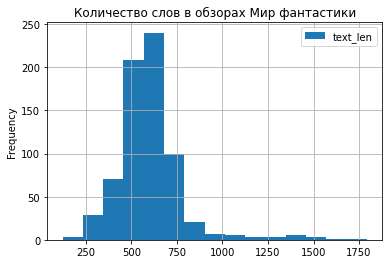

In [80]:

df2.plot(kind='hist', y='text_len', 
         bins=15, grid=True, legend=True, 
         title = "Количество слов в обзорах Мир фантастики" )


<AxesSubplot:title={'center':'Распределени количества обзоров Мир Фантастики по годам'}, ylabel='Frequency'>

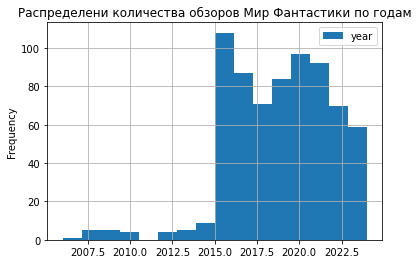

In [81]:
df2.plot(kind='hist', y='year', 
         bins=16, grid=True, legend=True, 
         title = "Распределени количества обзоров Мир Фантастики по годам" )


<AxesSubplot:title={'center':'Распределени количества просмотров обзоров Мир Фантастики'}, ylabel='Frequency'>

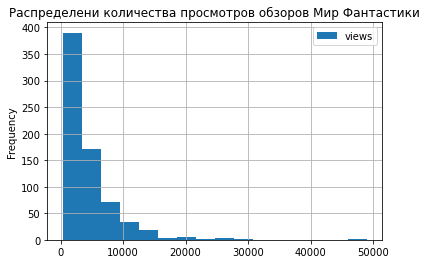

In [84]:
df2.plot(kind='hist', y='views', 
         bins=16, grid=True, legend=True, 
         title = "Распределени количества просмотров обзоров Мир Фантастики" )

In [85]:
df2[df2['views'] >= 20000]

url              author  \
17   https://www.mirf.ru/book/sergej-lukyanenko-for...        Лилия Чужова   
34   https://www.mirf.ru/book/ernest-klajn-vtoromu-...      Елена Щетинина   
84   https://www.mirf.ru/book/yacek-komuda-bes-idyo...      Елена Щетинина   
361  https://www.mirf.ru/book/sergej-lukyanenko-porog/       Борис Невский   
387  https://www.mirf.ru/book/aleksej-ivanov-pische...       Ирина Нечаева   
395  https://www.mirf.ru/book/dzhordzh-martin-plamy...  Дмитрий Злотницкий   
406  https://www.mirf.ru/book/filip-riv-smertnye-ma...       Юрий Перебаев   
593  https://www.mirf.ru/book/garri-potter-i-prokly...    Валентина Ингсоц   
610  https://www.mirf.ru/book/bookreview/lev-grossm...       Жанна Галиева   

     publ_date                                              title  \
17  2023-11-18  Сергей Лукьяненко «Форсайт». Воспоминания о пе...   
34  2023-07-21  Эрнест Клайн «Второму игроку приготовиться». В...   
84  2022-08-23  Яцек Комуда «Бес идёт за мной». Путешествие по...   
361 2019-06-13  Сергей Лукьяненко «Порог»: фантастика в духе «...   
387 2019-02-21  Алексей Иванов «Пищеблок»: пионерские ужасы дл...   
395 2019-02-02       Джордж Мартин «Пламя и кровь. Пляска смерти»   
406 2018-12-06  Филип Рив «Смертные машины»: книга, по которой...   
593 2016-08-11  «Гарри Поттер и проклятое дитя»: впечатления о...   
610 2016-05-14                          Лев Гроссман «Волшебники»   

                                           description  \
17    Однажды у 5% населения Земли начинаются стран...   
34    Удивительное технологическое достижение, кото...   
84    В вихре кровавой войны кочевникам-хунгурам уд...   
361   XXIII столетие. В экспедицию к системе Невар,...   
387   1980 год. В Москве начинается Олимпиада, а по...   
395   Завещав свой трон старшей дочери, Визерис I Т...   
406   Очень далёкое будущее. После разрушительной в...   
593  Вышедшая 31 июля новая книга о Гарри Поттере (...   
610  Квентин Колдуотер, суперотличник из Бруклина, ...   

                                                  text  views  year  \
17    Поскольку «Форсайт» это всё-таки сборник, ане...  25795  2023   
34    Эрнест Клайн неоднократно рассказывал винтерв...  22172  2023   
84    Роман «Бес идёт за мной» ни в коем случае нел...  20223  2022   
361   Спустя довольно длительное время Сергей Лукья...  29238  2019   
387   Алексей Иванов, писатель масштабный, серьёзны...  20145  2019   
395  George R.R. Martin Fire &Blood Похоже на: Шэро...  25182  2019   
406   О фильме «Хроники хищных городов» — возможно,...  26893  2018   
593   «Гарри Поттер и Проклятое дитя» — это серьёзн...  49012  2016   
610   Очень жаль, что АСТ обратилось к трилогии Льв...  20625  2016   

    month_year                                              gener  score  \
17     2023-11    [научная / "твердая" фантастика / технофэнтези]      8   
34     2023-07  [подростковое фэнтези, научная / "твердая" фан...      7   
84     2022-08  [историческое фэнтези / альтернативная-история...      8   
361    2019-06  [космическая опера, научная / "твердая" фантас...      8   
387    2019-02                                           [хоррор]      0   
395    2019-02  [историческое фэнтези / альтернативная-история...      8   
406    2018-12  [подростковое фэнтези, социальная / "мягкая" ф...      7   
593    2016-08                                                 []      0   
610    2016-05                                                 []      8   

                                                  good  \
17   [оригинальный Лукьяненко, юмор, быстро ставшие...   
34   [квестовые задания и их решения, расширение ми...   
84   [высокий темп повествования, неоднозначный гла...   
361  [занимательный и многослойный сюжет , симпатич...   
387                                               None   
395  [эпический размах событий, обилие интересных д...   
406  [постапокалиптический мир движущихся городов ,...   
593                                               None   
610 

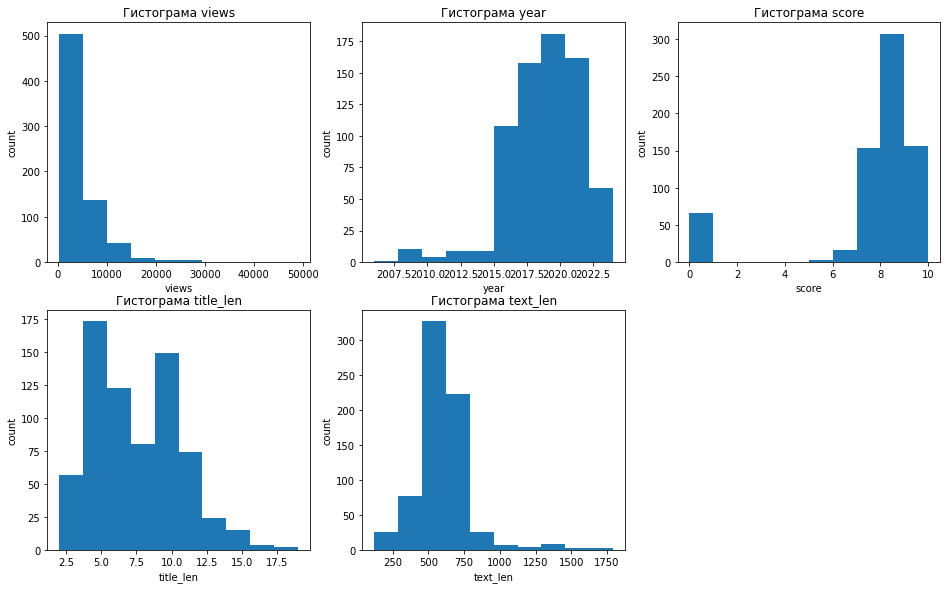

In [86]:
# гистограмы по int и flot
i = 1
plt.figure(figsize=(16,15))
for col_name in list(df2.columns):
    if((df2[col_name].dtypes=='int64' or df2[col_name].dtypes=='float64') and col_name != 'period[M]'):
        plt.subplot(3,3, i)
        plt.hist(df2[col_name], bins=10)
        plt.xlabel(col_name)
        plt.ylabel('count')
        plt.title(f"Гистограма {col_name}")
        i += 1
plt.show()

до 2014 г. обзоров мало. <br>
оценки книг в сторону завышения (оценок ниже 5 нет; 0 - пропуский). 10 бальная шкала излишня. <br>
Кол-во слов в обзоре - от 300 до 700. Есть выбросы (можно убрать; это могут быть обзоры на серию книг или ошибки парсинга) <br>
У большинства обзоров до 10.000 просмотров. Есть 9 обзоров с просмотрами 20.000 и более - это обзоры на "звездную фантастику" (С. Лукьяненко, Дж. Мартин, Дж. Роулинг)

<AxesSubplot:title={'center':'Количество обзоров на книги в Мир Фантастики по годам'}, xlabel='year', ylabel='text'>

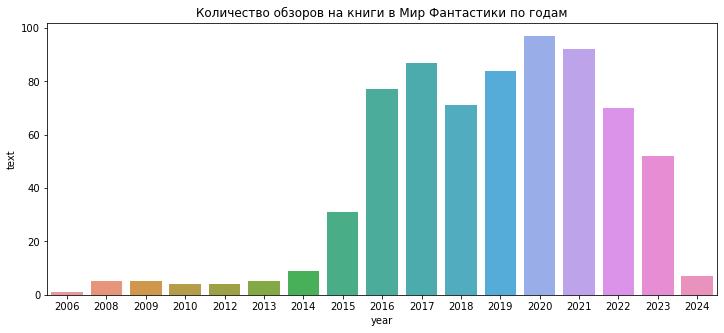

In [87]:
plt.figure(figsize=(12,5))
# plt.xticks(rotation=70)
plt.title("Количество обзоров на книги в Мир Фантастики по годам")
boxplot_data = df2.groupby(['year'], as_index=False).agg({'text': 'count'})
sns.barplot(
    x='year',
    y='text',
    data=boxplot_data)

До 2014 г. в Мир Фантастики выходило считанное количество обзоров на книги.<br><br>
Рост количетсва обзоров начался после 2014 и продолжался до 2020/21 г.

<AxesSubplot:title={'center':'Средние оценки обзоров на книги в Мир Фантастики по годам'}, xlabel='year', ylabel='score'>

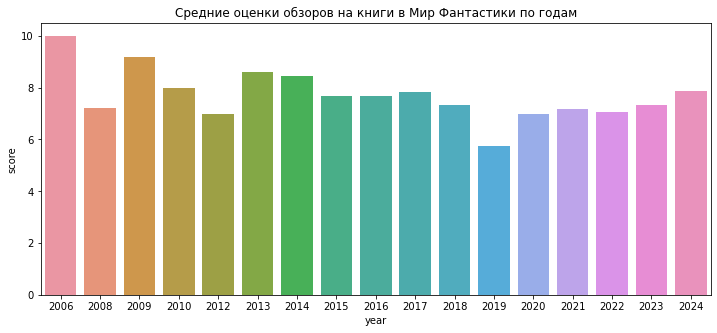

In [88]:
plt.figure(figsize=(12,5))
# plt.xticks(rotation=70)
plt.title("Средние оценки обзоров на книги в Мир Фантастики по годам")
boxplot_data = df2.groupby(['year'], as_index=False).agg({'score': 'mean'})
sns.barplot(
    x='year',
    y='score',
    data=boxplot_data)

<AxesSubplot:title={'center':'Средняя длинна обзоров в Мир Фантастики по годам '}, xlabel='year', ylabel='text_len'>

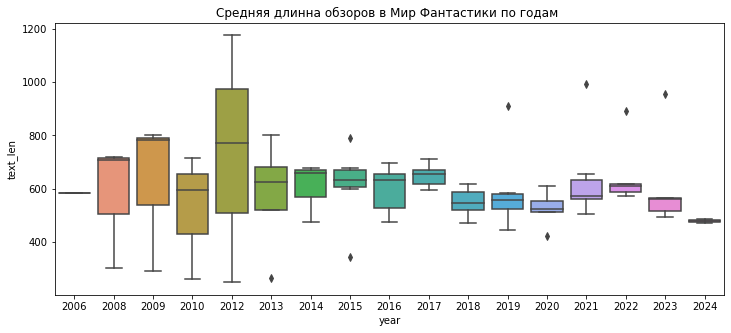

In [89]:
plt.figure(figsize=(12,5))
# plt.xticks(rotation=70)
plt.title("Средняя длинна обзоров в Мир Фантастики по годам ")
boxplot_data = df2.groupby(['score','year'], as_index=False).agg({'text_len': 'mean'})
sns.boxplot(
    x='year',
    y='text_len',
    data=boxplot_data)

"Расцвет" обзоров на книги в Мир Фантастики суди по их длинне и количеству пришелся на 2014 - 2017 гг. Затем хотя количество рецензий продолжило расти, их средняя длинна несколько сократилась. <br><br>
2012 г. - написано всего 4 рецензии (3 из которых аномально длинные и с высокими оценками).

In [142]:
df3.to_csv('/Users/user/My Python Stuff/NLP/mirf.csv')

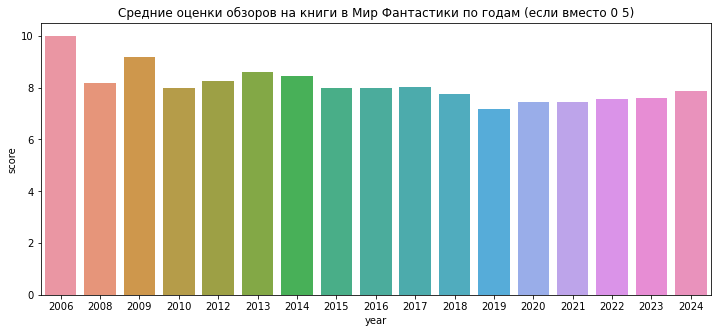

In [93]:
df3 = df2
# заменим 0 для nan на 5 в оценках это будет меньше смещать среднее погодам (плохих оценок ниже 5 все равно нет)
df3.loc[df3['score'] == 0, 'score'] = 5

plt.figure(figsize=(12,5))
# plt.xticks(rotation=70)
plt.title("Средние оценки обзоров на книги в Мир Фантастики по годам (если вместо 0 5)")
boxplot_data = df3.groupby(['year'], as_index=False).agg({'score': 'mean'})
sns.barplot(
    x='year',
    y='score',
    data=boxplot_data);

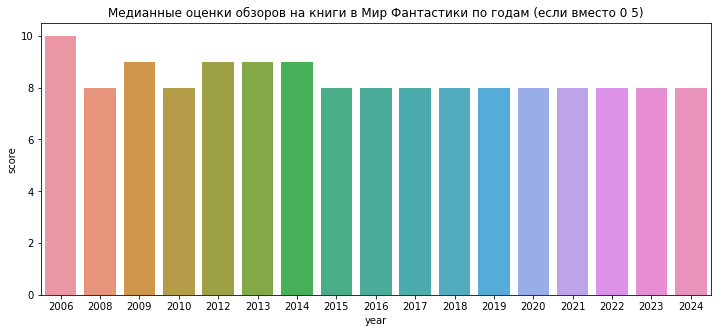

In [94]:
df3 = df2
# заменим 0 для nan на 5 в оценках это будет меньше смещать среднее погодам (плохих оценок ниже 5 все равно нет)
df3.loc[df3['score'] == 0, 'score'] = 5

plt.figure(figsize=(12,5))
# plt.xticks(rotation=70)
plt.title("Медианные оценки обзоров на книги в Мир Фантастики по годам (если вместо 0 5)")
boxplot_data = df3.groupby(['year'], as_index=False).agg({'score': 'median'})
sns.barplot(
    x='year',
    y='score',
    data=boxplot_data);

**И тут все четко: Мир Фантастики плохих оценок не ставит**

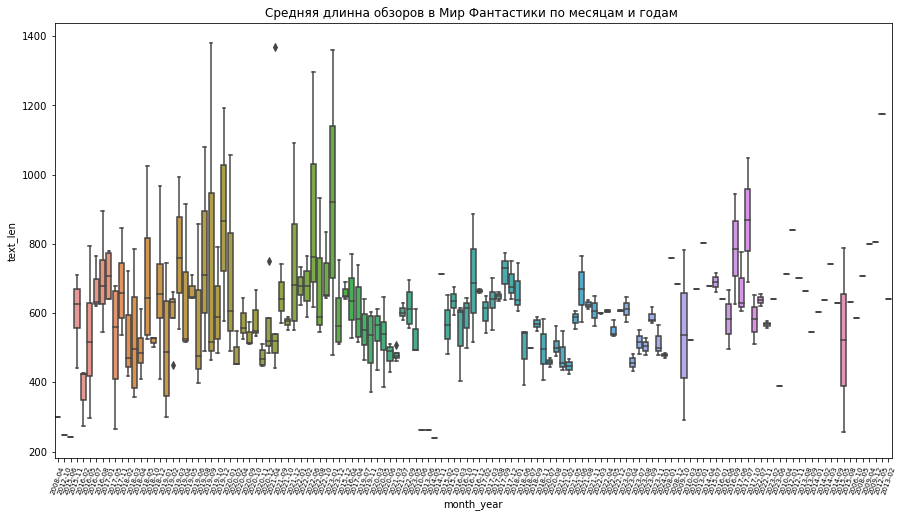

In [92]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=70)
plt.tick_params(axis='x', which='major', labelsize=7)
plt.title("Средняя длинна обзоров в Мир Фантастики по месяцам и годам ")
boxplot_data = df2.groupby(['score', 'month_year'], as_index=False).agg({'text_len': 'mean'})
sns.boxplot(
    x='month_year',
    y='text_len',
    data=boxplot_data);

На летние месяцы: 05, 06 приходятся особенно длинные отзывы. Весной длинна, как правило, растет, осенью сокращается - некоторая сезонность есть.

## Жанры-dummy

In [95]:
# посмотрим какое максимальное количество жанров может сочетать в себе одна книга
df3['len_gen'] = df3['gen_gen'].apply(lambda x: len(x))
print(df3['len_gen'].max(), 'может сочетать в себе одна книга')
print(df3.loc[df3['len_gen'] == 5, 'title'])

5 может сочетать в себе одна книга
364    Лев Гурский «Корвус Коракс»: фантастическая са...
Name: title, dtype: object


In [96]:
# сделаем df с dummy для жанров, который затем прикрепим (названия жанров в столбцы)
s = df2['gen_gen']
mlb = MultiLabelBinarizer()
gen_dum = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)

In [97]:
# прикрепили
df3 = df3.join(gen_dum)

In [98]:
# какие теперь есть столбцы
df3.columns

Index(['url', 'author', 'publ_date', 'title', 'description', 'text', 'views',
       'year', 'month_year', 'gener', 'score', 'good', 'bad', 'gen_gen',
       'title_len', 'text_len', 'len_gen', 'АИ-фэнтези', 'авантюрное фэнтези',
       'боевик', 'городское фэнтези', 'детектив',
       'историческое фэнтези / альтернативная-история / хронофантастика',
       'космическая опера', 'мистика', 'мифологическое фэнтези',
       'научная / "твердая" фантастика / технофэнтези', 'ориентальное фэнтези',
       'подростковое фэнтези', 'постапокалипсис / катастрофа',
       'псевдодокументалистика', 'путеводитель по вымышленной вселенной',
       'социальная / "мягкая" фантастика / антиутопия / постмодерн', 'триллер',
       'тёмное / готическое фэнтези / нуар', 'хоррор',
       'эпическое / приключенческое / героическое фэнтези',
       'юмористическое фэнтези'],
      dtype='object')

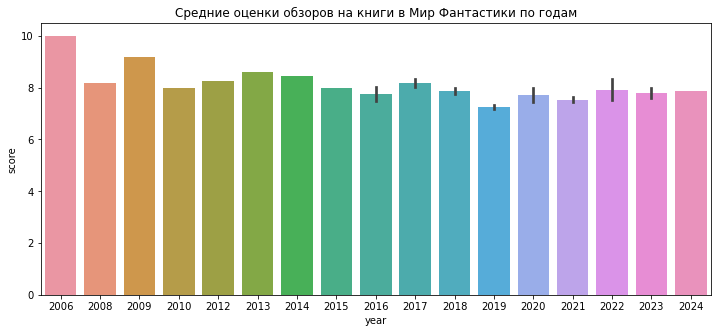

In [99]:
plt.figure(figsize=(12,5))
# plt.xticks(rotation=70)
plt.title("Средние оценки обзоров на книги в Мир Фантастики по годам")
boxplot_data = df3.groupby(['хоррор', 'year'], as_index=False).agg({'score': 'mean'})
sns.barplot(
    x='year',
    y='score',
    data=boxplot_data);

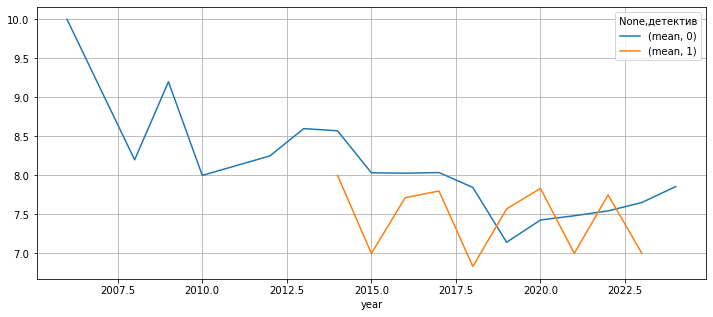

In [100]:
(
df3.pivot_table(index=['year'], columns=['детектив'], values='score', aggfunc=['mean'])
.plot(grid=True, figsize=(12, 5))
);



In [101]:
list(df3.columns)[-21:]

['АИ-фэнтези',
 'авантюрное фэнтези',
 'боевик',
 'городское фэнтези',
 'детектив',
 'историческое фэнтези / альтернативная-история / хронофантастика',
 'космическая опера',
 'мистика',
 'мифологическое фэнтези',
 'научная / "твердая" фантастика / технофэнтези',
 'ориентальное фэнтези',
 'подростковое фэнтези',
 'постапокалипсис / катастрофа',
 'псевдодокументалистика',
 'путеводитель по вымышленной вселенной',
 'социальная / "мягкая" фантастика / антиутопия / постмодерн',
 'триллер',
 'тёмное / готическое фэнтези / нуар',
 'хоррор',
 'эпическое / приключенческое / героическое фэнтези',
 'юмористическое фэнтези']

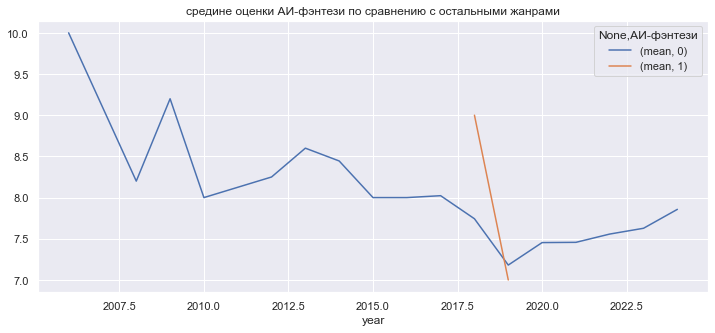

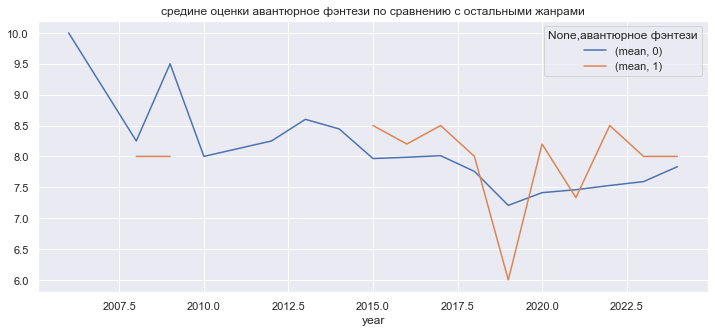

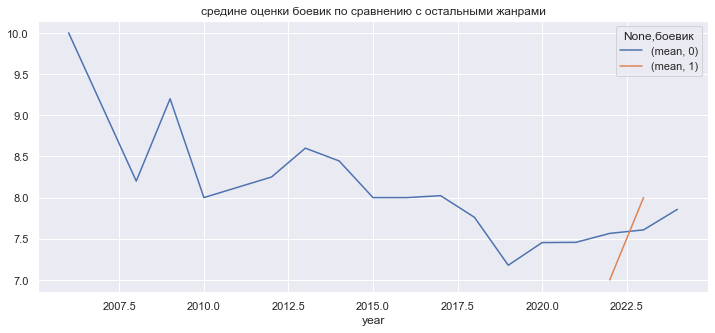

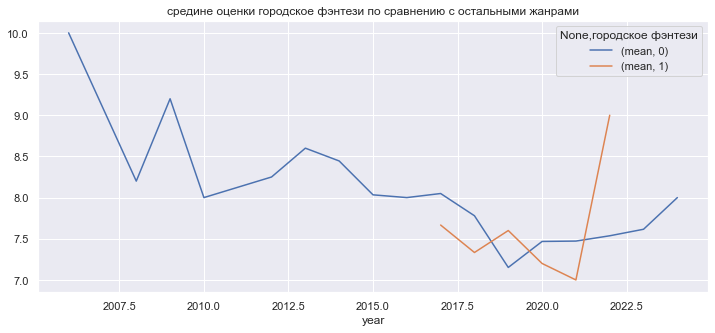

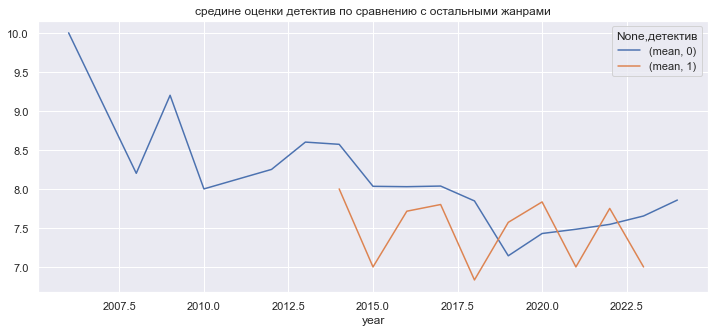

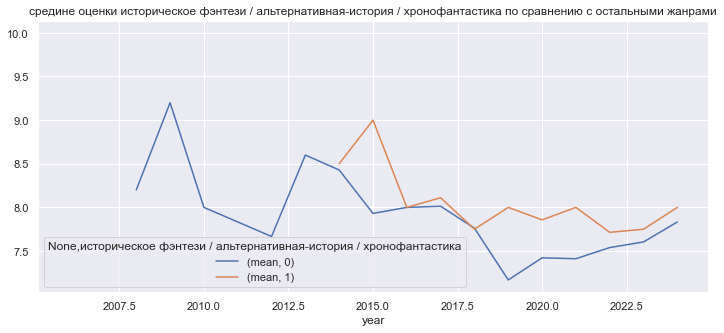

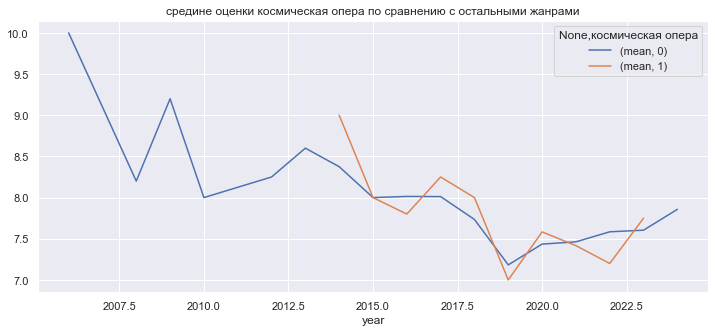

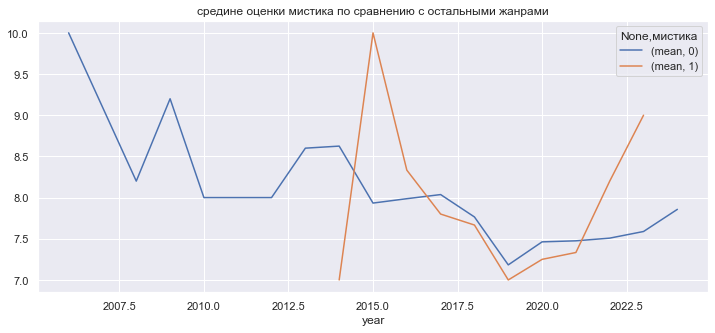

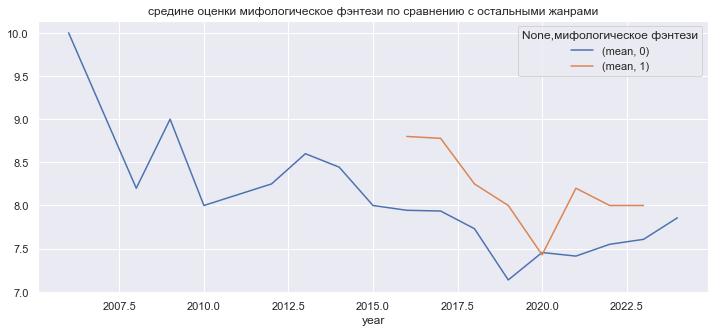

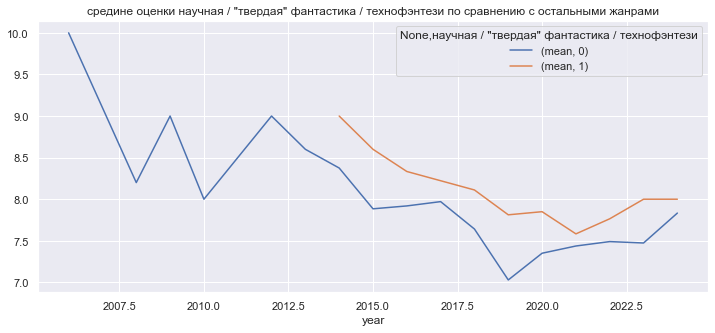

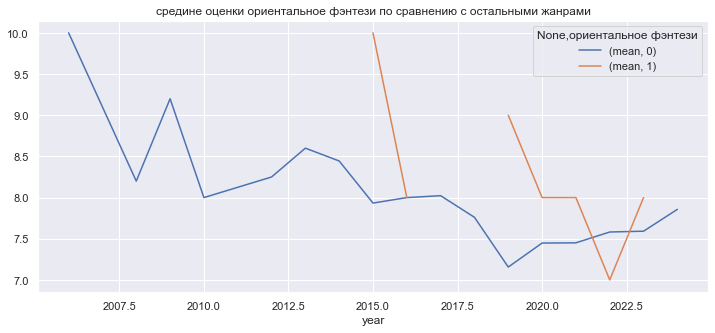

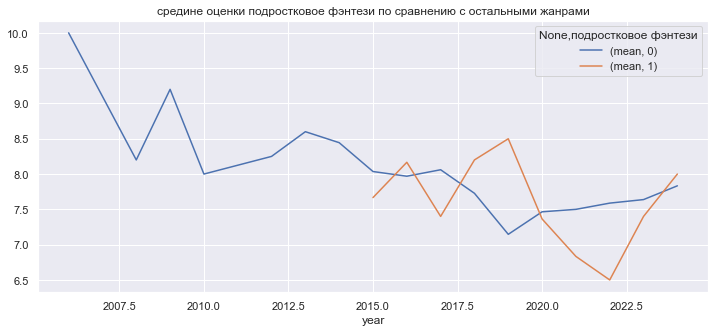

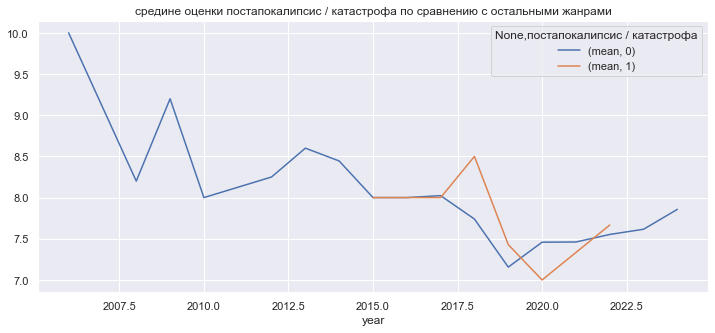

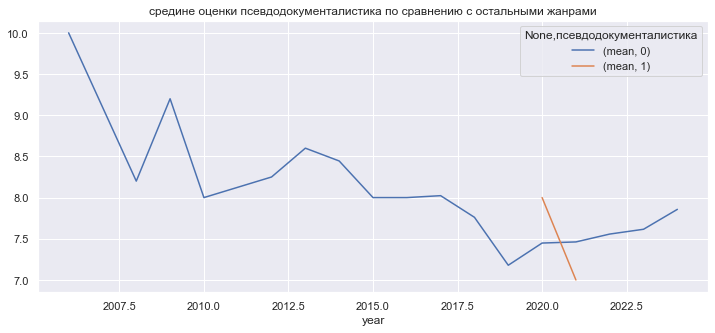

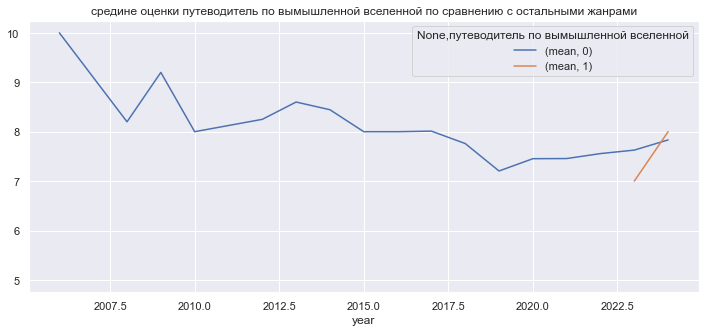

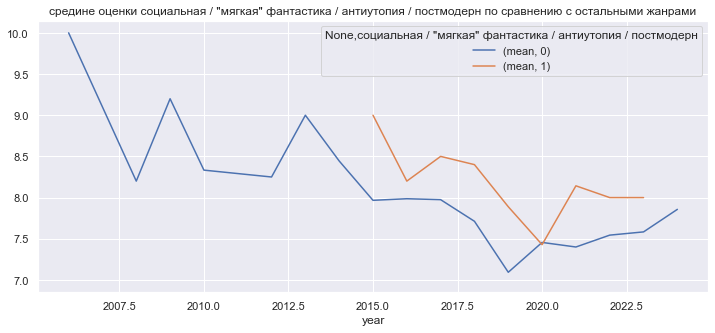

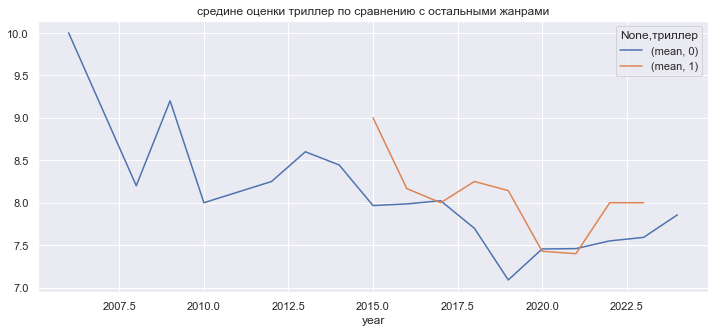

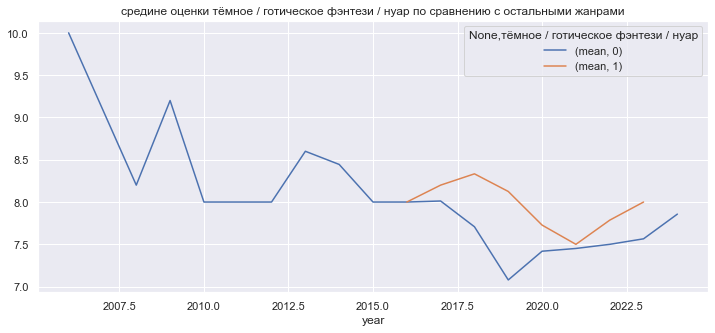

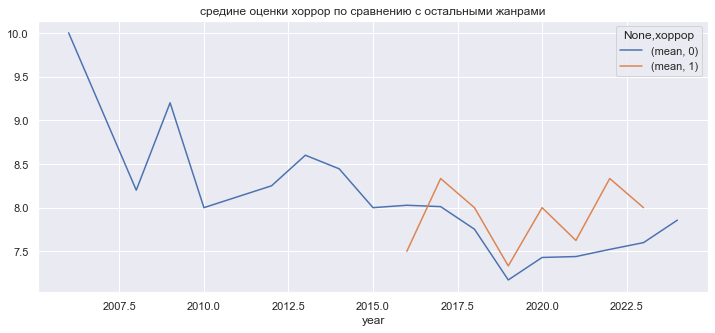

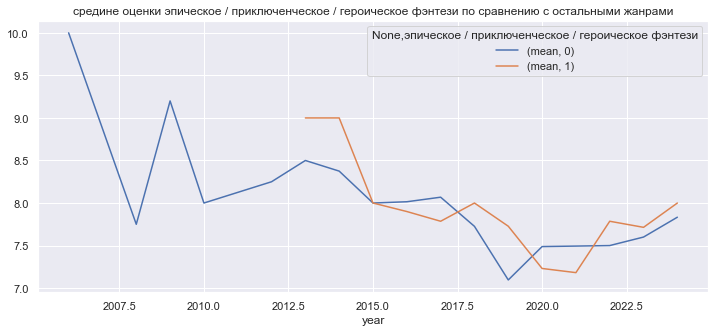

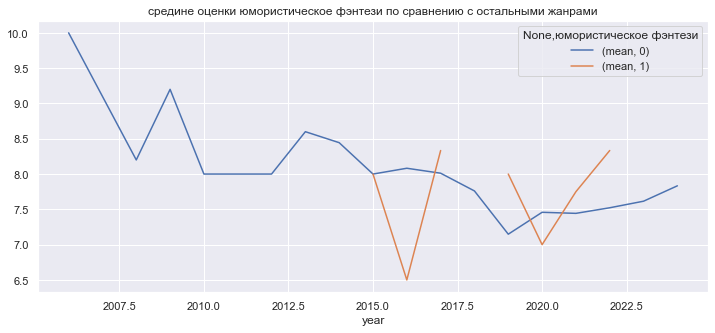

In [622]:
for gen_name in list(df3.columns)[-21:]:
    (
    df3.pivot_table(index=['year'], columns=gen_name, values='score', aggfunc=['mean'])
    .plot(grid=True, figsize=(12, 5), title=f'средине оценки {gen_name} по сравнению с остальными жанрами' )
    )

Средние суммарные оценки жанров 
- 'мифологическое фэнтези', 
- 'научная / "твердая" фантастика / технофэнтези', 
- 'историческое фэнтези / альтернативная-история / хронофантастика', 
- 'социальная / "мягкая" фантастика / антиутопия / постмодерн'
<br> как правило выше средних суммарных оценок остальныных жанров за все годы. Это самые **"популярные" жанры** судя по средним оценкам отзывов. <br><br> 

Средние суммарные оценки жанров 
- 'космическая опера', 
- 'эпическое / приключенческое / героическое фэнтези',
- 'постапокалипсис / катастрофа'
- 'авантюрное фэнтези' 
<br>мало отличаютс от средних суммарных оценок остальныных жанров за все годы. **"Средние жанры"** <br><br> 
После 2019/20/21 оценки 'подросткового фэнтези' сильно просели. Из "среднего" жанра в "непопулярное". <br><br>

После 2019/20/21 сильно выросли средние суммарные оценки жанров 
- 'хоррор', 
- 'темное', 
- 'мистика', 
- 'городское' 
<br> по сравнению с остальными - это **"перспективные жанры"**. У мистики уже был подобный пик по оценкам в 2015 г. (возможно перспективность ненадолго) <br><br>
**"Непопулярные" жанры** судя по средним оценкам отзывов - 'детектив' и 'подростковое'.

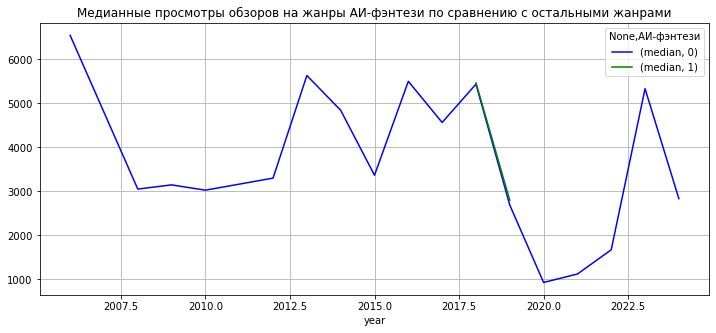

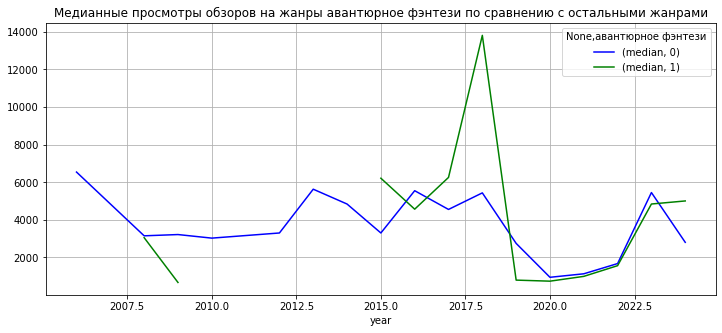

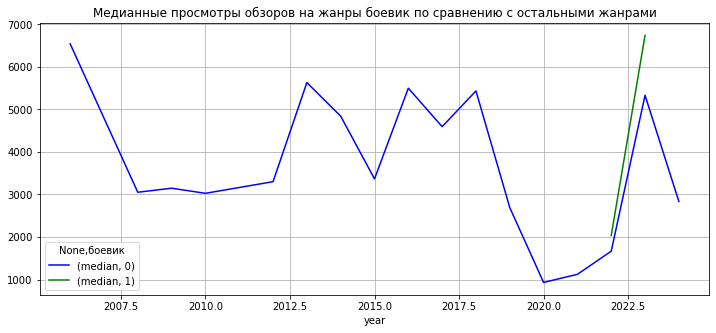

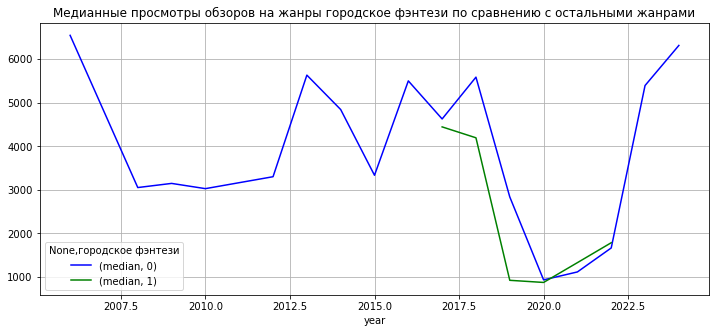

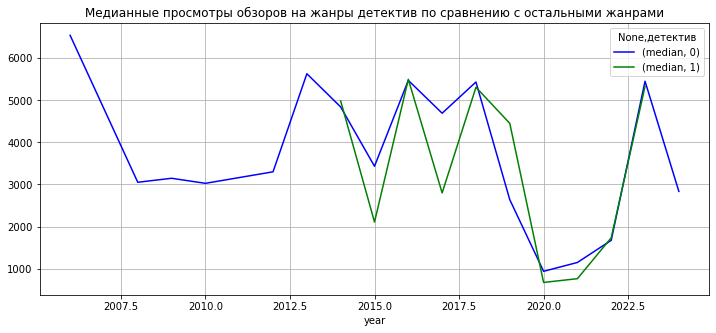

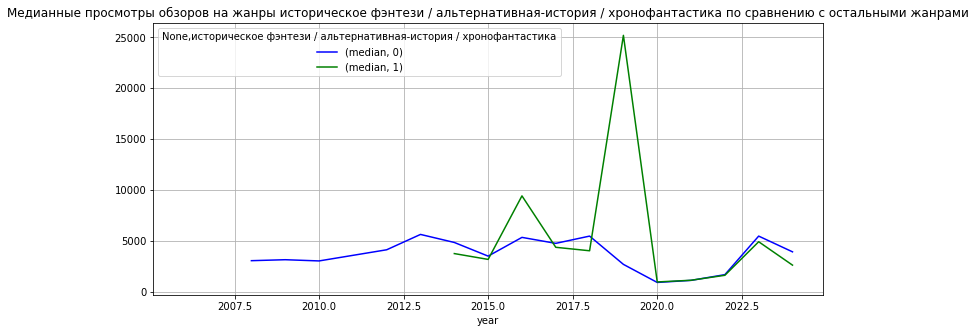

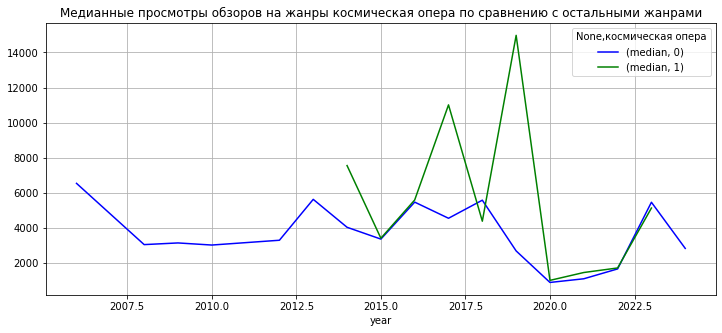

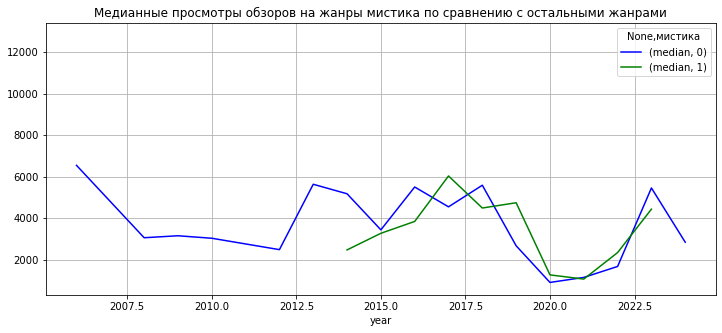

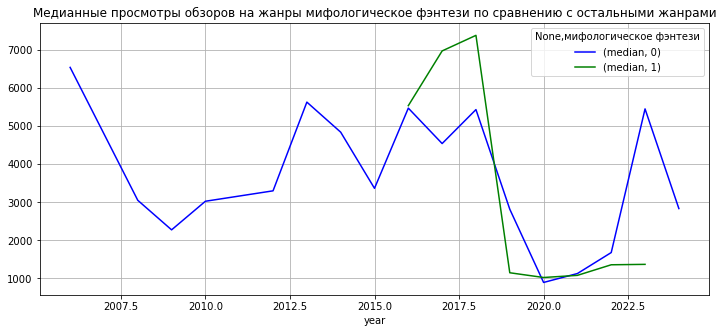

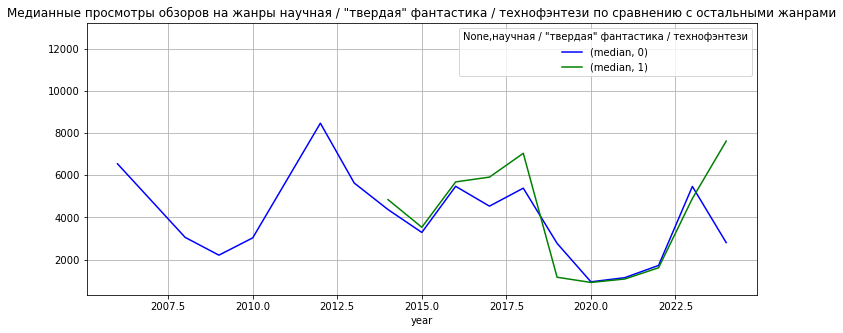

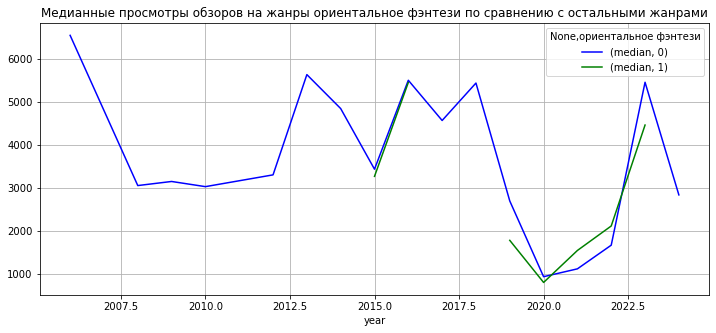

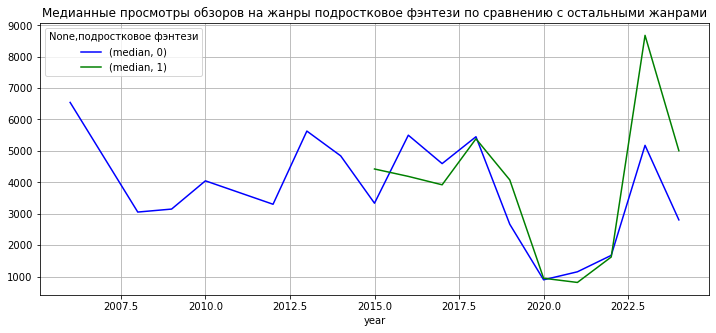

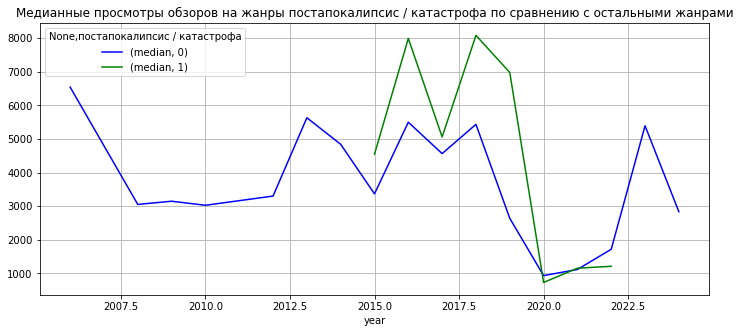

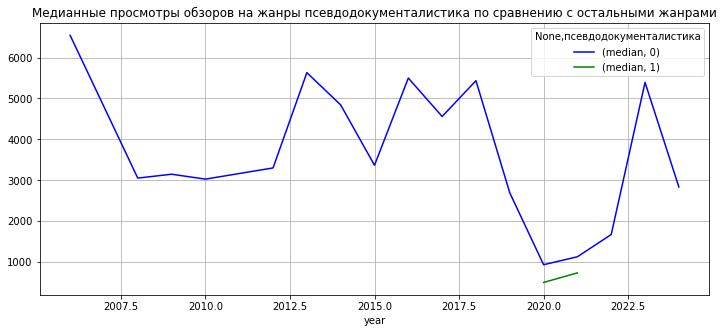

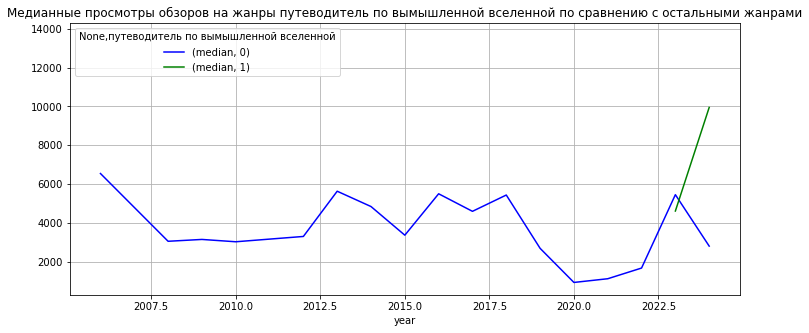

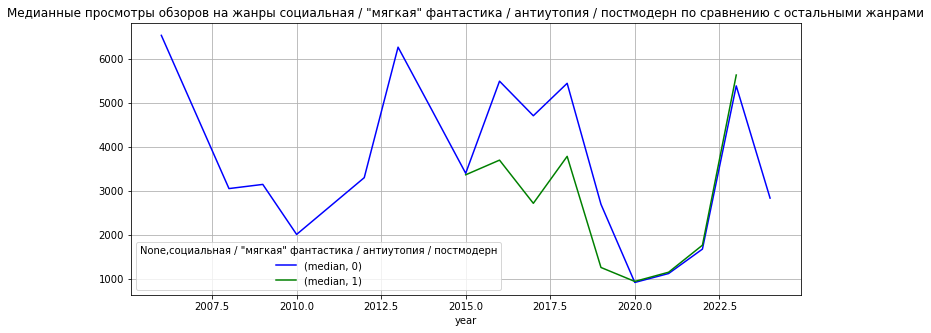

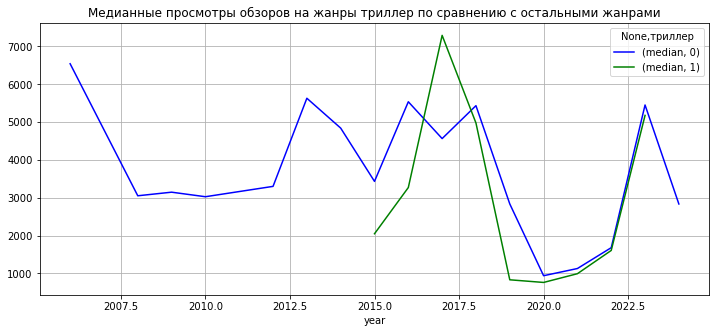

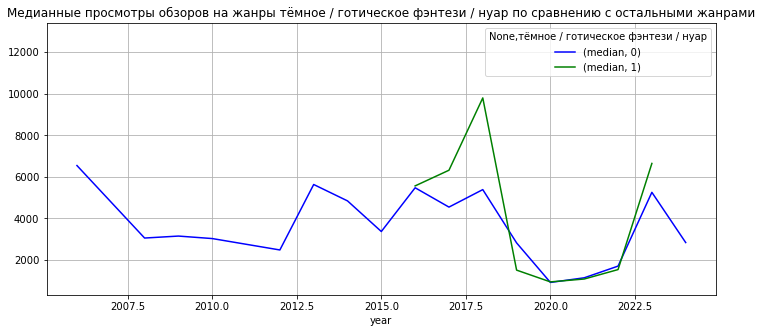

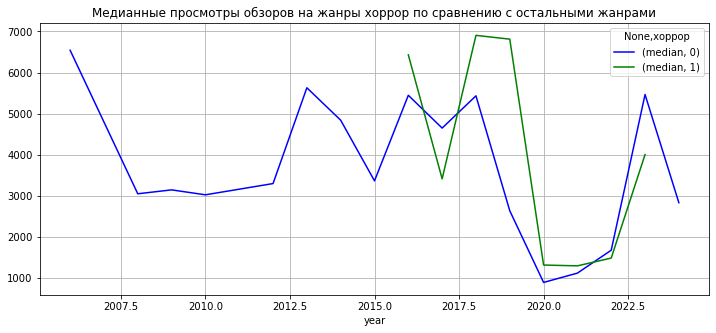

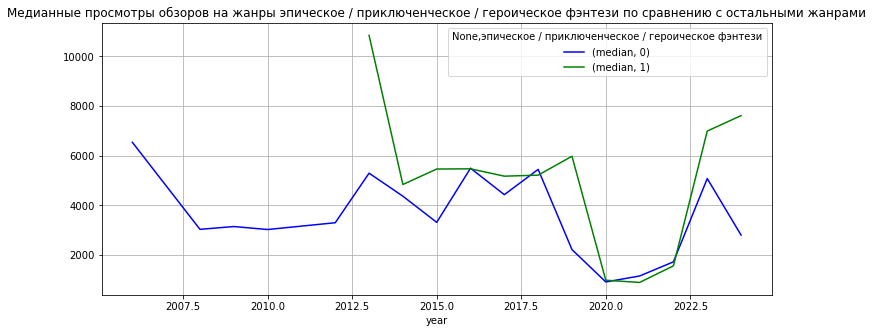

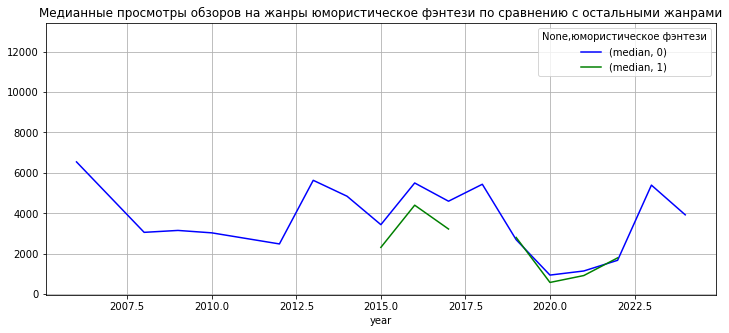

In [102]:
for gen_name in list(df3.columns)[-21:]:
    (
    df3.pivot_table(index=['year'], columns=gen_name, values='views', aggfunc=['median'])
    .plot(grid=True, figsize=(12, 5), color=['blue','green'], title=f'Медианные просмотры обзоров на жанры {gen_name} по сравнению с остальными жанрами' )
    )

Медианные суммарные (чтобы убрать влияние сверхпопулярных, ult views >= 20.000) просмотры отзывов на жанры не подтверждают картину по оценкам авторов отзывов книг жанра. <br><br>
в 2018/19 выстрелили Медианные суммарные просмотры:
- авантюрного (сред. по оц)
- космооперы (сред. по оц)
- хоррора (персп. по оц)
- постапокалипсиса (сред. по оц)
- исторического (популяр по оц)
- триллера
<br><br>
в 2023 выстрелили Медианные суммарные просмотры:
- эпическое (сред. по оц)
- подростковое (из сред в не-попул по оц)

In [103]:
#сделали словарья для groupby / pivot
# 13 самых распространенных жанров : суммировать
gen_list = [tup[0] for tup in Counter(gener).most_common(13)]
sum_list = ['sum']*len(gen_list)
dum_dic = dict(zip(gen_list, sum_list))
print(dum_dic)

{'научная / "твердая" фантастика / технофэнтези': 'sum', 'эпическое / приключенческое / героическое фэнтези': 'sum', 'тёмное / готическое фэнтези / нуар': 'sum', 'космическая опера': 'sum', 'историческое фэнтези / альтернативная-история / хронофантастика': 'sum', 'подростковое фэнтези': 'sum', 'социальная / "мягкая" фантастика / антиутопия / постмодерн': 'sum', 'детектив': 'sum', 'триллер': 'sum', 'мистика': 'sum', 'мифологическое фэнтези': 'sum', 'хоррор': 'sum', 'авантюрное фэнтези': 'sum'}


## TOP

In [104]:
# сделаем df top 10 авторов
top = df3.query('author in @top_10')

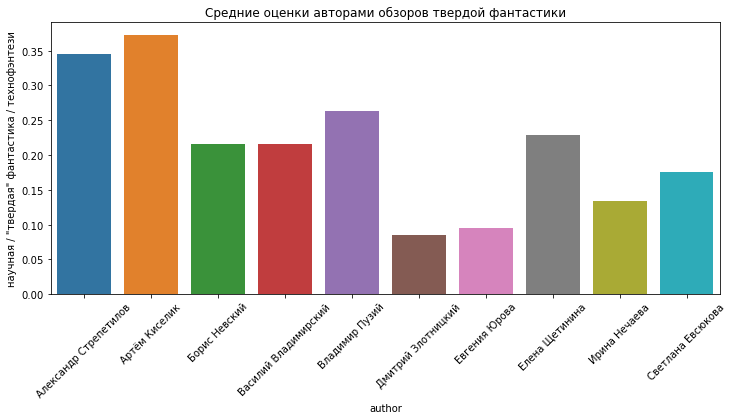

In [105]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.title("Средние оценки авторами обзоров твердой фантастики")
boxplot_data = top.groupby(['author'], as_index=False).agg({'научная / "твердая" фантастика / технофэнтези': 'mean'})
sns.barplot(
    x='author',
    y='научная / "твердая" фантастика / технофэнтези',
    data=boxplot_data);

In [106]:
xplot_data = top.groupby(['author'], as_index=False).agg(dum_dic)
xplot_data

author  научная / "твердая" фантастика / технофэнтези  \
0  Александр Стрепетилов                                             10   
1          Артём Киселик                                             16   
2          Борис Невский                                             19   
3   Василий Владимирский                                              8   
4         Владимир Пузий                                              5   
5     Дмитрий Злотницкий                                              6   
6          Евгения Юрова                                              2   
7         Елена Щетинина                                              8   
8          Ирина Нечаева                                              8   
9      Светлана Евсюкова                                             21   

   эпическое / приключенческое / героическое фэнтези  \
0                                                  7   
1                                                  2   
2                                                 15   
3                                                  1   
4                                                  1   
5                                                 27   
6                                                  3   
7                                                  6   
8                                                  2   
9                                                 11   

   тёмное / готическое фэнтези / нуар  космическая опера  \
0                                   3                  9   
1                                   4                  3   
2                                  11                  5   
3                                   2                  2   
4                                   0                  1   
5                                   3                  7   
6                                   4                  3   
7                                   9                  3   
8                                   8                  1   
9                                  11                  9   

   историческое фэнтези / альтернативная-история / хронофантастика  \
0                                                  0                 
1                                                  2                 
2                                                  6                 
3                                                  4                 
4                                                  2                 
5                                                  6                 
6                                                  2                 
7                                                  6                 
8                                                  5                 
9                                                 12                 

   подростковое фэнтези  \
0                     0   
1                     0   
2                    15   
3                     2   
4                     0   
5                     0   
6                     8   
7                     2   
8                     2   
9                     2   

   социальная / "мягкая" фантастика / антиутопия / постмодерн  детектив  \
0                                                  2                  1   
1                                                  6                  1   
2                                                  3                 12   
3                                                  6                  3   
4                                                  0                  0   
5                                                  0                  2   
6                                                  0                  0   
7                                                  3                  0   
8                                                  7                  2   
9                                                  8                 12   

   триллер  мистика

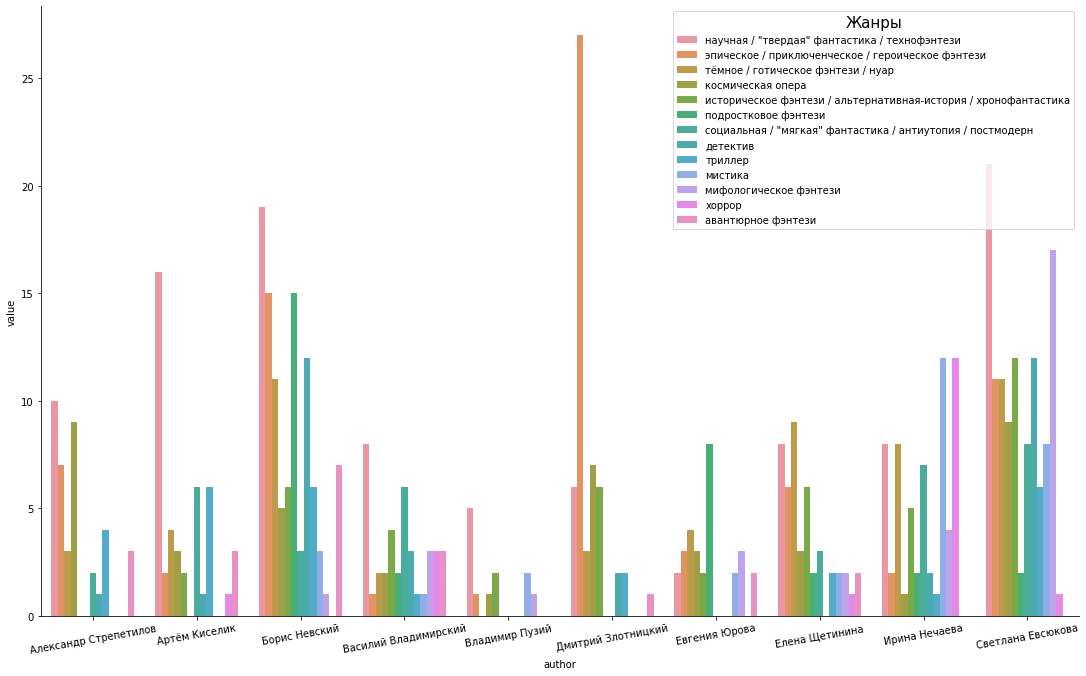

In [107]:
xplot_data = top.groupby(['author'], as_index=False).agg(dum_dic)
# plt.figure(figsize=(15,8))
# plt.xticks(rotation=70)
# plt.tick_params(axis='x', which='major', labelsize=10)
plot = sns.catplot(data=xplot_data.melt('author'),
            kind='bar',
            x= 'author',
            y='value',
            hue='variable',
            legend_out= False,
            height=9, 
            aspect=15/9)
plt.setp(plt.xticks(rotation=10))
plt.legend(title="Жанры", fontsize=10, title_fontsize=15);


Специализация авторов обзоров: <br><br>
Светлана Евсюкова и Борис Невский написали больше всех обзоров на всевозможные жанры. Оба предпочитают твердую научную и техно-фантастику, детективы и темную фантастику. 
- Борис Невский скорее по эпическому, авантюрному и подростковому фентези. 
- Светлана Евсюкова - по **мифологическому и историческому**.
- Александр Стрепетилов - по **космооперам и научной фантастике**.
- Дмитрий Злотницкий - по **эпическому / приключенческому / героическому фэнтези**.
- Ирина Нечаева - по **мистике и хоррорам**.
- Елена Щетинина - по **темному, готическому фентези**.
- Евгения Юрова - по **подростковому**.
- Артем Киселик - по научной фантастике.

<Figure size 1152x1080 with 0 Axes>

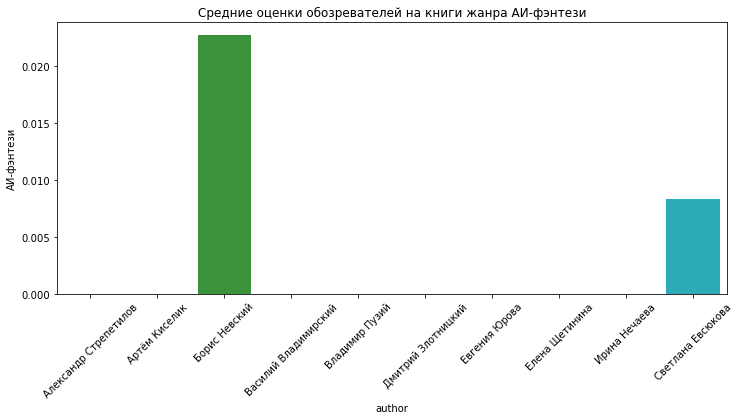

<Figure size 1152x1080 with 0 Axes>

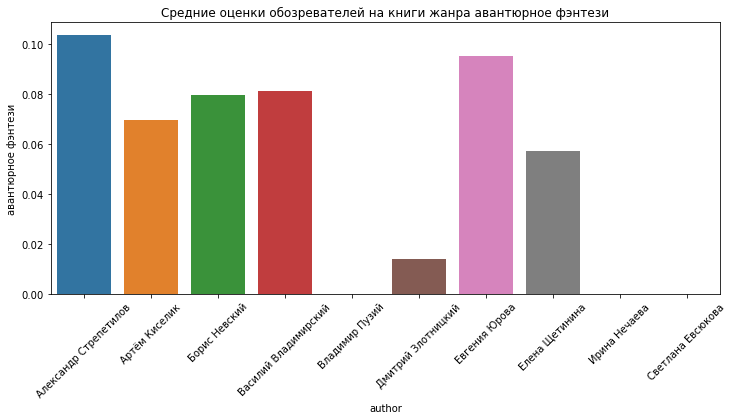

<Figure size 1152x1080 with 0 Axes>

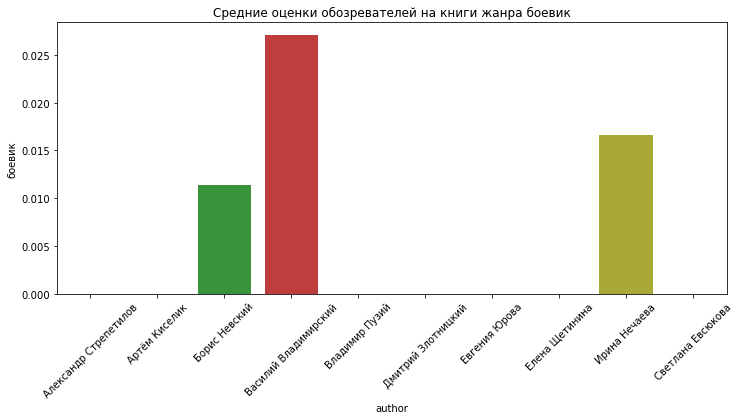

<Figure size 1152x1080 with 0 Axes>

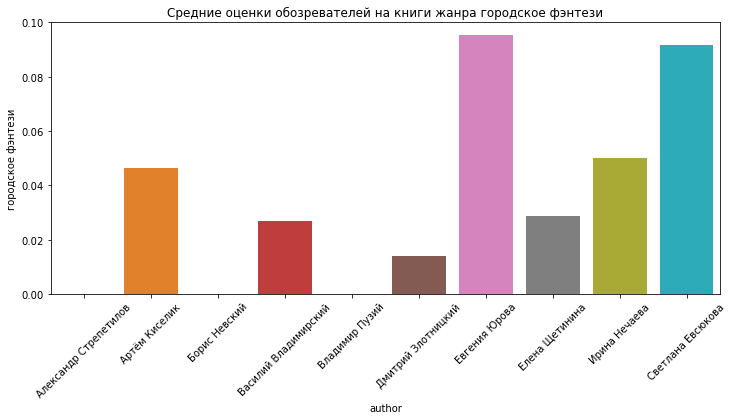

<Figure size 1152x1080 with 0 Axes>

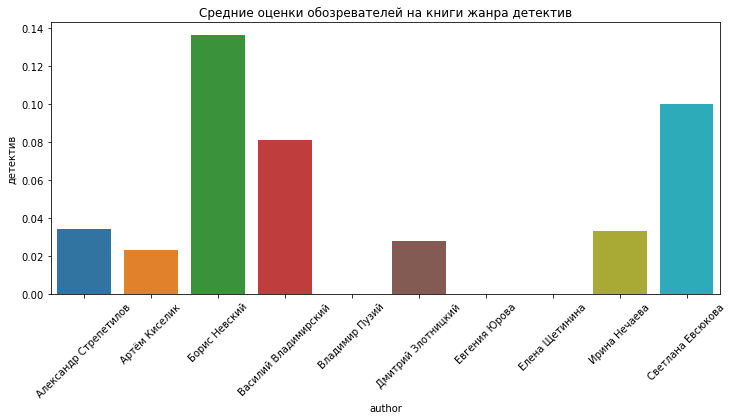

<Figure size 1152x1080 with 0 Axes>

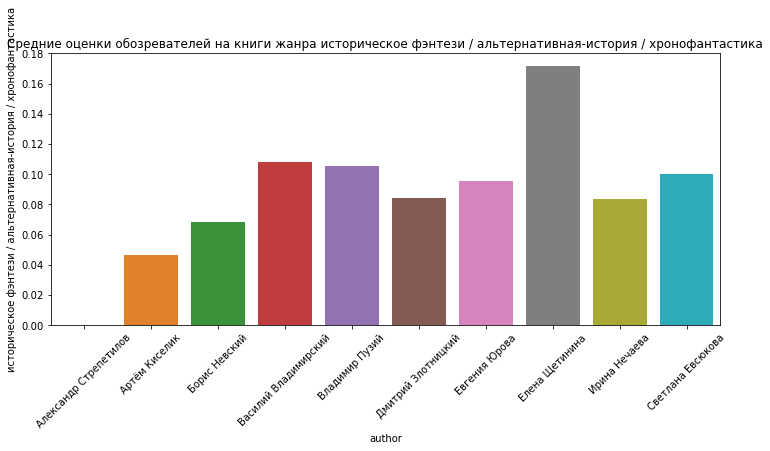

<Figure size 1152x1080 with 0 Axes>

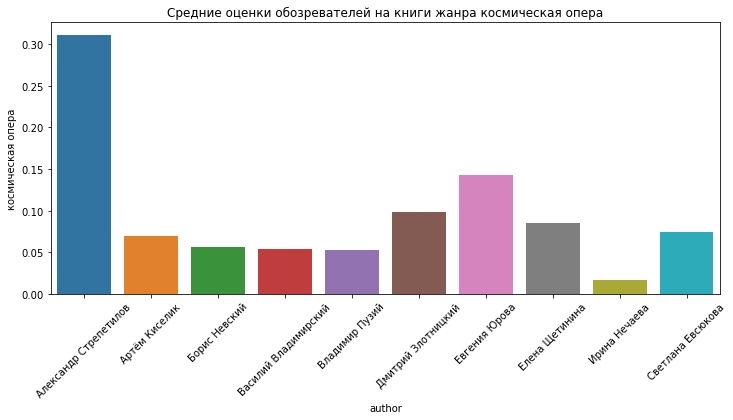

<Figure size 1152x1080 with 0 Axes>

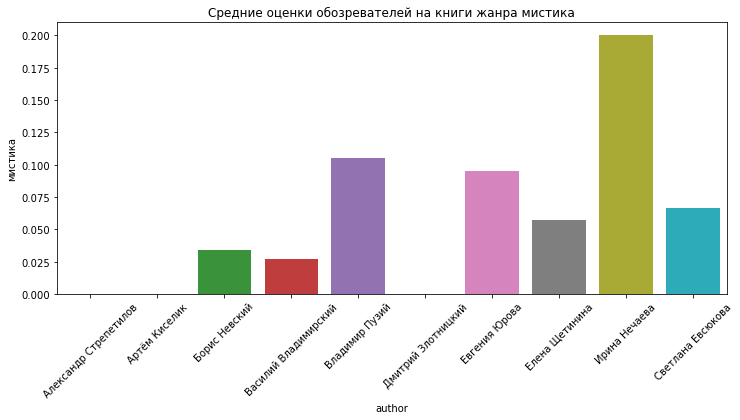

<Figure size 1152x1080 with 0 Axes>

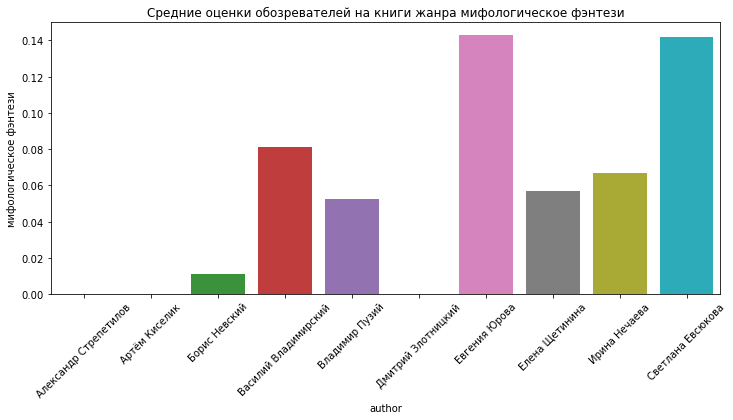

<Figure size 1152x1080 with 0 Axes>

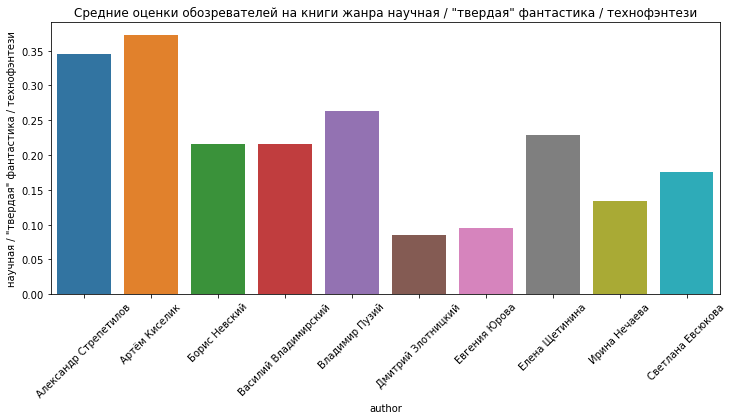

<Figure size 1152x1080 with 0 Axes>

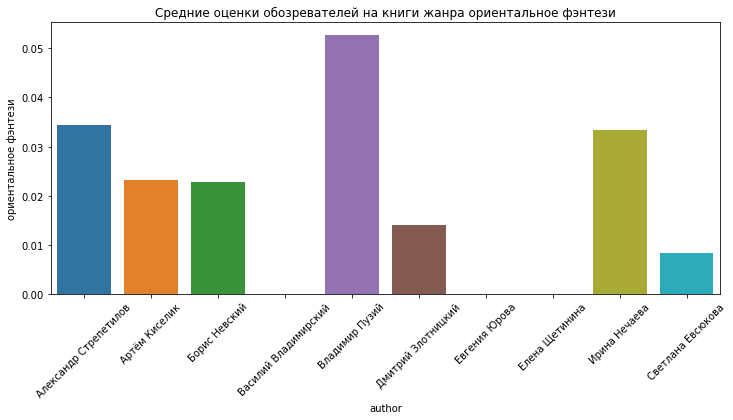

<Figure size 1152x1080 with 0 Axes>

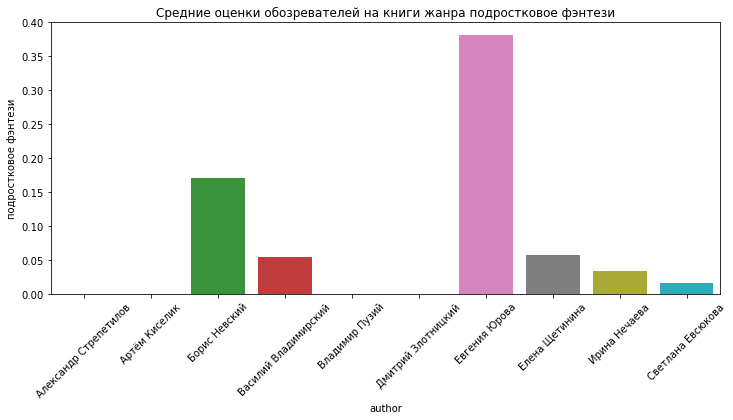

<Figure size 1152x1080 with 0 Axes>

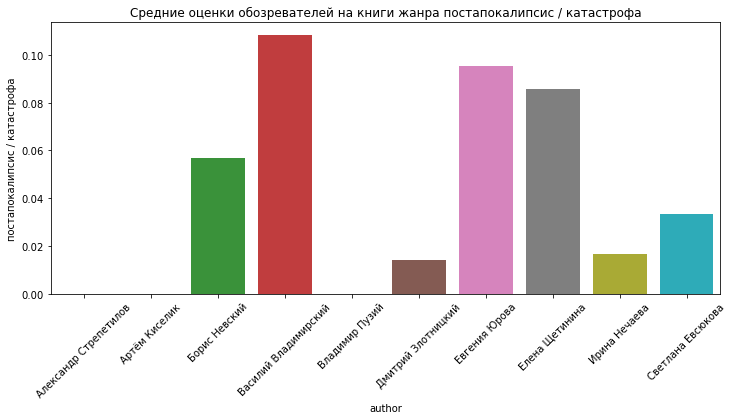

<Figure size 1152x1080 with 0 Axes>

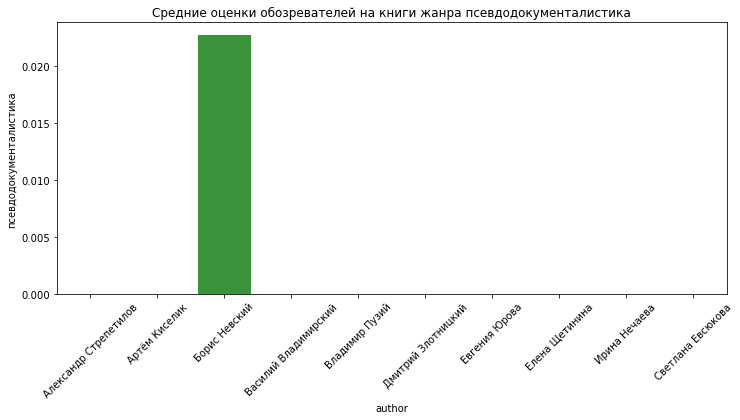

<Figure size 1152x1080 with 0 Axes>

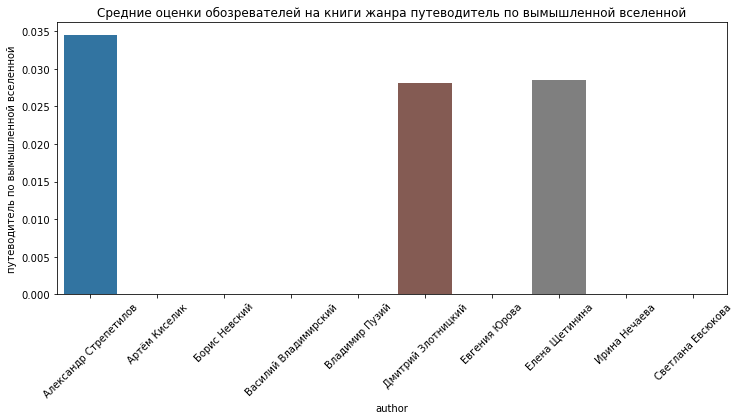

<Figure size 1152x1080 with 0 Axes>

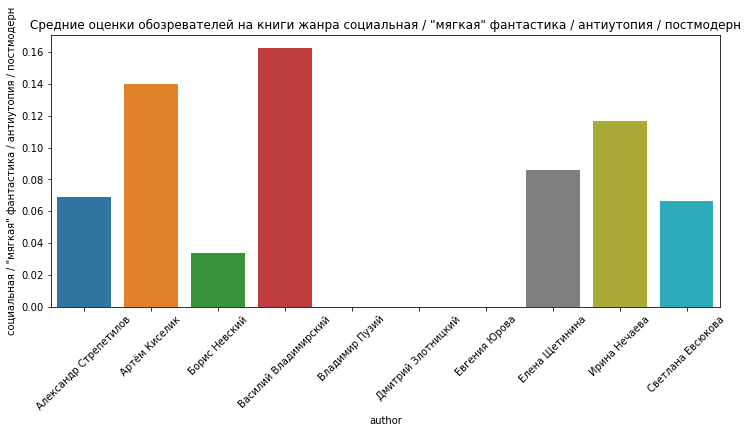

<Figure size 1152x1080 with 0 Axes>

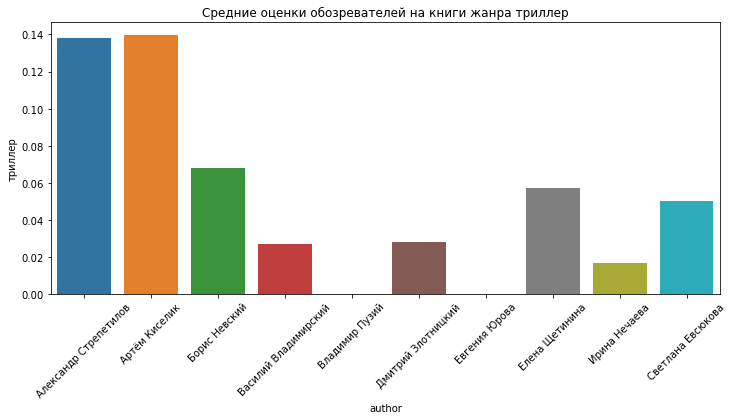

<Figure size 1152x1080 with 0 Axes>

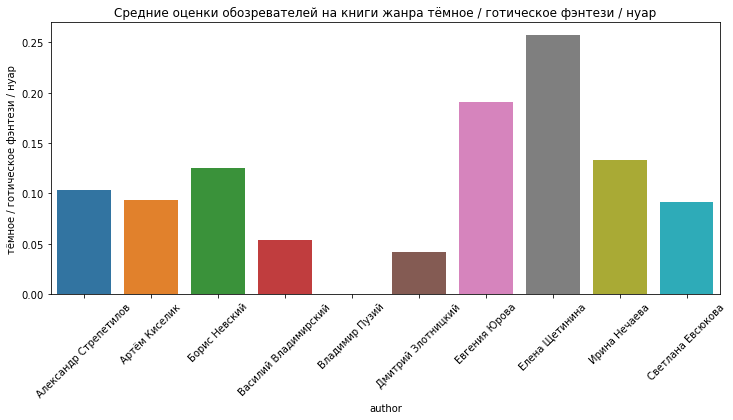

<Figure size 1152x1080 with 0 Axes>

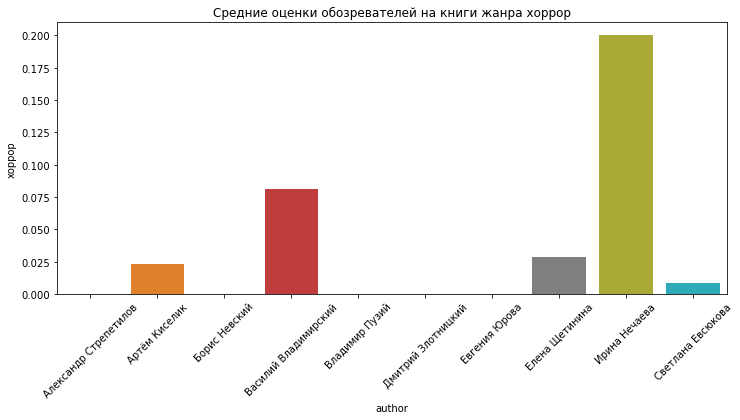

<Figure size 1152x1080 with 0 Axes>

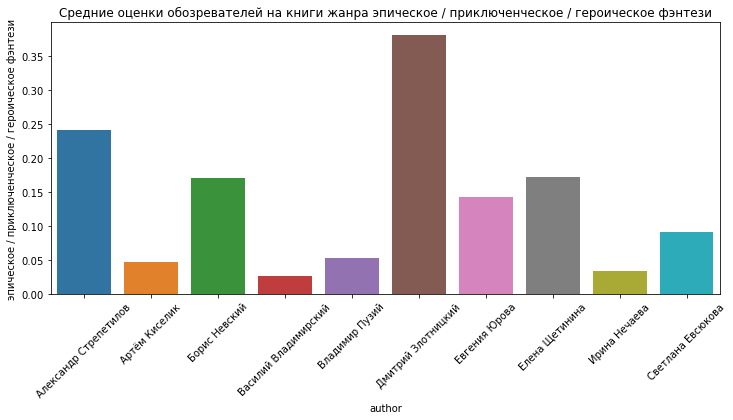

<Figure size 1152x1080 with 0 Axes>

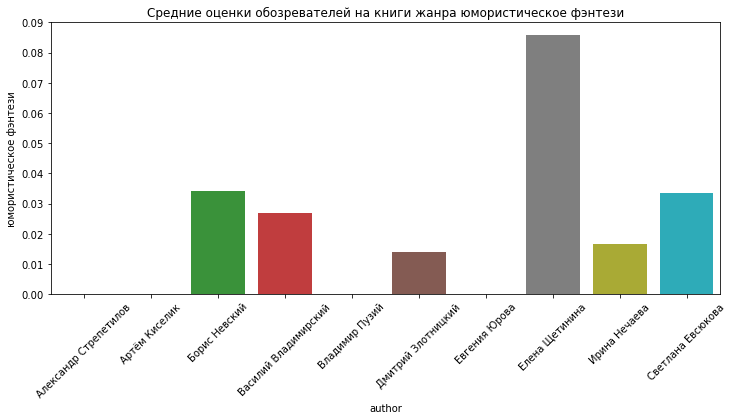

In [110]:
#

for col_name in list(top.columns[-21:]):
    plt.figure(figsize=(16,15))
    plt.figure(figsize=(12,5))
    plt.xticks(rotation=45)
    plt.tick_params(axis='x', which='major', labelsize=10)
    plt.title(f"Средние оценки обозревателей на книги жанра {col_name}")
    boxplot_data = top.groupby(['author'], as_index=False).agg({f'{col_name}': 'mean'})
    sns.barplot(
    x='author',
    y=f'{col_name}',
    data=boxplot_data)
    plt.show();
    


**У каких авторов предпочтение к жанру (большое количество обзоров книг жанра) совпадает с высокими средними оценками:** 
- Александр Стрепетилов пишет много обзоров по космооперам и в среднем высоко оценивает этот жанр (Светлана Евсюкова - много обзоров но не высокая оценка жанра).
- Ирина Нечаева - много обзоров по мистике и высокие оценки.
- Ирина Нечаева - много обзоров по хоррорам и высокие оценки.
- Дмитрий Злотницкий - много обзоров по по эпическому / приключенческому / героическому фэнтези и высокие оценки.
- Светлана Евсюкова - много обзоров по мифологии и достаточно высокая средняя оценка.
- Александр Стрепетилов и Артем Киселик в востоге от НФ и по количеству обзоров и по оценка (а вот Борис Невский и Светлана Евсюкова, который прочитали не меньше НФ уже не в таком восторге - умеренно положительные оценки); надо отметить, что мужская половина критиков (за исключением опытного Бориса Невского) более лояльна к НФ (надо проверить гипотезу о стат значимости различий в средних).
- Евгения Юрова в восторге от подросткового фентези (а вот Борис Невский, прочитавший не меньше его не в таком восторге - умеренно положительные оценки ).
- Елена Щетинина в восторге от темного фентези (а Борис Невский не в таком восторге); надо отметить, что женская половина критиков (за исключением опытной Светланы Евсюковой) более лояльна к темному фентези (надо проверить гипотезу о стат значимости различий в средних).
- Борис Невский несколько лояльнее к детективам, чем Светлана Евсюкова.<br><br>


**Если судить по средним оценкам:**<br>
Василий Владимирский лоялен к социальной фантастике/антиутопиям и боевикам.<br>
Елена Щетинина - темному, юмористическому и историческому.<br>
Светлана Евсюкова - мифологическому и городскому.<br>
<br><br>

**Вывод** Специализация (кол-во обзоров на фантастику данного жанра) и предпочтения (средние оценки данного) авторов обзоров выявлены. Иногда они совпадают. 

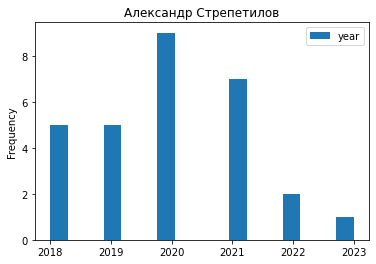

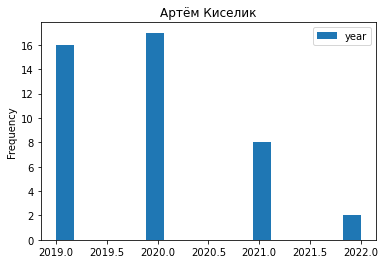

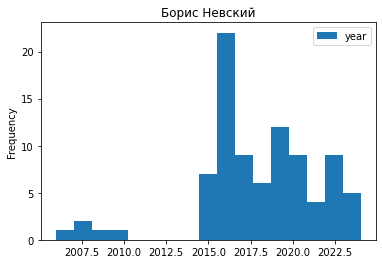

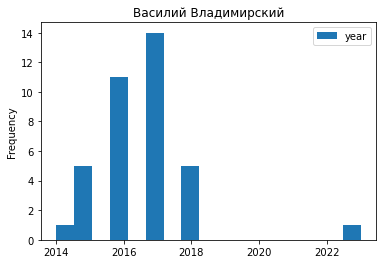

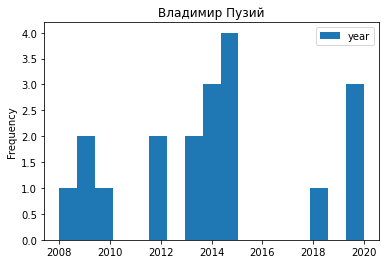

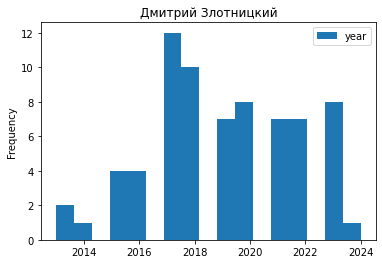

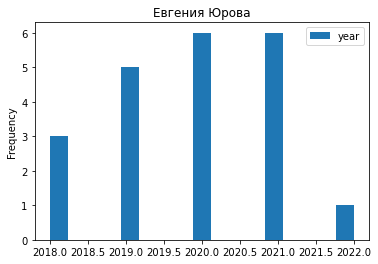

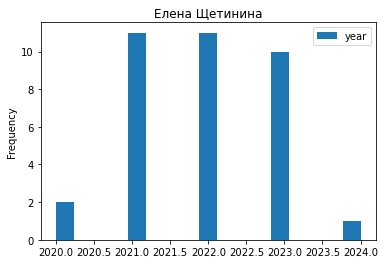

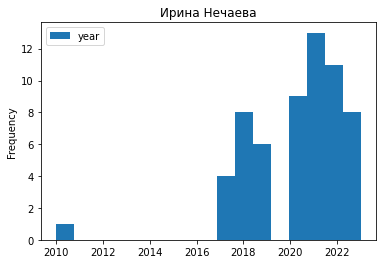

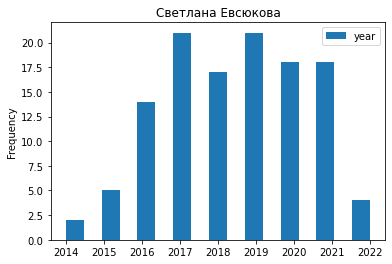

In [111]:
# посмотрим как регулярно авторы публиковались и когда начали
for author, group_df in top.groupby('author'):
    group_df.plot(kind='hist', y='year', bins=17, title=author);

Есть авторы, который пишут обзоры с 2014 и раньше (Борис Невский, Василий Владимирский, Владимир Пузий, Дмитрий Злотницкий, Ирина Нечаева, Светлана Евсюкова), есть те, который стали с 2018/19 (Александр Стрепетилов, Артём Киселик, Евгения Юрова, Елена Щетинина).
<br><br>
В среднем авторы пишут ок. 10 обзоров в год и меньше. Есть исключения для отдельных лет и авторов.

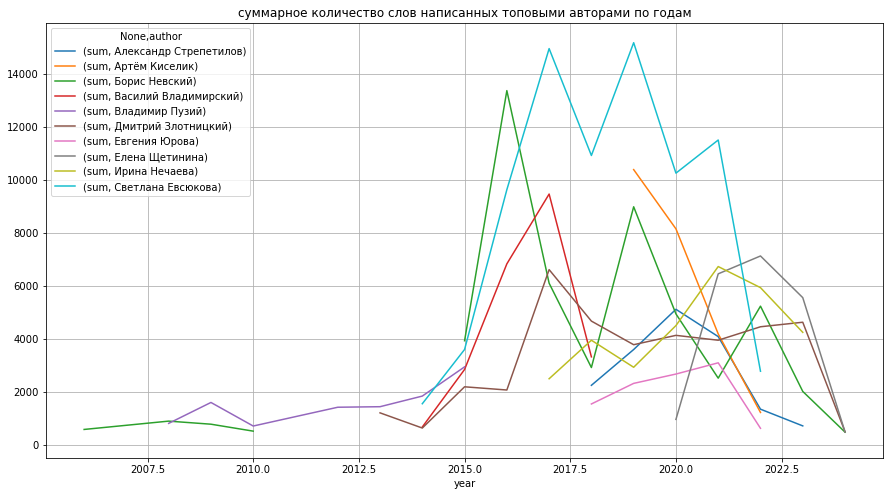

In [113]:
(
top.pivot_table(index=['year'], columns='author', values='text_len', aggfunc=['sum'])
.plot(grid=True, figsize=(15, 8), 
      title='суммарное количество слов написанных топовыми авторами по годам', 
      xlabel='year')
);

После 2016/17 авторы делать отзывы короче или писать меньше отзывов. <br>
Жизненный цикл автора (пока он пишет их ок. 10 в год или пиковое кл-во слов в год ) отзывов на фантастику ок 3-5 лет.

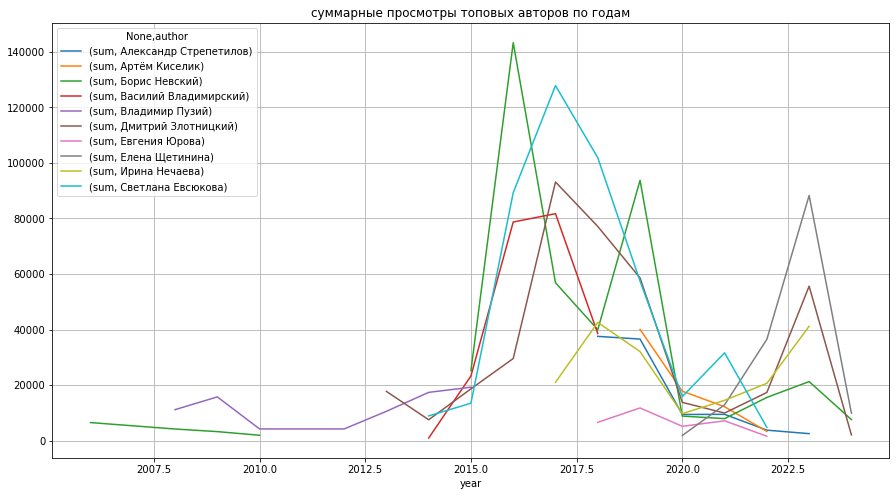

In [114]:
(
top.pivot_table(index=['year'], columns='author', values='views', aggfunc=['sum'])
.plot(grid=True, figsize=(15, 8), title='суммарные просмотры топовых авторов по годам')
);

до 2015 г. суммарные просмотры за год топовых авторов обзоров фантастики не превышали 20.000. (Как видно из общей статистики выше, достаточно было угадать бестселлер и написать на него обзор и просмотры такого обзора на бестселлер могли превысить суммарные просмотры в среднем 10 обзоров/год). В 2016/17 г. сум.просмотры за год взлетели, затем до 2020 падали. 2022/23 снова взлет.<br><br>

- 2016/17 г. взлет просмотров Бориса Невского, Светланы Евсюковой (НФ, техно-, детективы, темная, эпич и историч и мистика); в меньшей степени Василия Владимирского (соц/антиутоп) и  Дмитрия Злотницкиого (эпич) <br>
- 2022/23 взлет просмотров Елена Щетинина (темное, готическому фентези) Дмитрия Злотницкиого (эпич)

<br><br>

В 2016/17 г. Б. Невский, С. Евсюкова написали гораздо больше умеренных по оценки книг отзывов, чем в 2022/23 Е. Щетинина  Д. Злотницкий восторженных отзывов.<br>
Е. Щетинина в 2022/23 г. написала 2 супер-популярных отзыва (views >= 20000).<br> 
Д. Злотницкий в 2019 г. 1 супер-популярный отзыв (views >= 20000).<br>
Б. Невский в 2019 г. 1 супер-популярный отзыв (views >= 20000). <br><br>

**Почему Е. Щетинина (в среднем 10/год)  Д. Злотницкий (в среднем 10/год) по суммарным просмотрам опередили в 2022/23 г. Б. Невского (в среднем 10/год), С. Евсюкову (не написала ни одного отзыва в 2022/23)?**
- Сменилось предпочтение читателей отзывов к жанрам фантастики (от жанров на которые пишут Б. Невский, С. Евсюкова к жанрам Е. Щетининой  Д. Злотницкого)
- Нужны восторженные отзывы
- Е. Щетининой  Д. Злотницкому лучше удавалось угадывать бестселлеры (писали меньше отзывов на лучше отобранные книги)
- Предпочтения к формату и содержанию отзывов изменились (отзывы Е. Щетининой и  Д. Злотницкого короче)
- дело в авторах фантастики, на которые пишут отзывы, а не в жанре
- дело в циклах авторов отзывов


<br><br>

Есть разные стратегиии стать популярным автором отзывов (с большии сум.просмотрами в год): писать больше отзывов, на большее количество жанров (стратегия) или меньше отзывов на избранные книги в избранном жанре 

<br><br>

Часть ответа - С. Евсюкова (не написала ни одного отзыва в 2022/23), просмотров нет. <br>
Б. Невский написал в 2022 9 отзывов, в 2023 - 4.
<br>
Полный ответ требует сравнимых по жанрам и средним просмотрамам авторов отзывов, а также их сравнения в предыдущий всплеск суммарных просмотров, чтобы исключить влияние шоков 2022.  <br><br>
В 2017 г. Борис Невский два очень популярных обзора на книги: Лю Цысинь «Задача трёх тел»/НФ, триллер (11751) и Ярослав Гжендович «Владыка ледяного сада»/готика + эпос (16668). Дмитрий Злотницкий также три очень популярных обзора: Энди Вейер «Артемида»/космос + авантюра (14527), Роман Папсуев «Сказки старой Руси. Начало»/мифологическое (15357), Тимоти Зан «Траун»/космос + эпос (14547). 

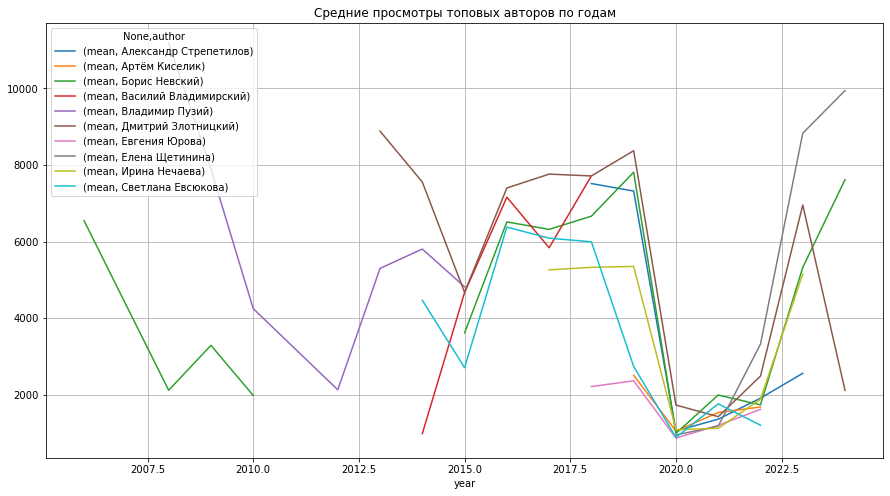

In [115]:
(
top.pivot_table(index=['year'], columns='author', values='views', aggfunc=['mean'])
.plot(grid=True, figsize=(15, 8), title='Средние просмотры топовых авторов по годам')
);

In [ ]:
# средние просмотры на 1 отзыв в год (суммарные просмотры за год / сумму отзывов за год)
# (суммарные просмотры / сумму слов за год)

In [116]:
top.info()

<class 'pandas.core.frame.DataFrame'>
Index: 523 entries, 2 to 700
Data columns (total 38 columns):
 #   Column                                                           Non-Null Count  Dtype         
---  ------                                                           --------------  -----         
 0   url                                                              523 non-null    object        
 1   author                                                           523 non-null    object        
 2   publ_date                                                        523 non-null    datetime64[ns]
 3   title                                                            523 non-null    object        
 4   description                                                      523 non-null    object        
 5   text                                                             523 non-null    object        
 6   views                                                            523 non-null    int64 

In [117]:
tt = top.pivot_table(index=['year'], columns='author', values=['views', 'text_len'], aggfunc=['sum'])

In [118]:
tt.columns.tolist()

[('sum', 'text_len', 'Александр Стрепетилов'),
 ('sum', 'text_len', 'Артём Киселик'),
 ('sum', 'text_len', 'Борис Невский'),
 ('sum', 'text_len', 'Василий Владимирский'),
 ('sum', 'text_len', 'Владимир Пузий'),
 ('sum', 'text_len', 'Дмитрий Злотницкий'),
 ('sum', 'text_len', 'Евгения Юрова'),
 ('sum', 'text_len', 'Елена Щетинина'),
 ('sum', 'text_len', 'Ирина Нечаева'),
 ('sum', 'text_len', 'Светлана Евсюкова'),
 ('sum', 'views', 'Александр Стрепетилов'),
 ('sum', 'views', 'Артём Киселик'),
 ('sum', 'views', 'Борис Невский'),
 ('sum', 'views', 'Василий Владимирский'),
 ('sum', 'views', 'Владимир Пузий'),
 ('sum', 'views', 'Дмитрий Злотницкий'),
 ('sum', 'views', 'Евгения Юрова'),
 ('sum', 'views', 'Елена Щетинина'),
 ('sum', 'views', 'Ирина Нечаева'),
 ('sum', 'views', 'Светлана Евсюкова')]

In [119]:
tt = tt[('sum', 'views')] / tt[('sum', 'text_len')]

In [120]:
# (суммарные просмотры / сумму слов за год)
tt

author  Александр Стрепетилов  Артём Киселик  Борис Невский  \
year                                                          
2006                      NaN            NaN      11.182906   
2008                      NaN            NaN       4.700779   
2009                      NaN            NaN       4.197957   
2010                      NaN            NaN       3.796545   
2012                      NaN            NaN            NaN   
2013                      NaN            NaN            NaN   
2014                      NaN            NaN            NaN   
2015                      NaN            NaN       6.432859   
2016                      NaN            NaN      10.717609   
2017                      NaN            NaN       9.317765   
2018                16.697778            NaN      13.684012   
2019                10.165000       3.857830      10.431115   
2020                 1.847401       2.187538       1.795510   
2021                 2.325342       2.925280       3.159127   
2022                 2.824444       2.734095       2.977850   
2023                 3.556328            NaN      10.541584   
2024                      NaN            NaN      15.737603   

author  Василий Владимирский  Владимир Пузий  Дмитрий Злотницкий  \
year                                                               
2006                     NaN             NaN                 NaN   
2008                     NaN       13.753071                 NaN   
2009                     NaN        9.844666                 NaN   
2010                     NaN        5.948179                 NaN   
2012                     NaN        2.988053                 NaN   
2013                     NaN        7.342342           14.672172   
2014                1.446086        9.441974           11.841693   
2015                8.192065        6.541412            8.517776   
2016               11.524297             NaN           14.274481   
2017                8.634059             NaN           14.079970   
2018               11.607884        9.124095           16.505885   
2019                     NaN             NaN           15.496827   
2020                     NaN        2.322095            3.341475   
2021                     NaN             NaN            2.522652   
2022                     NaN             NaN            3.897735   
2023                1.629684             NaN           12.017279   
2024                     NaN             NaN            4.230461   

author  Евгения Юрова  Елена Щетинина  Ирина Нечаева  Светлана Евсюкова  
year                                                                     
2006              NaN             NaN            NaN                NaN  
2008              NaN             NaN            NaN                NaN  
2009              NaN             NaN            NaN                NaN  
2010              NaN             NaN      15.501916                NaN  
2012              NaN             NaN            NaN                NaN  
2013              NaN             NaN            NaN                NaN  
2014              NaN             NaN            NaN           5.742765  
2015              NaN             NaN            NaN           3.753193  
2016              NaN             NaN            NaN           9.269546  
2017              NaN             NaN       8.422738           8.548348  
2018         4.289133             NaN      10.783852           9.328541  
2019         5.082221             NaN      10.950188           3.786387  
2020         1.941308        1.964730       2.168073           1.548513  
2021         2.315586        2.002633       2.161640           2.751152  
2022         2.573248        5.119355       3.482393           1.725998  
2023              NaN       15.885211       9.701742                NaN  
2024              NaN       20.172414            NaN                NaN

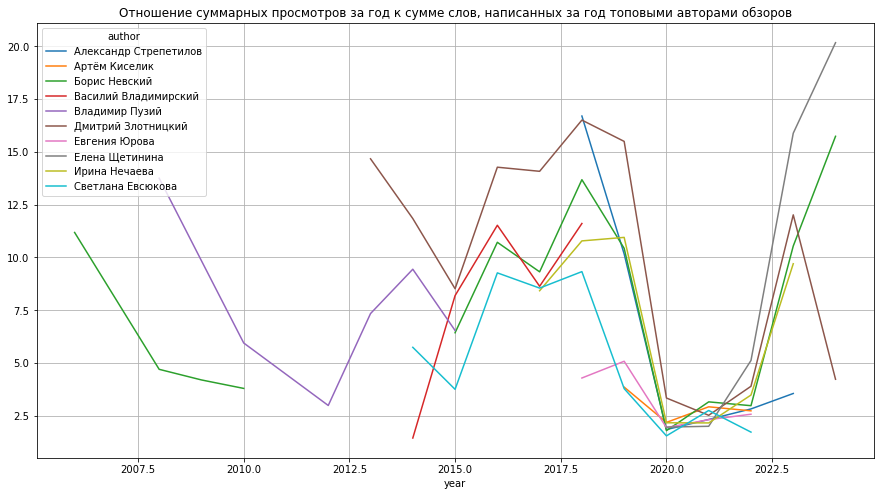

In [121]:
tt.plot(grid=True, figsize=(15, 8), title = "Отношение суммарных просмотров за год к сумме \
слов, написанных за год топовыми авторами обзоров");

Хуже всего это отношение у Светланы Евсюковой падает с 2017/18 г, однако в 2023/24 она ничего не написала. <br>
У Бориса Невского оно растет с 2020 г (новый максимум с 2018 г.). Также у Елены Щетининой (она только начала писать в 2020, вероятно ее максимум пройден).  <br>
У Дмитрия Золотницкого стабильно низкое за исключением 2023 г. максимум былв 2018 г.  <br>

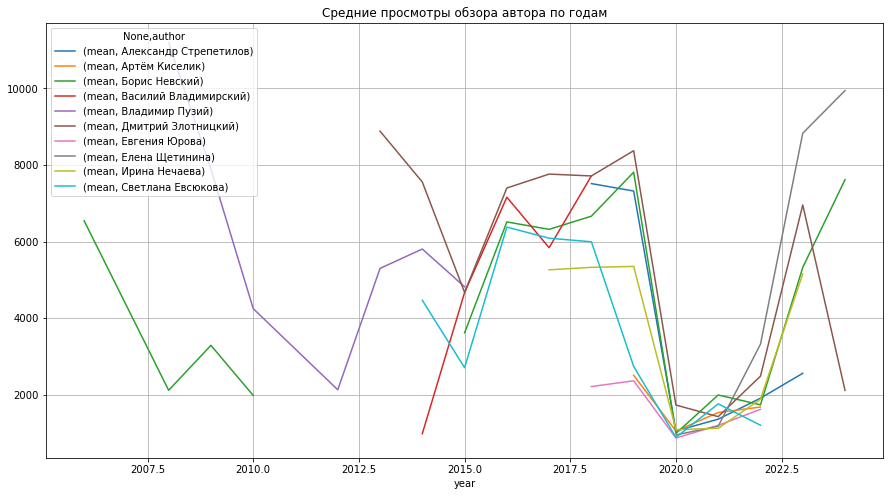

In [122]:
(
top.pivot_table(index=['year'], columns='author', values='views', aggfunc=['mean'])
.plot(grid=True, figsize=(15, 8), title = 'Средние просмотры обзора автора по годам')
);

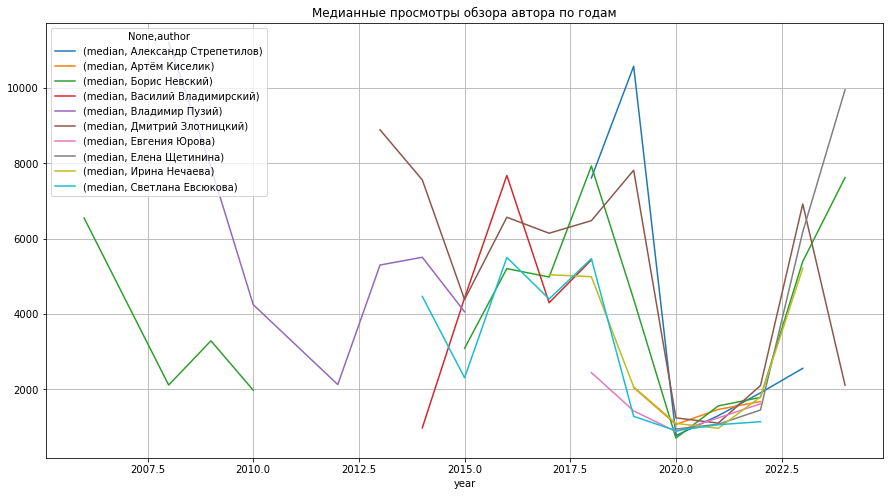

In [123]:
(
top.pivot_table(index=['year'], columns='author', values='views', aggfunc=['median'])
.plot(grid=True, figsize=(15, 8), title = 'Медианные просмотры обзора автора по годам')
);

In [124]:
# кто из топовых авторов в лидерах медианным просмотрам
a_v = top.groupby(['author'], as_index=False).agg({'views':'median'})
a_v.sort_values(by='views', ascending=False)

author   views
3   Василий Владимирский  4968.0
5     Дмитрий Злотницкий  4795.0
4         Владимир Пузий  4247.0
2          Борис Невский  3628.5
9      Светлана Евсюкова  3051.0
8          Ирина Нечаева  1737.5
7         Елена Щетинина  1558.0
0  Александр Стрепетилов  1301.0
1          Артём Киселик  1204.0
6          Евгения Юрова  1154.0

In [125]:
# кто по суммарным
a_v = top.groupby(['author'], as_index=False).agg({'views':'sum'})
a_v.sort_values(by='views', ascending=False)

author   views
9      Светлана Евсюкова  451231
2          Борис Невский  436506
5     Дмитрий Злотницкий  401397
3   Василий Владимирский  225565
8          Ирина Нечаева  185984
7         Елена Щетинина  149559
0  Александр Стрепетилов   99495
4         Владимир Пузий   96052
1          Артём Киселик   73520
6          Евгения Юрова   32422

## Natasha

In [126]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

# names_extractor = NamesExtractor(morph_vocab) # в новой версии нет

In [127]:
def get_word_POS (row, li = None, li_t = None, key_words_list = None):
    
    key_words_list = [] if key_words_list is None else key_words_list
    li_t = [] if li_t is None else li_t
    li = [] if li is None else li
                  
    text = row['description'] + row['text']
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)
    doc.tag_ner(ner_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    for span in doc.spans:
        span.normalize(morph_vocab)
   
    # cущ
    noun_l = [t.lemma for t in doc.tokens if t.pos == 'NOUN']
    if noun_l:
        row['text_NOUN'] = list(set(noun_l))
        key_words_list = key_words_list + [tup[0] for tup in Counter(noun_l).most_common(2)]
    else:
        row['text_NOUN'] = []

    # chunks из текста
    for i in range(len(doc.tokens)):
        j = i+1
        if j < len(doc.tokens):
            if (doc.tokens[i].pos == "ADJ"\
                and doc.tokens[j].pos == "NOUN")\
            or (doc.tokens[i].pos == "DET"\
                and doc.tokens[i].rel == "det"\
                and doc.tokens[j].pos == "NOUN")\
            or (doc.tokens[i].pos == "NOUN"\
                and doc.tokens[j].pos == "NOUN"\
                and doc.tokens[j].rel == "nmod")\
            or (doc.tokens[i].pos == "NOUN"\
                and doc.tokens[j].pos == "ADJ"):
                li_t.append([doc.tokens[i].lemma, doc.tokens[j].lemma])
    
    li_t = [" ".join(l) for l in li_t]
    key_words_list = key_words_list + [tup[0] for tup in Counter(li_t).most_common(2)]
    
    # NER для текста
    per_l = [s.normal for s in doc.spans if s.type == 'PER']
    # если есть Ф+И то И -> Ф+И и Ф -> Ф+И
    l2 = [l for l in per_l if len(l.split(' '))> 1]
    rez_d = {l:l.split() for l in l2}
    rec_dic = {v:k for k, l in rez_d.items() for v in l}
    per_l = [pd.Series(l).replace(rec_dic).to_list() for l in per_l]
    per_l = sum(per_l, [])
    
    loc_l = [s.normal for s in doc.spans if s.type == 'LOC']
    org_l = [s.normal for s in doc.spans if s.type == 'ORG']
    
    if per_l: 
        row['text_ent_PER'] = list(set(per_l))
        key_words_list = key_words_list + [tup[0] for tup in Counter(per_l).most_common(2)]
    else:
        row['text_ent_PER'] = []
    
    if loc_l: 
        row['text_ent_LOC'] = list(set(loc_l))
    else:
        row['text_ent_LOC'] = []
    
    if org_l: 
        row['text_ent_ORG'] = list(set(org_l))
    else:
        row['text_ent_ORG'] = []
    
    # прил
    adj_l = [t.lemma for t in doc.tokens if t.pos == 'ADJ']
    if adj_l:
        row['text_ADJ'] = list(set(adj_l))
        key_words_list = key_words_list + [tup[0] for tup in Counter(adj_l).most_common(2)]
    else:
        row['text_ADJ'] = []
    
    row['key_words'] = key_words_list
    
    return row


In [128]:
# применили функцию выше
top = top.apply(get_word_POS, axis=1)

In [129]:
top.sample(10)

url              author  \
40   https://www.mirf.ru/book/kristofer-byulman-vor...      Елена Щетинина   
311  https://www.mirf.ru/book/catherynne-m-valente-...       Артём Киселик   
540  https://www.mirf.ru/book/iskusstvo-deus-ex-uni...  Дмитрий Злотницкий   
26   https://www.mirf.ru/book/zamil-ahtar-stalnye-b...       Ирина Нечаева   
187    https://www.mirf.ru/book/piter-nyuman-strannik/      Елена Щетинина   
603  https://www.mirf.ru/book/bookreview/chris-beck...   Светлана Евсюкова   
367  https://www.mirf.ru/book/dzhon-gvinn-a-time-of...       Артём Киселик   
583  https://www.mirf.ru/book/ken-lyu-korolevskie-m...   Светлана Евсюкова   
326  https://www.mirf.ru/book/dzhasper-fforde-ranny...   Светлана Евсюкова   
306  https://www.mirf.ru/book/brandon-sanderson-leg...  Дмитрий Злотницкий   

     publ_date                                              title  \
40  2023-05-16  Кристофер Бьюлман «Вор с чёрным языком». Тяжёл...   
311 2020-02-16  Кэтрин М. Валенте «Сияние»: поразительный косм...   
540 2017-03-28                         Искусство Deus Ex Universe   
26  2023-09-16  Замиль Ахтар «Стальные боги». Две империи, два...   
187 2021-05-18  Питер Ньюман «Странник»: путешествие молчаливо...   
603 2016-06-13  Крис Бекетт «Во тьме Эдема». Старомодная прикл...   
367 2019-05-07  Джон Гвинн A Time of Dread: начало достойного ...   
583 2016-09-25                       Кен Лю «Королевские милости»   
326 2019-11-27                     Джаспер Ффорде «Ранняя пташка»   
306 2020-02-24  Брендон Сандерсон «Легион»: детектив о воображ...   

                                           description  \
40    Кинч На Шаннак, юный вор, задолжал за обучени...   
311   1944 год, освоенная людьми Солнечная система....   
540  Хотя события игр Deus Ex: Human Revolution и D...   
26    Михей Железный, верный слуга Архангела, собир...   
187   Мрачный мир, в котором силы зла царствуют без...   
603  Пятнадцатилетний Джон Красносвет живёт на дико...   
367                             Удачно: . Неудачно: .    
583  Во главе восстания против императора Мапидэрэ,...   
326   Грядёт очередная Зима, и население Уэльса, ка...   
306   У Стивена Лидса по прозвищу Легион очень мног...   

                                                  text  views  year  \
40    Авантюрное фэнтези сглавным героем-трикстером...   7932  2023   
311   Кэтрин М. Валенте называет свой роман декопан...   1288  2020   
540   Оригинальная Deus Ex вышла на рубеже тысячеле...   3388  2017   
26    Пожалуй, сильнее всего в «Стальных богах» впе...   6548  2023   
187   «Роуд-стори», наверное, самый популярный тип ...   1442  2021   
603   С юношеской фантастикой, выходящей в серии «С...   5499  2016   
367   Достойное эпическое боевое фэнтези в духе «Са...   4917  2019   
583   «Королевские милости» — дебютный роман Кена Л...   5447  2016   
326   Свежий роман Джаспера Ффорде вырос изнастольк...    831  2019   
306   Мызнаем Брендона Сандерсона как автора фэнтез...   1264  2020   

    month_year                                              gener  ...  \
40     2023-05  [авантюрное фэнтези, тёмное / готическое фэнте...  ...   
311    2020-02  [социальная / "мягкая" фантастика / антиутопия...  ...   
540    2017-03            [путеводитель по вымышленной вселенной]  ...   
26     2023-09  [тёмное / готическое фэнтези / нуар, ориенталь...  ...   
187    2021-05  [постапокалипсис / катастрофа, тёмное / готиче...  ...   
603    2016-06  [эпическое / приключенческое / героическое фэн...  ...   
367    2019-05                                                 []  ...   
583    2016-09  [эпическое / приключенческое / героическое фэн...  ...   
326    2019-11                  [юмористическое фэнтези, триллер]  ...   
306    2020-02  [эпическое / приключенческое / героическое фэн...  ...   

     тёмное / готическое фэнтези / нуар хоррор  \
40                                    1      0   
311                                   0      0   
540                                   0      0

In [130]:
# сохраним в переменной списко имен колонок в которых будем суммировать списки
col_names = top.columns.tolist()[-6:]
sum_list = ['sum']*len(col_names)
col_names_dic = dict(zip(col_names, sum_list))

In [131]:
# сгруппировали
top_grup = top.groupby(['author'], as_index=False).agg(col_names_dic)

In [132]:
top_grup

author                                          text_NOUN  \
0  Александр Стрепетилов  [теория, род, вселенная, ретроспектива, кино, ...   
1          Артём Киселик  [конвент, язык, роман, скорбный, человек, юмор...   
2          Борис Невский  [воспоминание, асучетом, прошлое, роман, наумс...   
3   Василий Владимирский  [сцена, пространство, создатель, зона, середин...   
4         Владимир Пузий  [мистер, легенда, роман, человек, пророчество,...   
5     Дмитрий Злотницкий  [язык, мыдоверять, ученица, роман, кнаиболее, ...   
6          Евгения Юрова  [вселенная, скрипка, роза, интриганский, роман...   
7         Елена Щетинина  [спойлерывторичность, вселенная, роман, челове...   
8          Ирина Нечаева  [достижение, языкастремительность, язык, пора,...   
9      Светлана Евсюкова  [язык, йоллец, роман, прошлое, человек, образо...   

                                        text_ent_PER  \
0  [Дмитрий, Екатерина Звонцова, Варвара Перова, ...   
1  [Энди Вейер, Энди Вейера, Джеймс Кори, Джим Ба...   
2  [плутаСтоит, Брендон Сандерсон, оЯпонии, Сэйун...   
3  [Стражински-старший, Леонид Мойжес, Человек-па...   
4  [Срединного Мир, Н. Григорьев, Эльфхэйм, Алекс...   
5  [ноДрездена, Посути, Джеймс, Гарри ДрезденаНеу...   
6  [Жанна Фруаделак, Виктор Диксен, Людовик XIV, ...   
7  [Терри Пратчетт иСтивен Бриггс, Стивен Бриггс,...   
8  [Сира иЗедра, Аланьи, Тамаз, Зедра, Замиль Ахт...   
9  [Осоты, Аррф, Эльза Бауэр, Осот, Лео Парсель, ...   

                                        text_ent_LOC  \
0  [Англию-Францию, Свортек, Центральная Европа, ...   
1  [Запад, Земля, Мировое Злом, Ремарке, Республи...   
2  [Англия, Индия, Восток, Британия, именемМ, Мар...   
3  [Чула-Вист, Российская империя, Нью-Йорк, Голл...   
4  [Срединного Мир, Бервикшир, Волшебный Край, Эй...   
5  [Дрезден, Аннурская империя, Стейвли, Домбанг,...   
6  [Франция, Магны Вампирии, Европа, Земля, Челяб...   
7  [Лламедос, Кипсек, Индия, Нидерландов, вГенера...   
8  [Восток, Верхний Предел, Орда, Орды, Костани, ...   
9  [Альтагор, Ортленд, Алистан Каменный Берег, Не...   

                                        text_ent_ORG  \
0  [РПЦ, СМИ, ЖЖ, Сироток, Сиротки, АСТ, Питер Пе...   
1  [НФ, Марсианин, НФ, Миротворческие силы, NASA,...   
2  [Патруля время, МТА, Аппарат Уолсингема, Блонд...   
3  [Marvel Comics, Люди Иисуса, Filmation, Вавило...   
4  [Мобильник, Противостояние, Друд, Второй Уилки...   
5  [Мэб, Азбука, Архивы Дрездена, Полари, Лаборат...   
6  [Двор, Сумерек, Церковь Иисуса Христа Святые п...   
7  [СС, Плоский мир, Путеводитель поПлоскому миру...   
8  [НФ, Красные повязок, НФ, Небьюлу, Хьюго, Галл...   
9  [Путешествия Гулливера, Масштаб, Мир фантастик...   

                                            text_ADJ  \
0  [вечный, неверный, светлый, мистический, самый...   
1  [оптимистичный, светлый, неверный, научность, ...   
2  [сэлемента, первоначальный, ранний, тяжкий, ко...   
3  [расположить, сексуальный, 11, очный, махровый...   
4  [старый, фэнтезийный, красивый, емкий, отдален...   
5  [личный, кпопулярный, инеслишек, настраницах, ...   
6  [достойный, родный, французский, психологическ...   
7  [должный, гибкий, социальный, личный, дополнит...   
8  [втом, третий, напервый, икрасивый, насамом, м...   
9  [заключительный, далекий, веснар, малый, трети...   

                                           key_words  
0  [смерть, любовь, тема любовь, магический реали...  
1  [книга, герой, научный фантастика, ваш имя, Эн...  
2  [роман, герой, иувлекательный авантюра, авантю...  
3  [год, автор, сумеречный зона, космический стан...  
4  [история, роман, этот история, сотня год, Тома...  
5  [роман, цикл, грязный игра, городской фэнтези,...  
6  [книга, цель, везение героиня, неправдоподобны...  
7  [путеводитель, мир, плоский мир, любопытный иг...  
8  [кровь, бог, стальной бог, кровь завоеватель, ...  
9  [мир, повесть, слово погибель, детективный сюж...

In [133]:
removing_list = ['жанр', 'книга', 'итог', 'оценка', 'роман', 
                 'человек', 'год', 'автор', 'персонаж', 'год',
                'финал', 'читатель', 'страница', 'часть', 'текст',
                'сюжет', 'том', 'писатель', 'произведение', 'поклонник',
                'повествование', 'любитель', 'раз', 'Похоже', 
            'Неплохо', 'Ксожалению', 'Винтервью', 'Ксчастью', 'Вобщем',
                'Отлично', 'Оценка',
                'другой', 'первый', 'новый', 'самый', 'последний', 'сам', 'третий']   

removing_dic = {'жанр', 'книга', 'итог', 'оценка', 'роман', 
                 'человек', 'год', 'автор', 'персонаж', 'год',
                'финал', 'читатель', 'страница', 'часть', 'текст',
                'сюжет', 'том', 'писатель', 'произведение', 'поклонник',
                'повествование', 'любитель', 'раз', 'Похоже', 
            'Неплохо', 'Ксожалению', 'Винтервью', 'Ксчастью', 'Вобщем',
                'Отлично', 'Оценка'} 

#             'Светлана Евсюкова',
#              'Борис Невский',
#              'Дмитрий Злотницкий',
#              'Ирина Нечаева',
#              'Артём Киселик',
#              'Василий Владимирский',
#              'Елена Щетинина',
#              'Александр Стрепетилов',
#              'Евгения Юрова',
#              'Владимир Пузий']

In [134]:
# добавим в STOPWORDS WordCloud, но они как-то плохо работают
stopwords = set(STOPWORDS)
stopwords = stopwords.union(removing_dic)

In [137]:
# копия
top_grup2 = top_grup

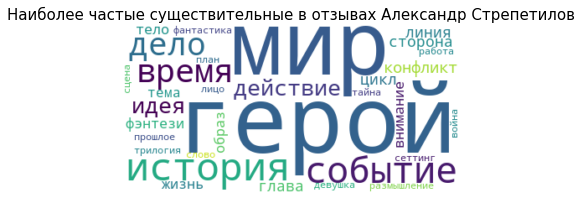

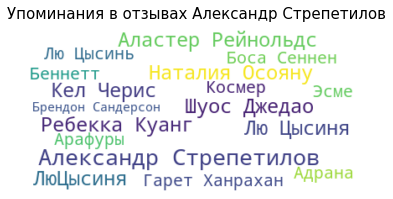

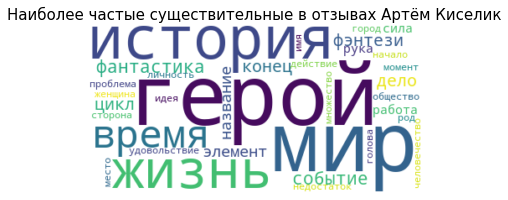

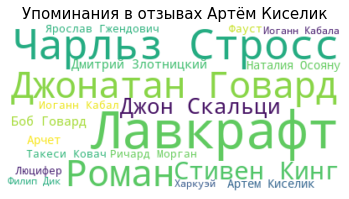

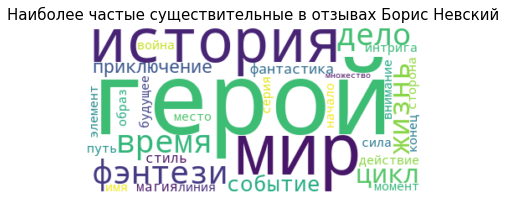

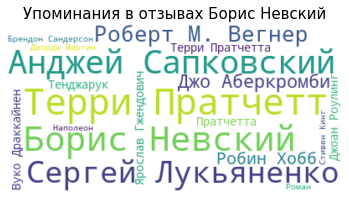

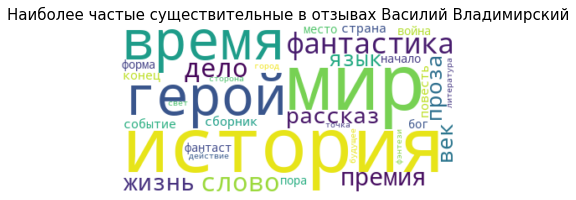

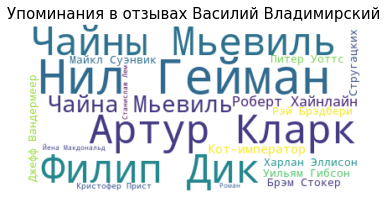

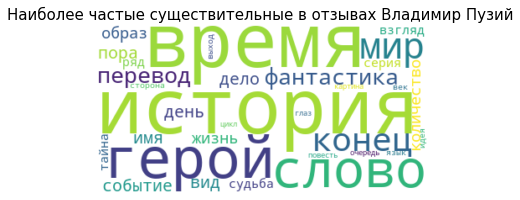

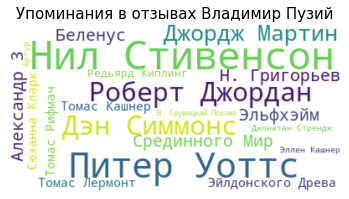

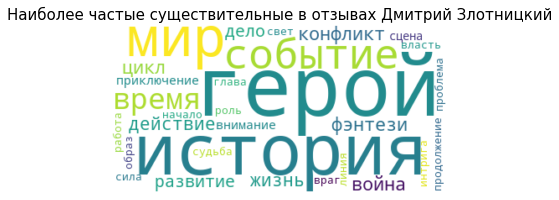

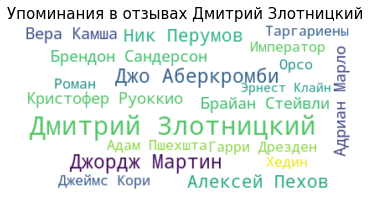

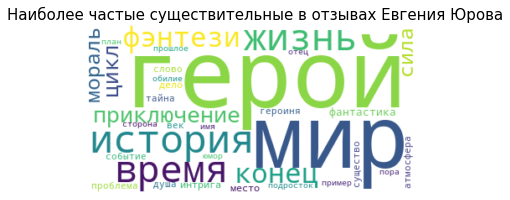

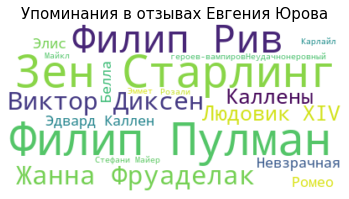

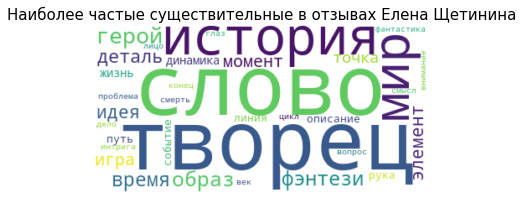

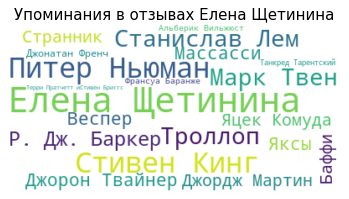

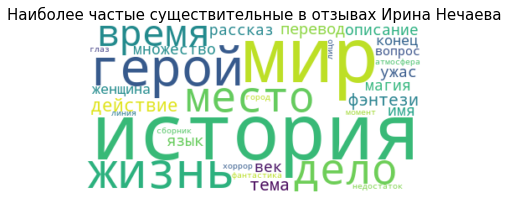

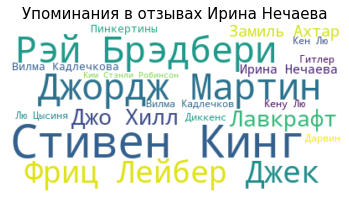

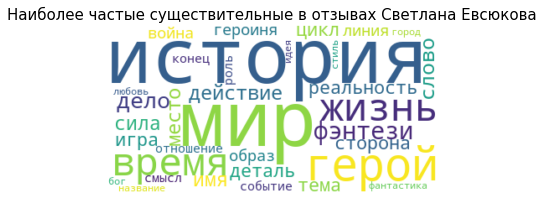

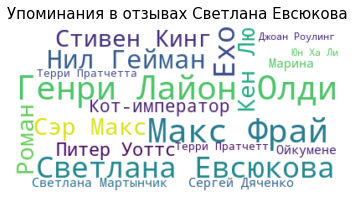

In [138]:
# облака слов в цикле
wc = WordCloud(background_color="white", max_words=50, stopwords = stopwords)


for author in top_grup2['author'].unique():
    l = top_grup2.loc[top_grup2['author'] == '{}'.format(author), 'text_NOUN'].tolist()[0]
#     for w in removing_list:
#         if w in l:
#             l.remove(w)
#         else:
#             pass
    count = Counter(l).most_common(50) #[-25:]
    text = {word: value for word, value in count if word not in removing_list}
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Наиболее частые существительные в отзывах {}".format(author), fontsize=15)
    plt.show()

    l2 = top_grup2.loc[top_grup['author'] == '{}'.format(author), 'text_ent_PER'].tolist()[0]
#     last_names = []
#     for pers in l2:
#         if len(pers) > 1:
#             last_names.append(pers.split()[-1])
#         else:
#             last_names.append(pers)
    count2 = Counter(l2).most_common(20)
    text = {word: value for word, value in count2 if word not in removing_list}
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Упоминания в отзывах {}".format(author), fontsize=15)
    plt.show()
    print()
    print()

В упоминаниях есть повторы типа: ИФ - Ф, И(-я,ю,а)Ф(-я,ю,а). Надо исправить. 

In [139]:
# словарь для замены упоминаний
rr = {
    'Лю Цысиня':'Лю Цысинь',
    'ЛюЦысиня':'Лю Цысинь',
    'ЛюЦысинь':'Лю Цысинь',
    'Цысиня':'Лю Цысинь',
    'Цысинь':'Лю Цысинь',
    'Чэнь Цюфаня':'Чэнь Цюфань',
    'Цюфань':'Чэнь Цюфань',
    
    'Йена Макдональд':'Йен Макдональд',
    'Макдональда':'Йен Макдональд',
    
    'Аластер':'Аластер Рейнольдс',
    'Аластера':'Аластер Рейнольдс',
    'Рейнольдс':'Аластер Рейнольдс',
    'Рейнольдса':'Аластер Рейнольдс',
    
    'Иоганн Кабала':'Иоганн Кабал',
    'Иоганна':'Иоганн Кабал',
    'Иоганна Кабала':'Иоганн Кабал',
    
    'Энди Вейера':'Энди Вейер',
    'Вейера':'Энди Вейер',
    'Энди':'Энди Вейер',

    'Дэвид Вонг)':'Дэвид Вонг',
    'Вонг':'Дэвид Вонг',
    'Вонга':'Дэвид Вонг',
    'Дэйв':'Дэвид Вонг',

    'Лавкрафт':'Говард Лавкрафт',
    'Лавкрафта':'Говард Лавкрафт',

    'Кинг':'Стивен Кинг',
    'Кинга':'Стивен Кинг',

    'Терри Пратчетта':'Терри Пратчетт',
    'Пратчетта':'Терри Пратчетт',
    'Пратчетту':'Терри Пратчетт',

    'Аберкромби':'Джо Аберкромби',

    'Коулы':'Коул Шаэ',
    'Коулу':'Коул Шаэ',

    'Роулинг':'Джоан Роулинг',

    'Кинг':'Стивен Кинг',
    
    'Роберт Вегнер':'Роберт М. Вегнер',
    'Вегнер':'Роберт М. Вегнер',

    'Лукьяненко':'Сергей Лукьяненко',

    'Азимов':'Айзек Азимов',
    'Азимова':'Айзек Азимов',

    'Брэдбери':'Рэй Брэдбери',
    'Рэй':'Рэй Брэдбери',
    'Рэя':'Рэй Брэдбери',

    'Чайны Мьевиль':'Чайна Мьевиль',
    'Чайна':'Чайна Мьевиль',
    'Чайну':'Чайна Мьевиль',
    'Мьевиль':'Чайна Мьевиль',
    'Чайны Мьевиля':'Чайна Мьевиль',
    'Мьевиля':'Чайна Мьевиль',

    'Дик':'Филип Дик',
    'Дика':'Филип Дик',
    'Филип К. Дик':'Филип Дик',

    'Брайан Олдисса':'Брайан Олдисс',
    'Олдисса':'Брайан Олдисс',
    'Олдисс':'Брайан Олдисс',

    'Уилки Коллинза':'Уилки Коллинз',
    'Коллинз':'Уилки Коллинз',
    'Уилки':'Уилки Коллинз',
    'У.К.':'Уилки Коллинз',

    'Вилма Кадлечков':'Вилма Кадлечкова',
    'Кадлечкова':'Вилма Кадлечкова',
    'Вилма':'Вилма Кадлечкова',

    'Кену Лю':'Кен Лю',
    'Кена Лю':'Кен Лю',
    'Вилма':'Кен Лю',

    'Мартин':'Джордж Мартин',
    'Джордж Р. Р. Мартин':'Джордж Мартин',
    'Мартина':'Джордж Мартин',

    'Станислава Лема':'Станислав Лем',
    'Лема':'Станислав Лем',
    'Лем':'Станислав Лем',
                     
}


In [140]:
# замена .explode() + .replace()
top_grup3 = top_grup2.explode('text_ent_PER').replace(rr).groupby(['author'], as_index=False)['text_ent_PER'].agg(list)
            

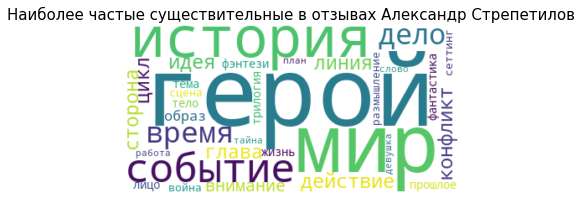

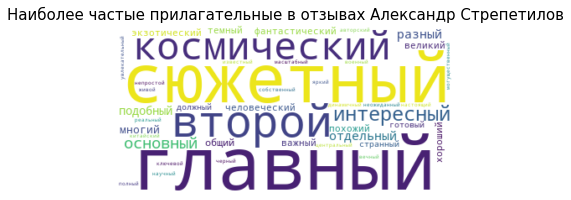

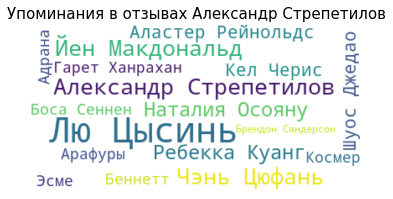

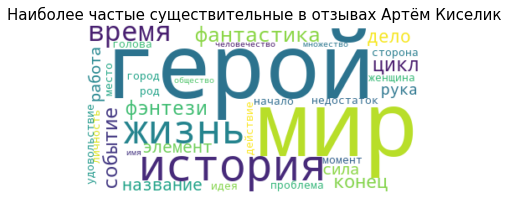

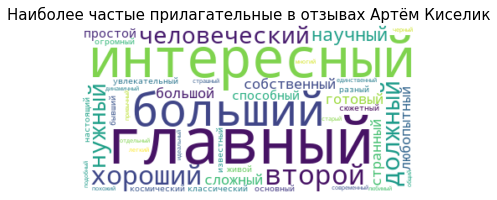

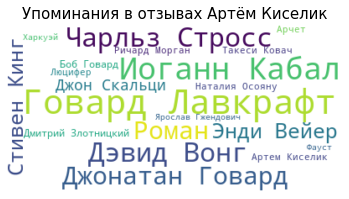

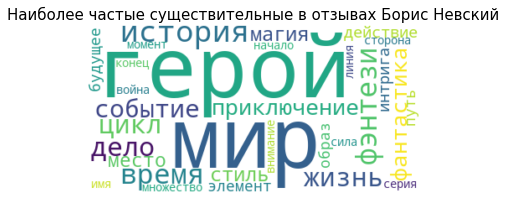

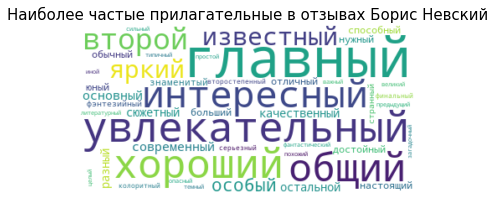

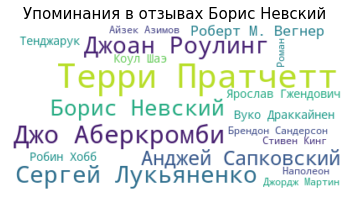

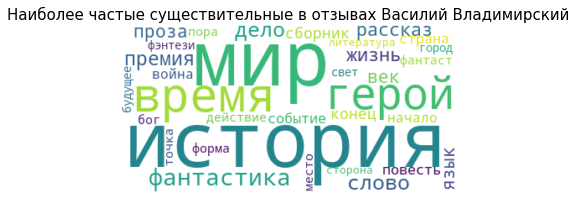

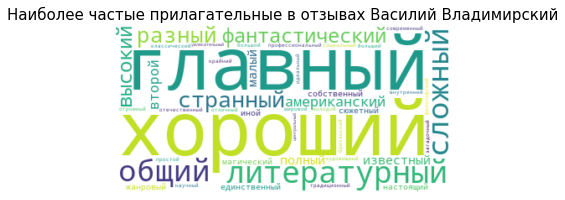

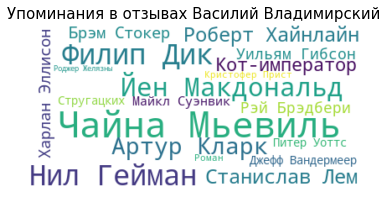

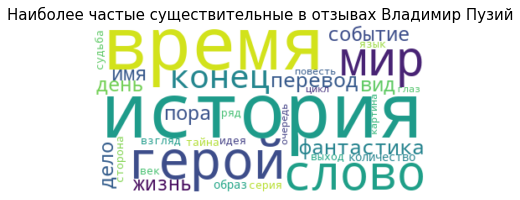

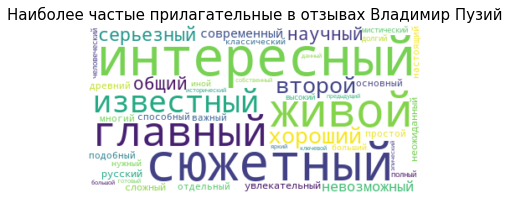

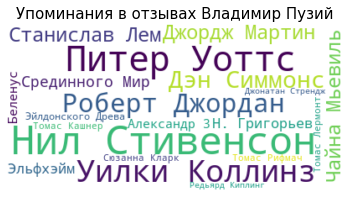

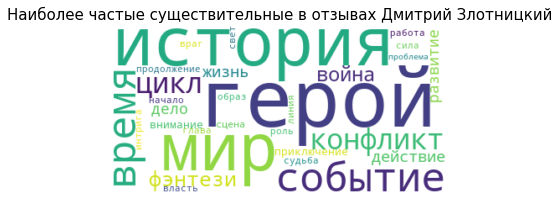

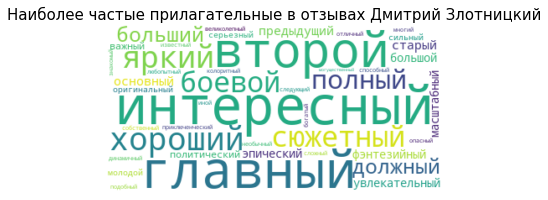

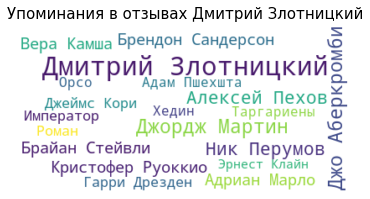

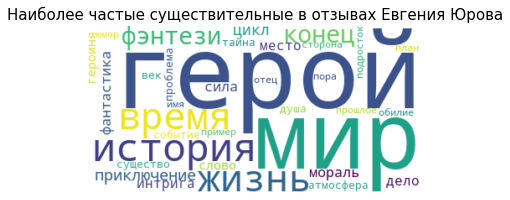

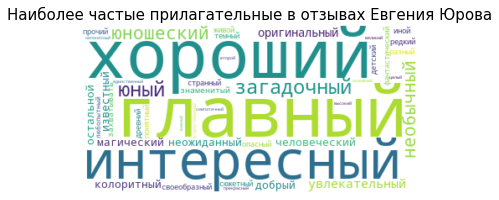

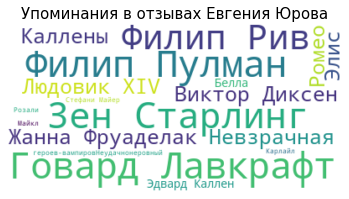

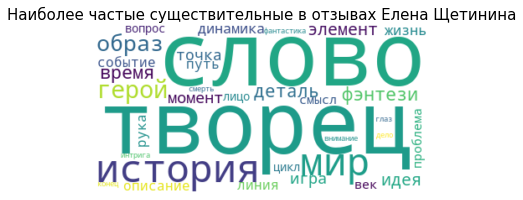

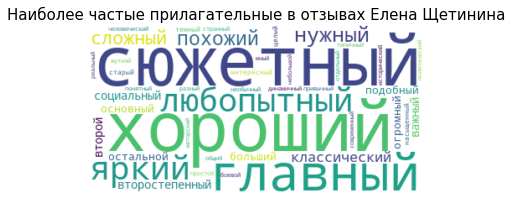

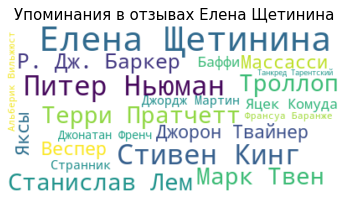

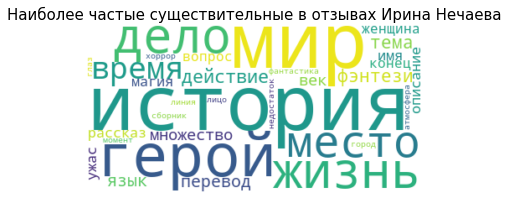

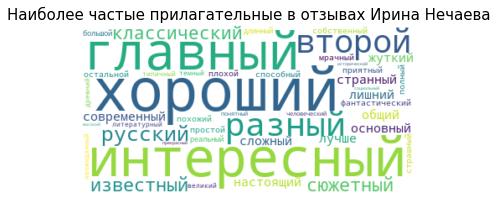

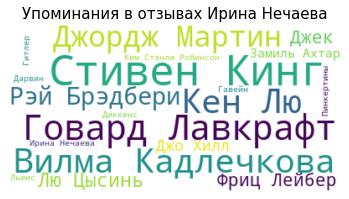

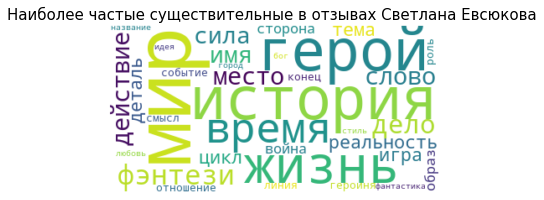

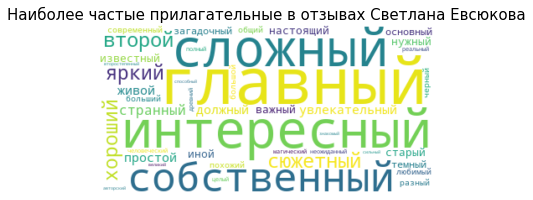

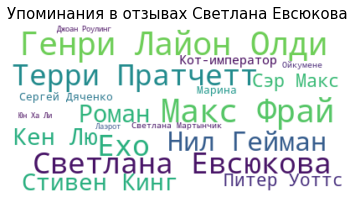

In [141]:
# итоговое облако

wc = WordCloud(background_color="white", max_words=50, stopwords = stopwords)


for author in top_grup2['author'].unique():
    l = top_grup2.loc[top_grup2['author'] == '{}'.format(author), 'text_NOUN'].tolist()[0]
#     for w in removing_list:
#         if w in l:
#             l.remove(w)
#         else:
#             pass
    count = Counter(l).most_common(50) #[-25:]
    text = {word: value for word, value in count if word not in removing_list}
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Наиболее частые существительные в отзывах {}".format(author), fontsize=15)
    plt.show()
    
    l3 = top_grup2.loc[top_grup2['author'] == '{}'.format(author), 'text_ADJ'].tolist()[0]
#     for w in removing_list:
#         if w in l:
#             l.remove(w)
#         else:
#             pass
    count = Counter(l3).most_common(50) #[-25:]
    text = {word: value for word, value in count if word not in removing_list}
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Наиболее частые прилагательные в отзывах {}".format(author), fontsize=15)
    plt.show()

    l2 = top_grup3.loc[top_grup['author'] == '{}'.format(author), 'text_ent_PER'].tolist()[0]
#     last_names = []
#     for pers in l2:
#         if len(pers) > 1:
#             last_names.append(pers.split()[-1])
#         else:
#             last_names.append(pers)
    count2 = Counter(l2).most_common(20)
    text = {word: value for word, value in count2 if word not in removing_list}
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Упоминания в отзывах {}".format(author), fontsize=15)
    plt.show()
    print()
    print()

В итоге можем что-то сказать об авторах отзывов, зная их предпочтения к жанрам. Например, кто любимые авторы авторы в соответствующих жанрах (или на ком специализируются). Какие существительные, прилагательные характерны для соответствующих жанров, авторов. Что выделяется.
<br><br>
Для всех авторов обзоров/жанров фэнтези важен "главный" "герой" + "мир"
<br><br>
Авторы обзоров часто используют такие прилагательные, которые также говорят, что для них важно в книге о которой пишут (+ осно сущ):<br>
Александр Стрепетилов/космооперы + НФ - "сюжетный" ("событие", "действие", "время", "идея")<br>
Артём Киселик/твердая НФ - "интересный" (история, время, жизнь)<br>
Борис Невский/НФ + эпич + детектив + авантюрн - "увлекательный"<br>
Дмитрий Злотницкий/эпическое - "интересный/яркий/боевой" (история, мир, событий, время, конфликт)<br>
Евгения Юрова/подростковое - "интересный/юный/загадочный" (мир, история, время, жизнь)<br>
Елена Щетинина/темное и готическое - "сюжетный" (и не так уж часто "жуткий", "темный")<br>
Ирина Нечаева/мистика и хоррорам - "разный"<br>
Светлана Евсюкова/НФ + мифологичское + историческо - "интересный/сложный"<br>